

For this analysis, we're modeling a **4:1 split-rate tax** where land is taxed at four times the rate of buildings.

## Policy Definition for Spokane


For this analysis, we're modeling:
- **Revenue-neutral** property tax split for the South Bend School Corporation
- **4:1 land-to-building tax ratio** (partial LVT shift)
- **Existing exemptions and abatements** continue to apply
- **Focus on school corporation taxes** (which bypass Indiana's property tax caps)

Let's begin by importing the necessary libraries and utility functions.


In [276]:
# Import utility functions
import sys
import pandas as pd
import geopandas as gpd
sys.path.append('..')  # Add parent directory to path

# Import from local utility modules
from lvt_utils import ensure_geodataframe

print("✅ Utility functions imported from lvt_utils")


✅ Utility functions imported from lvt_utils


In [277]:
# Import all required modules and functions
from cloud_utils import get_feature_data, get_feature_data_with_geometry
from lvt_utils import (model_split_rate_tax, calculate_current_tax, model_full_building_abatement, 
                       model_stacking_improvement_exemption, categorize_property_type, extract_date_from_filename)
from census_utils import (get_census_data, get_census_blockgroups_shapefile, get_census_data_with_boundaries, 
                          match_to_census_blockgroups, calculate_median_percentage_by_quintile, 
                          match_parcels_to_demographics, create_demographic_summary)
from viz import (create_scatter_plot, plot_comparison, calculate_correlations, weighted_median, 
                 create_quintile_summary, plot_quintile_analysis, create_property_category_chart, 
                 create_map_visualization, calculate_block_group_summary, filter_data_for_analysis)

scrape_data = 0

## Step 1: Getting the Data


https://gismo.spokanecounty.org/arcgis/rest/services/SCOUT/PropertyLookup/MapServer/0/query?f=json&where=PID_NUM%20%3D%20%2725011.1709%27&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=site_address%2Csite_city%2Cowner_name%2Cdocument_date%2Cgross_sale_price%2Cexcise_nbr%2Ctransfer_type%2Cprop_use_desc%2Ctax_code_area%2Cacreage%2CInspectionYear

In [278]:

import os
from datetime import datetime
import glob

# Directory to save/load data
data_dir = "data/spokane"
os.makedirs(data_dir, exist_ok=True)

if scrape_data == 1:
    # Base URL for the ArcGIS services
    base_url = "https://services1.arcgis.com/ozNll27nt9ZtPWOn/ArcGIS/rest/services/"
    # Fetch the main parcel dataset with tax info
    parcel_civic_df = get_feature_data_with_geometry('Parcels', base_url)
    # Save with geometry to parquet, with current date
    today_str = datetime.now().strftime("%Y_%m_%d")
    out_path = os.path.join(data_dir, f"spokane_parcels_{today_str}.parquet")
    parcel_civic_df.to_parquet(out_path, index=False)
    print(f"Saved new scrape to {out_path}")
else:
    # Find the most recent parquet file in the data_dir
    files = glob.glob(os.path.join(data_dir, "spokane_parcels_*.parquet"))
    if not files:
        raise FileNotFoundError("No previously scraped parcel files found in data/spokane/")
    # Sort files by date in filename
    files_sorted = sorted(files, key=lambda x: datetime.strptime(os.path.basename(x).replace("spokane_parcels_", "").replace(".parquet", ""), "%Y_%m_%d"), reverse=True)
    latest_file = files_sorted[0]
    print(f"Loading most recent scrape: {latest_file}")
    parcel_civic_df = pd.read_parquet(latest_file)

# Ensure parcel_civic_df is a proper GeoDataFrame
parcel_civic_df = ensure_geodataframe(parcel_civic_df)
print(f"✅ Parcel data loaded as {type(parcel_civic_df).__name__} with CRS: {parcel_civic_df.crs}")


Loading most recent scrape: data/spokane/spokane_parcels_2025_09_18.parquet
Direct conversion failed: Input must be valid geometry objects: b"\x01\x03\x00\x00\x00\x01\x00\x00\x00\t\x00\x00\x00C\xc0'4\x15m]\xc0\xfc\xf2Z\xf8\x9b\xaaG@8\xe1\x805\x15m]\xc0\xcf\x17[\xf8\x9b\xaaG@F\xa3\x16\xa3lm]\xc0\x04\xdeC\xf3\x9b\xaaG@\xb7\xeb\xc3\xa3lm]\xc0J\xb9E\xf3\x9b\xaaG@6J\x04\x12\xc4m]\xc0\x95\xdf\x11\xec\x9b\xaaG@x\xc2\xd5\x9e\xc3m]\xc0\\\x87WU\x14\xabG@\x1e\x06\xa3+\xc3m]\xc0\xc8\x06\xa1\xbe\x8c\xabG@\xaf\xcc%\x19\x12m]\xc0\xfdl\xee6\x8c\xabG@C\xc0'4\x15m]\xc0\xfc\xf2Z\xf8\x9b\xaaG@"
✅ Parcel data loaded as GeoDataFrame with CRS: EPSG:4326


Charge data comes from:  https://gisdatacatalog-spokanecounty.opendata.arcgis.com/pages/parcel-data-file-downloads


In [279]:

print(parcel_civic_df.columns)


Index(['OBJECTID', 'PID_NUM', 'ACO_NUM', 'PIDMAP', 'parcel', 'exmp_code',
       'exmp_amt', 'nbhd_code', 'nbhd_name', 'prop_use_code', 'prop_use_desc',
       'tax_year', 'site_address', 'site_str_nbr', 'site_str_nbr_suf',
       'site_str_dir', 'site_str_dir_suf', 'site_str_name', 'site_str_type',
       'site_apartment', 'site_city', 'site_state', 'site_zip', 'soil_id',
       'bldg_only_flag', 'vacant_land_flag', 'res_com_flag', 'appraiser_id',
       'acreage', 'assessed_amt', 'taxable_amt', 'tax_code_area',
       'inspection_cycle', 'parcel_location', 'land_value',
       'asmt_year_exmp_code', 'asmt_year_exmp_amt', 'eff_from_date',
       'eff_to_date', 'asmt_year', 'seg_status', 'Shape__Area',
       'Shape__Length', 'geometry'],
      dtype='object')


In [280]:
# Load charge_info_1 and charge_info_2 from Excel files in data/spokane/
charge_info_1 = pd.read_excel(os.path.join(data_dir, "charge_info_1.xlsx"))
charge_info_2 = pd.read_excel(os.path.join(data_dir, "charge_info_2.xlsx"))

# Check if charge_info_1 and charge_info_2 have the same columns
if list(charge_info_1.columns) == list(charge_info_2.columns):
    millage_df = pd.concat([charge_info_1, charge_info_2], ignore_index=True)
else:
    print("❌ charge_info_1 and charge_info_2 do not have the same column names.")
    millage_df = None

# Display the dataframe if it was created
if millage_df is not None:
    pd.set_option('display.max_columns', None)
    display(millage_df.head(5))


print("Counts of charge_type in millage_df:")
if millage_df is not None:
    print(millage_df['charge_type'].value_counts(dropna=False).to_string())
else:
    print("millage_df is None, cannot print charge_type counts.")


,parcel,tax_year,charge_type,charge_amt,charge_due
0,0.00004,2025,A/V Principal-Excess,100.09,0.00
1,0.00004,2025,A/V Principal-Regular,125.43,0.00
2,0.000041,2025,A/V Principal-Regular,62.24,31.12
3,0.000041,2025,A/V Principal-Excess,65.68,32.84
4,0.000057,2025,A/V Principal-Regular,36.80,0.00


Counts of charge_type in millage_df:
charge_type
A/V Principal-Regular                                236251
A/V Principal-Excess                                 227487
Weed Control Principal  WCWEED1                      212216
Soil Conservation Principal  CNSV1                   209633
Aquifer Principal  HOUSE                              61417
State Forest Patrol Principal  SFFIRE1                46627
State Forest Patrol Principal  SFFIRE3                46625
State Forest Patrol Principal  SFFIRE2                46597
Stormwater Principal Spokane Valley RES1              29924
Stormwater Principal  RES1                            27868
Irrigation District Principal                         21377
Stormwater Principal Liberty Lake RES1                 4090
Stormwater Principal North Spokane RES1                4034
Stormwater Principal Spokane Valley COM1               3608
Personal Property Late Filing Penalty - Excess         3096
Personal Property Late Filing Penalty - Regular    

In [281]:
print("Column names in parcel_civic_df:")
print(parcel_civic_df.columns.tolist())
pd.set_option('display.max_columns', None)
display(parcel_civic_df.head())



Column names in parcel_civic_df:
['OBJECTID', 'PID_NUM', 'ACO_NUM', 'PIDMAP', 'parcel', 'exmp_code', 'exmp_amt', 'nbhd_code', 'nbhd_name', 'prop_use_code', 'prop_use_desc', 'tax_year', 'site_address', 'site_str_nbr', 'site_str_nbr_suf', 'site_str_dir', 'site_str_dir_suf', 'site_str_name', 'site_str_type', 'site_apartment', 'site_city', 'site_state', 'site_zip', 'soil_id', 'bldg_only_flag', 'vacant_land_flag', 'res_com_flag', 'appraiser_id', 'acreage', 'assessed_amt', 'taxable_amt', 'tax_code_area', 'inspection_cycle', 'parcel_location', 'land_value', 'asmt_year_exmp_code', 'asmt_year_exmp_amt', 'eff_from_date', 'eff_to_date', 'asmt_year', 'seg_status', 'Shape__Area', 'Shape__Length', 'geometry']


,OBJECTID,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry
0,1,01013.9002,,3.9002,01013.9002,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 VACANT LAND,NaN,None,None,None,VACANT LAND,None,None,CHENEY,WA,None,MULK,N,Y,R,158,160.00,39980.0,39980.0,1880,2,01013.9002,160000.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1.441634e+06,4802.962130,"POLYGON ((-117.70442 47.33288, -117.70442 47.3..."
1,2,01014.9005,,4.9005,01014.9005,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,36603 S MULLINIX RD,36603.0,None,S,None,MULLINIX,RD,None,CHENEY,WA,None,MULK,N,Y,R,158,136.86,26620.0,26620.0,1880,2,01014.9005,136860.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1.231556e+06,4471.219929,"POLYGON ((-117.69347 47.33977, -117.69453 47.3..."
2,3,01014.9006,20050689,4.9006,01014.9006,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 .VACANT LAND,NaN,None,None,None,.VACANT LAND,None,None,CHENEY,WA,None,MO20,N,Y,R,158,18.52,1880.0,1880.0,1880,2,01014.9006,133600.0,None,None,1.072915e+12,None,2026.0,Active-Complete,1.685266e+05,2476.374490,"POLYGON ((-117.69358 47.33294, -117.69459 47.3..."
3,4,01014.9007,20050689,4.9007,01014.9007,GOVT,221770.0,591100,91100,67,Service - Governmental,2025.0,20606 W WILLIAMS LAKE RD,20606.0,None,W,None,WILLIAMS LAKE,RD,None,CHENEY,WA,None,CR34,N,N,C,95,1.00,219360.0,0.0,1880,4,01014.9007,43560.0,None,None,1.072915e+12,None,2026.0,Active-Complete,8.838016e+03,390.337386,"POLYGON ((-117.696 47.33296, -117.69697 47.332..."
4,5,01015.9001,,5.9001,01015.9001,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 VACANT LAND,NaN,None,None,None,VACANT LAND,None,None,CHENEY,WA,None,MULK,N,Y,R,158,319.74,43050.0,43050.0,1880,2,01015.9001,314560.0,None,None,3.155328e+11,None,2026.0,Active-Complete,2.895959e+06,7217.971565,"POLYGON ((-117.69347 47.3402, -117.70423 47.34..."


In [282]:

parcel_civic_df['full_exmp'] = (parcel_civic_df['taxable_amt'] <= 0).astype(int)


In [283]:
print("Counts of exmp_code in parcel_civic_df:")
print(parcel_civic_df['exmp_code'].value_counts(dropna=False).to_string())


Counts of exmp_code in parcel_civic_df:
exmp_code
None     191158
SA         8115
GOVT       4549
SUCO       2754
DOR        1854
SB         1480
500LS      1175
SC          925
OPER        499
SCLS        379
WATD        262
MFUH        143
2HIST       109
1HOME        30
CEM          28
NAMR         22
DPA          16


In [284]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

def load_levy_table(pid):
    """
    Loads the levy table for a given PID from the Spokane County property information site.
    Returns a DataFrame with columns: levy_name, levy_rate_24, levy_rate_25, levy_type
    Includes the total row.
    """
    url = f"https://cp.spokanecounty.org/SCOUT/propertyinformation/Summary.aspx?PID={pid}"
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find("table", id="MainContent_Levy_GridView1")
    if table is None:
        raise ValueError("Could not find levy table in the page.")

    rows = table.find_all("tr")
    data = []
    for tr in rows[1:]:  # skip header row
        tds = tr.find_all("td")
        if len(tds) < 4:
            continue
        # Get text, strip whitespace
        levy_name = tds[0].get_text(strip=True)
        levy_rate_24 = tds[1].get_text(strip=True)
        levy_rate_25 = tds[2].get_text(strip=True)
        levy_type = tds[3].get_text(strip=True)
        data.append({
            "levy_name": levy_name,
            "levy_rate_24": levy_rate_24,
            "levy_rate_25": levy_rate_25,
            "levy_type": levy_type
        })
    # Only keep rows with at least one non-empty rate or the Totals row
    filtered = []
    for row in data:
        if row["levy_name"].lower().startswith("totals"):
            filtered.append(row)
        elif row["levy_rate_24"] or row["levy_rate_25"]:
            filtered.append(row)
    df = pd.DataFrame(filtered)
    return df

# Test the function with the given PID
test_pid = "35182.4601"
levy_df = load_levy_table(test_pid)
print(levy_df)


                      levy_name levy_rate_24 levy_rate_25  levy_type
0                County General       0.7027       0.7089  Non-Voted
1   County General Cons Futures       0.0256       0.0259  Non-Voted
2             SD081 Spokane B&I       1.5793       1.3429      Voted
3         SD081 Spokane General       2.2492       2.5000      Voted
4                  Spokane Bond       0.0941       0.0939      Voted
5              Spokane Bond New       0.2087       0.2189      Voted
6                   Spokane EMS       0.4946       0.4995  Non-Voted
7               Spokane General       1.9534       2.0068  Non-Voted
8   Spokane General Senior Lift       0.2006       0.2028  Non-Voted
9                  State School       1.4010       1.4901  Non-Voted
10          State School Levy 2       0.7505       0.8031  Non-Voted
11                      Totals:         9.66         9.89           


In [285]:
import os
import glob
from datetime import datetime
from tqdm import tqdm

millage_dir = "data/spokane/"
os.makedirs(millage_dir, exist_ok=True)

def extract_date_from_filename(path):
    """
    Extracts a datetime object from a filename like millage_scrape_YYYY_MM_DD.parquet
    Returns None if parsing fails.
    """
    base = os.path.basename(path)
    # Expecting: millage_scrape_YYYY_MM_DD.parquet
    parts = base.replace(".parquet", "").split("_")
    if len(parts) >= 4:
        try:
            # The last three parts should be YYYY, MM, DD
            date_str = "_".join(parts[-3:])
            return datetime.strptime(date_str, "%Y_%m_%d")
        except Exception:
            return None
    return None

if scrape_data == 1:
    # Get the first PID for each unique tax_code_area
    tax_code_area_pid = (
        parcel_civic_df.dropna(subset=['tax_code_area', 'PID_NUM'])
        .sort_values('PID_NUM')
        .groupby('tax_code_area')['PID_NUM']
        .first()
        .reset_index()
    )

    levy_records = []
    for _, row in tqdm(tax_code_area_pid.iterrows(), total=len(tax_code_area_pid), desc="Pulling levy tables"):
        tax_code_area = row['tax_code_area']
        pid = row['PID_NUM']
        # Try up to two times with this PID, then try another PID from the same tax_code_area if both fail
        success = False
        attempts = 0
        tried_pids = set()
        tried_pids.add(pid)
        while not success and attempts < 2:
            try:
                levy_df = load_levy_table(pid)
                levy_df['tax_code_area'] = tax_code_area
                levy_records.append(levy_df)
                success = True
            except Exception as e:
                attempts += 1
                print(f"Attempt {attempts} failed to load levy table for tax_code_area {tax_code_area} (PID {pid}): {e}")
                if attempts < 2:
                    continue  # Try again with the same PID
                # If failed twice, try another PID from the same tax_code_area
                other_pids = (
                    parcel_civic_df[
                        (parcel_civic_df['tax_code_area'] == tax_code_area) &
                        (parcel_civic_df['PID_NUM'] != pid)
                    ]['PID_NUM']
                    .dropna()
                    .unique()
                )
                found_alternate = False
                for alt_pid in other_pids:
                    if alt_pid in tried_pids:
                        continue
                    try:
                        levy_df = load_levy_table(alt_pid)
                        levy_df['tax_code_area'] = tax_code_area
                        levy_records.append(levy_df)
                        print(f"Success with alternate PID {alt_pid} for tax_code_area {tax_code_area}")
                        found_alternate = True
                        break
                    except Exception as e2:
                        print(f"Alternate PID {alt_pid} also failed for tax_code_area {tax_code_area}: {e2}")
                        tried_pids.add(alt_pid)
                if not found_alternate:
                    print(f"All attempts failed for tax_code_area {tax_code_area}")

    # Concatenate all levy records into a single DataFrame
    all_levies_df = pd.concat(levy_records, ignore_index=True)

    # Reorder columns as requested
    all_levies_df = all_levies_df[['tax_code_area', 'levy_name', 'levy_rate_24', 'levy_rate_25', 'levy_type']]

    # Save to file with current date
    today_str = datetime.now().strftime("%Y_%m_%d")
    millage_path = os.path.join(millage_dir, f"millage_scrape_{today_str}.parquet")
    all_levies_df.to_parquet(millage_path, index=False)
    print(f"Saved millage rates to {millage_path}")

else:
    # Find the most recent millage_scrape_*.parquet file
    files = glob.glob(os.path.join(millage_dir, "millage_scrape_*.parquet"))
    if not files:
        raise FileNotFoundError("No millage_scrape_*.parquet files found in data/spokane/. Set data_scrape=1 to scrape.")
    # Sort by date in filename robustly
    dated_files = []
    for f in files:
        dt = extract_date_from_filename(f)
        if dt is not None:
            dated_files.append((dt, f))
    if dated_files:
        # Pick the file with the latest date
        most_recent = max(dated_files, key=lambda tup: tup[0])[1]
    else:
        # Fallback: sort by mtime
        most_recent = max(files, key=os.path.getmtime)
    all_levies_df = pd.read_parquet(most_recent)
    print(f"Loaded millage rates from {most_recent}")

print(f"Unique tax_code_areas in parcel_civic_df: {parcel_civic_df['tax_code_area'].nunique()}")
print(f"Unique tax_code_areas in all_levies_df: {all_levies_df['tax_code_area'].nunique()}")


Loaded millage rates from data/spokane/millage_scrape_2025_07_09.parquet
Unique tax_code_areas in parcel_civic_df: 173
Unique tax_code_areas in all_levies_df: 172


In [286]:
# Find all levy_names that include 'SD081'
sd081_levies = all_levies_df[all_levies_df['levy_name'].str.contains('SD081', case=False, na=False)]

if sd081_levies.empty:
    print("No levies found including 'SD081'.")
else:
    print("Summary statistics for levies including 'SD081':")
    for levy in sd081_levies['levy_name'].unique():
        levy_rows = sd081_levies[sd081_levies['levy_name'] == levy]
        for col in ['levy_rate_24', 'levy_rate_25']:
            if col in levy_rows.columns:
                # Convert to numeric, coerce errors to NaN
                vals = pd.to_numeric(levy_rows[col], errors='coerce').dropna()
                if not vals.empty:
                    min_val = vals.min()
                    median_val = vals.median()
                    max_val = vals.max()
                    print(f"Levy: {levy} | {col} - min: {min_val:.6f}, median: {median_val:.6f}, max: {max_val:.6f}")
                else:
                    print(f"Levy: {levy} | {col} - No data")

# Do the same for any levy including 'county'
county_levies = all_levies_df[all_levies_df['levy_name'].str.contains('county', case=False, na=False)]

if county_levies.empty:
    print("No levies found including 'county'.")
else:
    print("Summary statistics for levies including 'county':")
    for levy in county_levies['levy_name'].unique():
        levy_rows = county_levies[county_levies['levy_name'] == levy]
        for col in ['levy_rate_24', 'levy_rate_25']:
            if col in levy_rows.columns:
                # Convert to numeric, coerce errors to NaN
                vals = pd.to_numeric(levy_rows[col], errors='coerce').dropna()
                if not vals.empty:
                    min_val = vals.min()
                    median_val = vals.median()
                    max_val = vals.max()
                    print(f"Levy: {levy} | {col} - min: {min_val:.6f}, median: {median_val:.6f}, max: {max_val:.6f}")
                else:
                    print(f"Levy: {levy} | {col} - No data")


Summary statistics for levies including 'SD081':
Levy: SD081 Spokane B&I | levy_rate_24 - min: 0.000000, median: 1.579300, max: 1.579300
Levy: SD081 Spokane B&I | levy_rate_25 - min: 1.342900, median: 1.342900, max: 1.342900
Levy: SD081 Spokane General | levy_rate_24 - min: 0.000000, median: 2.249200, max: 2.249200
Levy: SD081 Spokane General | levy_rate_25 - min: 2.500000, median: 2.500000, max: 2.500000
Summary statistics for levies including 'county':
Levy: County General | levy_rate_24 - min: 0.000000, median: 0.702700, max: 0.702700
Levy: County General | levy_rate_25 - min: 0.708900, median: 0.708900, max: 0.708900
Levy: County General Cons Futures | levy_rate_24 - min: 0.000000, median: 0.025600, max: 0.025600
Levy: County General Cons Futures | levy_rate_25 - min: 0.025900, median: 0.025900, max: 0.025900
Levy: County Library General | levy_rate_24 - min: 0.000000, median: 0.333700, max: 0.333700
Levy: County Library General | levy_rate_25 - min: 0.334000, median: 0.334000, max

## Step 2: Filtering to Spokane

In [287]:
# Filter to Spokane properties only
df = parcel_civic_df

print(f"Filtered to {len(df):,} Spokane properties")
print(f"Original dataset had {len(parcel_civic_df):,} total properties")


Filtered to 213,498 Spokane properties
Original dataset had 213,498 total properties


# Step 2.5 Add in Millage Rates by District

Spokane would add an abatement to buildings which would apply across taxing districts. 

In [288]:
# Print all levy_names for tax_code_area 0011
levy_names_0011 = all_levies_df.loc[all_levies_df['tax_code_area'] == "0011", 'levy_name'].unique()
print("Levy names for tax_code_area 0011:")
for name in levy_names_0011:
    print(name)

# Show the full table with all columns for tax_code_area 0011
levies_0011_df = all_levies_df.loc[all_levies_df['tax_code_area'] == "0011"]
print("Full table for tax_code_area 0011:")
print(levies_0011_df)





Levy names for tax_code_area 0011:
County General
County General Cons Futures
SD081 Spokane B&I
SD081 Spokane General
Spokane Bond
Spokane Bond New
Spokane EMS
Spokane General
Spokane General Senior Lift
State School
State School Levy 2
Totals:
Full table for tax_code_area 0011:
   tax_code_area                    levy_name levy_rate_24 levy_rate_25  \
12          0011               County General       0.7027       0.7089   
13          0011  County General Cons Futures       0.0256       0.0259   
14          0011            SD081 Spokane B&I       1.5793       1.3429   
15          0011        SD081 Spokane General       2.2492       2.5000   
16          0011                 Spokane Bond       0.0941       0.0939   
17          0011             Spokane Bond New       0.2087       0.2189   
18          0011                  Spokane EMS       0.4946       0.4995   
19          0011              Spokane General       1.9534       2.0068   
20          0011  Spokane General Senior Lift

In [289]:
# Remove levy_name = "Totals:" from all_levies_df
all_levies_df = all_levies_df[all_levies_df['levy_name'] != "Totals:"]
print(f"Removed 'Totals:' entries. Remaining records: {len(all_levies_df):,}")


Removed 'Totals:' entries. Remaining records: 1,795


In [290]:
print(f"Total count of all millages in all_levies_df: {len(all_levies_df):,}")
print(f"Median levy_rate_25 by levy name (excluding voted levies):")
# Filter out voted levies before calculating medians
non_voted_levies = all_levies_df[all_levies_df['levy_type'] != "Voted"]

Total count of all millages in all_levies_df: 1,795
Median levy_rate_25 by levy name (excluding voted levies):


In [291]:
import pandas as pd

# Ensure numeric
all_levies_df['levy_rate_25'] = pd.to_numeric(all_levies_df['levy_rate_25'], errors='coerce').fillna(0.0)

# --- Identify the Spokane-General tax code areas (TCA) ---
spokane_name = 'spokane general'
spokane_mask = all_levies_df['levy_name'].str.casefold().eq(spokane_name)
spokane_tcas = set(all_levies_df.loc[spokane_mask, 'tax_code_area'].dropna().unique())

if not spokane_tcas:
    raise ValueError("No tax_code_area contains 'Spokane General' in levy_name. Check your data/labels.")

# --- Build levy_name -> set(TCA) mapping (use the same universe as your analysis; here we include all rows) ---
levy_to_tcas = (
    all_levies_df
    .groupby('levy_name')['tax_code_area']
    .apply(lambda s: set(s.dropna().unique()))
)

# Only levies that appear exclusively in Spokane-General TCAs (no outside TCAs)
only_in_spokane = levy_to_tcas.apply(lambda s: len(s) > 0 and s.issubset(spokane_tcas))

# Bucket 1: present in every Spokane-General TCA (and nowhere else)
bucket1_names = levy_to_tcas[only_in_spokane].index[
    levy_to_tcas[only_in_spokane].apply(lambda s: s == spokane_tcas)
].tolist()

# Bucket 2: present in some (≥1) but not all Spokane-General TCAs (and nowhere else)
bucket2_names = levy_to_tcas[only_in_spokane].index[
    levy_to_tcas[only_in_spokane].apply(lambda s: (s != spokane_tcas) and (len(s) >= 1))
].tolist()

# Exclude "Spokane General" itself from both buckets
bucket1_names = [n for n in bucket1_names if n.strip().lower() != spokane_name]
bucket2_names = [n for n in bucket2_names if n.strip().lower() != spokane_name]

# --- Check SD081 Spokane General specifically ---
sd081_name = 'SD081 Spokane General'
if sd081_name in levy_to_tcas.index:
    sd081_tcas = levy_to_tcas[sd081_name]
    sd081_outside_spokane = sd081_tcas - spokane_tcas
    print(f"SD081 Spokane General appears in {len(sd081_tcas)} total TCAs")
    print(f"SD081 Spokane General appears in {len(sd081_outside_spokane)} TCAs outside of Spokane General")
    if sd081_outside_spokane:
        print(f"Extra TCAs: {sorted(sd081_outside_spokane)}")
else:
    print("SD081 Spokane General not found in levy data")

# --- Helper to summarize levy "millages" within Spokane-General TCAs ---
def summarize_levies(names):
    if not names:
        return pd.DataFrame(columns=['levy_name','levy_type','tca_count','mean_millage','min_millage','max_millage','total_millage'])
    sub = all_levies_df[
        all_levies_df['levy_name'].isin(names)
        & all_levies_df['tax_code_area'].isin(spokane_tcas)
    ]
    # Get the most common levy_type for each levy_name (in case of inconsistencies)
    type_map = (
        sub.groupby('levy_name')['levy_type']
        .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0] if len(x) else None)
    )
    summary = (
        sub.groupby('levy_name')
           .agg(
               tca_count=('tax_code_area', 'nunique'),
               mean_millage=('levy_rate_25', 'mean'),
               min_millage=('levy_rate_25', 'min'),
               max_millage=('levy_rate_25', 'max'),
               total_millage=('levy_rate_25', 'sum')
           )
           .sort_values('levy_name')
           .reset_index()
    )
    summary['levy_type'] = summary['levy_name'].map(type_map)
    # Move levy_type to after levy_name
    cols = ['levy_name', 'levy_type', 'tca_count', 'mean_millage', 'min_millage', 'max_millage', 'total_millage']
    summary = summary[cols]
    return summary

# --- Helper to compute per-TCA total millage sums for a bucket (i.e., "total millages" by TCA) ---
def per_tca_totals(names):
    if not names:
        return pd.DataFrame(columns=['tax_code_area','bucket_total_millage'])
    sub = all_levies_df[
        all_levies_df['levy_name'].isin(names)
        & all_levies_df['tax_code_area'].isin(spokane_tcas)
    ]
    return (
        sub.groupby('tax_code_area', as_index=False)['levy_rate_25']
           .sum()
           .rename(columns={'levy_rate_25': 'bucket_total_millage'})
           .sort_values('tax_code_area')
    )

# --- Compute outputs ---
bucket1_levy_summary = summarize_levies(bucket1_names)
bucket2_levy_summary = summarize_levies(bucket2_names)

bucket1_per_tca = per_tca_totals(bucket1_names)
bucket2_per_tca = per_tca_totals(bucket2_names)

# --- Print results ---
print("Bucket 1 — In every Spokane-General TCA and nowhere else")
print(f"Levy count: {len(bucket1_names)}")
if not bucket1_levy_summary.empty:
    print("Levy summary (including whether voted or not):")
    print(bucket1_levy_summary.to_string(index=False))
else:
    print("No levies in this bucket.")
print("\nPer–TCA totals (Bucket 1):")
print(bucket1_per_tca.to_string(index=False))

print("\n" + "="*80 + "\n")

print("Bucket 2 — In some Spokane-General TCAs and nowhere else")
print(f"Levy count: {len(bucket2_names)}")
if not bucket2_levy_summary.empty:
    print("Levy summary (including whether voted or not):")
    print(bucket2_levy_summary.to_string(index=False))
else:
    print("No levies in this bucket.")
print("\nPer–TCA totals (Bucket 2):")
print(bucket2_per_tca.to_string(index=False))


SD081 Spokane General appears in 29 total TCAs
SD081 Spokane General appears in 17 TCAs outside of Spokane General
Extra TCAs: ['0140', '0141', '0400', '0401', '0410', '0430', '0438', '0440', '0448', '0450', '0480', '0488', '0520', '0522', '0523', '0560', '0568']
Bucket 1 — In every Spokane-General TCA and nowhere else
Levy count: 3
Levy summary (including whether voted or not):
                  levy_name levy_type  tca_count  mean_millage  min_millage  max_millage  total_millage
           Spokane Bond New     Voted         19        0.2189       0.2189       0.2189         4.1591
                Spokane EMS Non-Voted         19        0.4995       0.4995       0.4995         9.4905
Spokane General Senior Lift Non-Voted         19        0.2028       0.2028       0.2028         3.8532

Per–TCA totals (Bucket 1):
tax_code_area  bucket_total_millage
         0010                0.9212
         0011                0.9212
         0012                0.9212
         0013                0

In [292]:
import re

# Convenience: normalize the levy_name to safely run regex tests
name = all_levies_df['levy_name'].fillna("")

# 1% (constitutional) flag:
# - regular (non-voted) levies count
# - except Port/PUD regular levies (excluded by constitution)
is_non_voted = all_levies_df['levy_type'].ne("Voted")
is_port_or_pud = name.str.contains(r'\b(PUD|Public Utility District|Port)\b', flags=re.I, na=False)

all_levies_df['one_cap_flag'] = is_non_voted & ~is_port_or_pud

# $5.90 (statutory) bucket flag:
# Start from non-voted, then exclude categories that sit outside $5.90:
# - State School (both lines)
# - EMS regular levies
# - Conservation Futures
# - Port/PUD regular levies
is_state_school = name.str.contains(r'\bState\s+School(\s+Levy\s*2)?\b', flags=re.I, na=False)

is_ems = name.str.contains(r'\bEMS\b|\bEmergency\s+Medical', flags=re.I, na=False)

is_conservation_futures = name.str.contains(r'\bCons(?:ervation)?\s+Futures\b', flags=re.I, na=False)

all_levies_df['in_590_bucket'] = (
    is_non_voted
    & ~is_state_school
    & ~is_ems
    & ~is_conservation_futures
    & ~is_port_or_pud
)

# (Optional) Quick sanity check summaries:
print("Counts → one_cap_flag:")
print(all_levies_df.groupby('one_cap_flag').size())
print("\nCounts → in_590_bucket (subset of non-voted):")
print(all_levies_df[is_non_voted].groupby('in_590_bucket').size())


Counts → one_cap_flag:
one_cap_flag
False     538
True     1257
dtype: int64

Counts → in_590_bucket (subset of non-voted):
in_590_bucket
False    608
True     649
dtype: int64


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/388346654.py:10: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_port_or_pud = name.str.contains(r'\b(PUD|Public Utility District|Port)\b', flags=re.I, na=False)
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/388346654.py:20: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_state_school = name.str.contains(r'\bState\s+School(\s+Levy\s*2)?\b', flags=re.I, na=False)


In [293]:
# Check if "Spokane Bond" is a voted levy
spokane_bond_rows = all_levies_df[all_levies_df['levy_name'].str.contains('spokane bond', case=False, na=False)]
if not spokane_bond_rows.empty:
    print("Spokane Bond 'levy_type' values:")
    print(spokane_bond_rows['levy_type'].value_counts())
    is_voted = (spokane_bond_rows['levy_type'].str.lower() == 'voted').any()
    print(f"\nIs Spokane Bond voted? {'Yes' if is_voted else 'No'}")
else:
    print("No rows found for 'Spokane Bond' in all_levies_df.")


Spokane Bond 'levy_type' values:
levy_type
Voted    34
Name: count, dtype: int64

Is Spokane Bond voted? Yes


In [294]:
# Find all rows where the levy_name contains 'SD081' (case-insensitive)
sd081_rows = all_levies_df[all_levies_df['levy_name'].str.contains('SD081', case=False, na=False)]

# Get unique combinations of levy_name, levy_rate_25, and levy_type (to show voted/non-voted)
unique_sd081_millages = (
    sd081_rows[['levy_name', 'levy_rate_25', 'levy_type']]
    .drop_duplicates()
    .sort_values(['levy_name', 'levy_rate_25'])
)

print("Unique millages containing 'SD081' and whether they are voted or not:")
print(unique_sd081_millages)


Unique millages containing 'SD081' and whether they are voted or not:
               levy_name  levy_rate_25 levy_type
2      SD081 Spokane B&I        1.3429     Voted
3  SD081 Spokane General        2.5000     Voted


In [295]:
import numpy as np
import pandas as pd

# 0) Ensure numeric
all_levies_df['levy_rate_25'] = pd.to_numeric(all_levies_df['levy_rate_25'], errors='coerce').fillna(0.0)

# 1) Make sure the flags exist
# one_cap_flag: True for regular (non-voted) levies except Port/PUD
if 'one_cap_flag' not in all_levies_df.columns:
    nm = all_levies_df['levy_name'].fillna('')
    is_port_or_pud = nm.str.contains(r'\b(PUD|Public Utility District|Port)\b', flags=re.I, na=False)
    all_levies_df['one_cap_flag'] = all_levies_df['levy_type'].ne("Voted") & ~is_port_or_pud

# statute_flag: True for regular levies that live inside the $5.90 bucket
# (i.e., non-voted minus State School, EMS, Conservation Futures, Port/PUD)
if 'statute_flag' not in all_levies_df.columns:
    nm = all_levies_df['levy_name'].fillna('')
    is_state_school = nm.str.contains(r'\bState\s+School(\s+Levy\s*2)?\b', flags=re.I, na=False)
    is_ems = nm.str.contains(r'\bEMS\b|\bEmergency\s+Medical', flags=re.I, na=False)
    is_consfut = nm.str.contains(r'\bCons(?:ervation)?\s+Futures\b', flags=re.I, na=False)
    is_port_or_pud = nm.str.contains(r'\b(PUD|Public Utility District|Port)\b', flags=re.I, na=False)

    is_non_voted = all_levies_df['levy_type'].ne("Voted")
    all_levies_df['statute_flag'] = (
        is_non_voted & ~is_state_school & ~is_ems & ~is_consfut & ~is_port_or_pud
    )

# 2) Build per-row contribution columns
all_levies_df['_rate_all']      = all_levies_df['levy_rate_25']
all_levies_df['_rate_one_cap']  = np.where(all_levies_df['one_cap_flag'],  all_levies_df['levy_rate_25'], 0.0)
all_levies_df['_rate_statute']  = np.where(all_levies_df['statute_flag'],  all_levies_df['levy_rate_25'], 0.0)

# 3) Group to tax_code_area
summary_by_tca = (
    all_levies_df
    .groupby('tax_code_area', as_index=False)
    .agg(
        total_millage   = ('_rate_all',     'sum'),   # all regular + voted if present in the table
        one_cap_millage = ('_rate_one_cap', 'sum'),   # regular (non-voted) except Port/PUD
        statute_millage = ('_rate_statute', 'sum'),   # inside $5.90 bucket
    )
)

# 4) Spokane General (regular city levy) per TCA
spokane_general = (
    all_levies_df.loc[all_levies_df['levy_name'].str.casefold() == 'spokane general']
    .groupby('tax_code_area', as_index=False)['levy_rate_25']
    .sum()
    .rename(columns={'levy_rate_25': 'spokane_general_millage'})
)

summary_by_tca = summary_by_tca.merge(spokane_general, on='tax_code_area', how='left')
summary_by_tca['spokane_general_millage'] = summary_by_tca['spokane_general_millage'].fillna(0.0)

# 5) Spokane-boundaries millage: include all charges that appear ONLY within Spokane-General TCAs
# Identify Spokane-General TCAs
_spokane_name = "spokane general"
_spokane_mask = all_levies_df['levy_name'].str.casefold().eq(_spokane_name)
_spokane_tcas = set(all_levies_df.loc[_spokane_mask, 'tax_code_area'].dropna().unique())
if not _spokane_tcas:
    raise ValueError("No tax_code_area contains 'Spokane General' in levy_name. Check labels/spelling.")

# Map levy_name -> set(TCAs)
_levy_to_tcas = (
    all_levies_df
    .groupby('levy_name')['tax_code_area']
    .apply(lambda s: set(s.dropna().unique()))
)

# Select levies that appear ONLY within the Spokane-General TCAs (non-empty subset)
_only_in_spokane = _levy_to_tcas.apply(lambda s: len(s) > 0 and s.issubset(_spokane_tcas))
_spokane_only_levies = _levy_to_tcas[_only_in_spokane].index.tolist()

# --- EXPAND: Add SD081 Spokane B&I and SD081 Spokane General to the Spokane boundaries list ---
# These are the two millages to always include, even if they appear in other TCAs
_sd081_extra_levies = [
    "SD081 Spokane B&I",
    "SD081 Spokane General"
]
for extra_levy in _sd081_extra_levies:
    if extra_levy not in _spokane_only_levies and extra_levy in all_levies_df['levy_name'].unique():
        _spokane_only_levies.append(extra_levy)

# Filter rows to those Spokane-only levies within Spokane-General TCAs
_spokane_only_rows = all_levies_df[
    all_levies_df['levy_name'].isin(_spokane_only_levies)
    & all_levies_df['tax_code_area'].isin(_spokane_tcas)
].copy()

# Per–TCA totals for these Spokane-boundaries charges
_spokane_boundaries_per_tca = (
    _spokane_only_rows
    .groupby('tax_code_area', as_index=False)['levy_rate_25']
    .sum()
    .rename(columns={'levy_rate_25': 'total_spokane_boundaries_millage'})
)

summary_by_tca = summary_by_tca.merge(_spokane_boundaries_per_tca, on='tax_code_area', how='left')
summary_by_tca['total_spokane_boundaries_millage'] = summary_by_tca['total_spokane_boundaries_millage'].fillna(0.0)

# 6) Create individual Spokane levy columns (sp_ prefix)
# Get unique Spokane-only levy names and create normalized column names
_spokane_levy_names = [f"sp_{levy_name.lower().replace(' ', '_')}" for levy_name in sorted(set(_spokane_only_levies))]
_spokane_levy_name_map = dict(zip(sorted(set(_spokane_only_levies)), _spokane_levy_names))

for orig_levy_name, col_name in _spokane_levy_name_map.items():
    # Get millage for this specific levy per TCA using the original levy_name
    levy_data = (
        _spokane_only_rows.loc[_spokane_only_rows['levy_name'] == orig_levy_name]
        .groupby('tax_code_area', as_index=False)['levy_rate_25']
        .sum()
        .rename(columns={'levy_rate_25': col_name})
    )
    # Merge into summary_by_tca (keep as NA where levy doesn't exist for that TCA)
    summary_by_tca = summary_by_tca.merge(levy_data, on='tax_code_area', how='left')

# 7) Merge into your parcel/row df (use suffixes to handle duplicate columns)
df = df.merge(
    summary_by_tca,
    on='tax_code_area',
    how='left',
    suffixes=('', '_new')
)

# Drop the old columns if they exist and rename the new ones
if 'total_millage_new' in df.columns:
    df = df.drop(columns=['total_millage']).rename(columns={'total_millage_new': 'total_millage'})
if 'one_cap_millage_new' in df.columns:
    df = df.drop(columns=['one_cap_millage']).rename(columns={'one_cap_millage_new': 'one_cap_millage'})
if 'statute_millage_new' in df.columns:
    df = df.drop(columns=['statute_millage']).rename(columns={'statute_millage_new': 'statute_millage'})
if 'spokane_general_millage_new' in df.columns:
    df = df.drop(columns=['spokane_general_millage']).rename(columns={'spokane_general_millage_new': 'spokane_general_millage'})

# Handle the new sp_ columns
for levy_name in _spokane_levy_names:
    col_name = f"sptax_{levy_name.lower().replace(' ', '_')}"
    new_col_name = f"{col_name}_new"
    if new_col_name in df.columns:
        df = df.drop(columns=[col_name]).rename(columns={new_col_name: col_name})

# (Optional) quick flags if your rate unit is $ per $1,000 (mills):
df['over_590']         = df['statute_millage'] > 5.90
df['over_one_percent'] = df['one_cap_millage'] > 10.00

# (Optional) spot-check
print(summary_by_tca.head(10))

# (Optional) quick diagnostics
print(f"Spokane-General TCAs: {len(_spokane_tcas)}")
print(f"Spokane-only levy names (union of 1:1 and 'some', plus SD081 extras): {len(_spokane_only_levies)}")
print(_spokane_boundaries_per_tca.head(10))

# --- NEW: Output every levy_name with rate_25, one_cap_flag, statute_flag, and a flag for contained within Spokane ---
# Build a DataFrame with unique levy_name and their attributes
levy_summary = (
    all_levies_df
    .groupby('levy_name', dropna=False)
    .agg(
        total_levy_rate_25 = ('levy_rate_25', 'first'),
        any_one_cap_flag = ('one_cap_flag', 'any'),
        any_statute_flag = ('statute_flag', 'any'),
        tca_set = ('tax_code_area', lambda s: set(s.dropna().unique()))
    )
    .reset_index()
)

# Add a flag for "contained within Spokane" (i.e., all TCAs for this levy are a subset of _spokane_tcas and non-empty)
levy_summary['contained_within_spokane'] = levy_summary['tca_set'].apply(lambda s: len(s) > 0 and set(s).issubset(_spokane_tcas))

# Save the summary table as a CSV
levy_summary_out = levy_summary[['levy_name', 'total_levy_rate_25', 'any_one_cap_flag', 'any_statute_flag', 'contained_within_spokane']]
levy_summary_out.to_csv("levy_summary_spokane.csv", index=False)


  tax_code_area  total_millage  one_cap_millage  statute_millage  \
0          0010         9.8928           5.7371           2.9185   
1          0011         9.8928           5.7371           2.9185   
2          0012         9.8928           5.7371           2.9185   
3          0013         9.8928           5.7371           2.9185   
4          0014         9.8928           5.7371           2.9185   
5          0015         9.8928           5.7371           2.9185   
6          0016         9.8928           5.7371           2.9185   
7          0017         9.8928           5.7371           2.9185   
8          0030         9.7408           5.7371           2.9185   
9          0031         9.7408           5.7371           2.9185   

   spokane_general_millage  total_spokane_boundaries_millage  \
0                   2.0068                            6.8648   
1                   2.0068                            6.8648   
2                   2.0068                            6.864

/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/47871998.py:18: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_state_school = nm.str.contains(r'\bState\s+School(\s+Levy\s*2)?\b', flags=re.I, na=False)
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/47871998.py:21: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  is_port_or_pud = nm.str.contains(r'\b(PUD|Public Utility District|Port)\b', flags=re.I, na=False)


In [296]:
print(_spokane_levy_names)
print(_sd081_extra_levies)

['sp_sd081_spokane_b&i', 'sp_sd081_spokane_general', 'sp_spokane_bond', 'sp_spokane_bond_new', 'sp_spokane_ems', 'sp_spokane_general', 'sp_spokane_general_senior_lift']
['SD081 Spokane B&I', 'SD081 Spokane General']


## Step 3: Recreating Current Property Tax Revenue

Before we can model an LVT shift, we need to accurately recreate the current property tax system. This validation step ensures our dataset correctly reflects the real-world tax landscape.


In [297]:
display(df.head())



,OBJECTID,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry,full_exmp,total_millage,one_cap_millage,statute_millage,spokane_general_millage,total_spokane_boundaries_millage,sp_sd081_spokane_b&i,sp_sd081_spokane_general,sp_spokane_bond,sp_spokane_bond_new,sp_spokane_ems,sp_spokane_general,sp_spokane_general_senior_lift,over_590,over_one_percent
0,1,01013.9002,,3.9002,01013.9002,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 VACANT LAND,NaN,None,None,None,VACANT LAND,None,None,CHENEY,WA,None,MULK,N,Y,R,158,160.00,39980.0,39980.0,1880,2,01013.9002,160000.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1.441634e+06,4802.962130,"POLYGON ((-117.70442 47.33288, -117.70442 47.3...",0,9.6759,5.753,3.4339,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,2,01014.9005,,4.9005,01014.9005,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,36603 S MULLINIX RD,36603.0,None,S,None,MULLINIX,RD,None,CHENEY,WA,None,MULK,N,Y,R,158,136.86,26620.0,26620.0,1880,2,01014.9005,136860.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1.231556e+06,4471.219929,"POLYGON ((-117.69347 47.33977, -117.69453 47.3...",0,9.6759,5.753,3.4339,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
2,3,01014.9006,20050689,4.9006,01014.9006,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 .VACANT LAND,NaN,None,None,None,.VACANT LAND,None,None,CHENEY,WA,None,MO20,N,Y,R,158,18.52,1880.0,1880.0,1880,2,01014.9006,133600.0,None,None,1.072915e+12,None,2026.0,Active-Complete,1.685266e+05,2476.374490,"POLYGON ((-117.69358 47.33294, -117.69459 47.3...",0,9.6759,5.753,3.4339,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
3,4,01014.9007,20050689,4.9007,01014.9007,GOVT,221770.0,591100,91100,67,Service - Governmental,2025.0,20606 W WILLIAMS LAKE RD,20606.0,None,W,None,WILLIAMS LAKE,RD,None,CHENEY,WA,None,CR34,N,N,C,95,1.00,219360.0,0.0,1880,4,01014.9007,43560.0,None,None,1.072915e+12,None,2026.0,Active-Complete,8.838016e+03,390.337386,"POLYGON ((-117.696 47.33296, -117.69697 47.332...",1,9.6759,5.753,3.4339,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
4,5,01015.9001,,5.9001,01015.9001,None,NaN,330110,ROCKB,83,Cur - Use - Ag,2025.0,0 VACANT LAND,NaN,None,None,None,VACANT LAND,None,None,CHENEY,WA,None,MULK,N,Y,R,158,319.74,43050.0,43050.0,1880,2,01015.9001,314560.0,None,None,3.155328e+11,None,2026.0,Active-Complete,2.895959e+06,7217.971565,"POLYGON ((-117.69347 47.3402, -117.70423 47.34...",0,9.6759,5.753,3.4339,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [298]:
# Print the percent of rows in df where total_spokane_boundaries_millage is NA
num_na = df['total_spokane_boundaries_millage'].isna().sum()
total = len(df)
percent_na = (num_na / total) * 100 if total > 0 else 0
print(f"Percent of rows with total_spokane_boundaries_millage NA: {percent_na:.2f}% ({num_na} of {total})")
num_exmp_ge_assessed = (df['exmp_amt'] >= df['assessed_amt']).sum()
percent_exmp_ge_assessed = (num_exmp_ge_assessed / len(df)) * 100 if len(df) > 0 else 0
print(f"Percent of rows with exmp_amt >= assessed_amt: {percent_exmp_ge_assessed:.2f}% ({num_exmp_ge_assessed} of {len(df)})")
# Calculate and print percent of exmp_amt and assessed_amt that are NA
num_exmp_amt_na = df['exmp_amt'].isna().sum()
num_assessed_amt_na = df['assessed_amt'].isna().sum()
percent_exmp_amt_na = (num_exmp_amt_na / total) * 100 if total > 0 else 0
percent_assessed_amt_na = (num_assessed_amt_na / total) * 100 if total > 0 else 0
print(f"Percent of rows with exmp_amt NA: {percent_exmp_amt_na:.2f}% ({num_exmp_amt_na} of {total})")
print(f"Percent of rows with assessed_amt NA: {percent_assessed_amt_na:.2f}% ({num_assessed_amt_na} of {total})")

df['exmp_amt'] = df['exmp_amt'].fillna(0)

# Restrict to rows with non-NA spokane_general_millage and assessed_amt > exmp_amt, print percent removed
num_rows_before = len(df)
df = df[(df['total_spokane_boundaries_millage'].notna()) & (df['total_spokane_boundaries_millage'] != 0)] 
df = df[df['assessed_amt'] > df['exmp_amt']]
num_rows_after = len(df)
percent_removed = ((num_rows_before - num_rows_after) / num_rows_before) * 100 if num_rows_before > 0 else 0
print(f"Removed {num_rows_before - num_rows_after} rows ({percent_removed:.2f}%) where total_spokane_boundaries_millage was NA or 0, or assessed_amt <= exmp_amt.")


Percent of rows with total_spokane_boundaries_millage NA: 0.01% (11 of 213498)
Percent of rows with exmp_amt >= assessed_amt: 5.15% (10987 of 213498)
Percent of rows with exmp_amt NA: 89.54% (191158 of 213498)
Percent of rows with assessed_amt NA: 0.00% (7 of 213498)
Removed 136544 rows (63.96%) where total_spokane_boundaries_millage was NA or 0, or assessed_amt <= exmp_amt.


In [299]:
display(df.head())

,OBJECTID,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry,full_exmp,total_millage,one_cap_millage,statute_millage,spokane_general_millage,total_spokane_boundaries_millage,sp_sd081_spokane_b&i,sp_sd081_spokane_general,sp_spokane_bond,sp_spokane_bond_new,sp_spokane_ems,sp_spokane_general,sp_spokane_general_senior_lift,over_590,over_one_percent
15091,15092,15355.9008,20250193,5.9008,15355.9008,GOVT,4125090.0,584300,84300,43,Trans - Aircraft,2025.0,UNASSIGNED ADDRESS,NaN,None,None,None,UNASSIGNED ADDRESS,None,None,SPOKANE,WA,None,ID39,N,Y,C,95,477.43,4125100.0,0.0,0057,5,15355.9008,4125100.0,None,None,1.704067e+12,None,2026.0,Active-Complete,4.252897e+06,8307.252263,"POLYGON ((-117.58255 47.6139, -117.58263 47.61...",1,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False
15092,15093,15361.1102,20210618,1.1102,15361.1102,None,0.0,544380,4438O,51,Wholesale,2025.0,11307 W MCFARLANE RD,11307.0,None,W,None,MCFARLANE,RD,None,SPOKANE,WA,99224,ID33,N,N,C,95,14.69,32159400.0,32159400.0,0057,5,15361.1102,959580.0,None,None,1.609459e+12,None,2026.0,Active-Complete,1.302404e+05,2094.862343,"POLYGON ((-117.56901 47.62471, -117.57151 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False
15093,15094,15361.1103,20210618,1.1103,15361.1103,None,0.0,544380,4438O,91,Vacant Land,2025.0,11401 W MCFARLANE RD,11401.0,None,W,None,MCFARLANE,RD,None,AIRWAY HEIGHTS,WA,None,ID33,N,Y,C,95,4.20,274190.0,274190.0,0057,5,15361.1103,274190.0,None,None,1.609459e+12,None,2026.0,Active-Complete,3.736894e+04,787.394358,"POLYGON ((-117.57139 47.62828, -117.56929 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False
15094,15095,15361.9023,,1.9023,15361.9023,None,0.0,545580,4558O,55,Retail - Auto,2025.0,11019 W MCFARLANE RD,11019.0,None,W,None,MCFARLANE,RD,None,SPOKANE,WA,99224,ID35,N,N,C,122,33.08,1570420.0,1570420.0,0057,5,15361.9023,1080720.0,None,None,3.155328e+11,None,2026.0,Active-Complete,2.976080e+05,2375.624334,"POLYGON ((-117.56901 47.62471, -117.56899 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False
15100,15101,15365.1201,20230533,5.1201,15365.1201,None,0.0,544380,4438O,51,Wholesale,2025.0,11603 W MCFARLANE RD STE 101-112,11603.0,None,W,None,MCFARLANE,RD,101-112,SPOKANE,WA,99224,ID33,N,N,C,95,13.77,25315430.0,25315430.0,0057,5,15365.1201,899730.0,None,None,1.640995e+12,None,2026.0,Active-Complete,1.232572e+05,1433.828222,"POLYGON ((-117.57151 47.62472, -117.57171 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False


In [300]:
print(_spokane_levy_names)
print(_sd081_extra_levies)

['sp_sd081_spokane_b&i', 'sp_sd081_spokane_general', 'sp_spokane_bond', 'sp_spokane_bond_new', 'sp_spokane_ems', 'sp_spokane_general', 'sp_spokane_general_senior_lift']
['SD081 Spokane B&I', 'SD081 Spokane General']


In [301]:
# --- Calculate current tax for total_spokane_boundaries_millage and save as current_tax ---
df['millage_rate'] = pd.to_numeric(df['total_spokane_boundaries_millage'], errors='coerce')
print(f"Median millage_rate: {df['millage_rate'].median()}")

# Set exmp_flag = 1 if exmp_amt > assessed_amt or taxable_amt <= 0.05, else 0
df['exmp_flag'] = ((df['exmp_amt'] > df['assessed_amt']) | (df['taxable_amt'] <= 0.05)).astype(int)

# Calculate current revenue for the overall Spokane boundaries millage using calculate_current_tax
# This will also save the per-row current_tax to df['current_tax']
current_revenue, second_revenue, df = calculate_current_tax(
    df=df, 
    tax_value_col='assessed_amt',
    millage_rate_col='millage_rate',
    exemption_col='exmp_amt',
    exemption_flag_col='exmp_flag'
)

print(f"Total number of properties: {len(df):,}")
print(f"Current annual revenue with millage rate: ${current_revenue:,.2f}")
print(f"Total land value: ${df['land_value'].sum():,.2f}")
print(f"Total overall value: ${df['assessed_amt'].sum():,.2f}")
print(f"Total taxable value: ${df['taxable_amt'].sum():,.2f}")

total_assessed_minus_exempt = (df['assessed_amt'] - df['exmp_amt']).sum()
print("Sum of assessed_amt minus exmp_amt:", total_assessed_minus_exempt)

# Calculate millage_rate as (current_revenue / total_assessed_minus_exempt) * 1000
millage_rate = (current_revenue / total_assessed_minus_exempt) * 1000
print("Calculated millage_rate:", millage_rate)

# --- Calculate current tax for total_millage and save as current_tax_full ---
df['total_millage'] = pd.to_numeric(df['total_millage'], errors='coerce')
current_revenue_full, _, df_full = calculate_current_tax(
    df=df.copy(),
    tax_value_col='assessed_amt',
    millage_rate_col='total_millage',
    exemption_col='exmp_amt',
    exemption_flag_col='exmp_flag'
)
# Save the per-row current_tax from this calculation as current_tax_full in the main df
df['current_tax_full'] = df_full['current_tax']
print(f"Current annual revenue with total_millage: ${current_revenue_full:,.2f}")

# --- Calculate and print current revenue for each sp_ levy column and _sd081_extra_levies using calculate_current_tax ---

# Identify all sp_ columns (these are the individual Spokane-only levies)
spokane_levy_cols = list(_spokane_levy_names)

spokane_levy_revenues = {}
for col in spokane_levy_cols:
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found in DataFrame, skipping.")
        continue
    # Restrict to only rows where this millage is not NA or 0
    levy_mask = pd.to_numeric(df[col], errors='coerce').notna() & (pd.to_numeric(df[col], errors='coerce') != 0)
    if not levy_mask.any():
        print(f"Warning: No valid (non-NA, non-zero) values for '{col}', skipping.")
        continue
    df_levy = df.loc[levy_mask].copy()
    df_levy[f'{col}_millage_rate'] = pd.to_numeric(df_levy[col], errors='coerce')
    # Use calculate_current_tax for this levy
    levy_revenue, _, df_levy = calculate_current_tax(
        df=df_levy,
        tax_value_col='assessed_amt',
        millage_rate_col=f'{col}_millage_rate',
        exemption_col='exmp_amt'
    )
    spokane_levy_revenues[col] = levy_revenue
    print(f"Current annual revenue for {col}: ${levy_revenue:,.2f}")
    # Bring the per-row tax column back into the main df, using a unique name
    tax_col_name = f'{col}_current_tax'
    df.loc[df_levy.index, tax_col_name] = df_levy['current_tax']

# Sum up all sp_ levy revenues for a total
total_spokane_levy_revenue = sum(spokane_levy_revenues.values())
print(f"Total current revenue from all sp_ levies: ${total_spokane_levy_revenue:,.2f}")


Median millage_rate: 6.864800000000001
Total current tax revenue: $211,173,147.86
Total number of properties: 76,954
Current annual revenue with millage rate: $211,173,147.86
Total land value: $9,183,990,190.00
Total overall value: $38,178,918,125.00
Total taxable value: $32,853,380,809.00
Sum of assessed_amt minus exmp_amt: 32818135316.0
Calculated millage_rate: 6.434647972097111
Total current tax revenue: $321,726,486.43
Current annual revenue with total_millage: $321,726,486.43
Total current tax revenue: $39,771,027.68
Current annual revenue for sp_sd081_spokane_b&i: $39,771,027.68
Total current tax revenue: $74,039,443.88
Current annual revenue for sp_sd081_spokane_general: $74,039,443.88
Total current tax revenue: $3,039,703.07
Current annual revenue for sp_spokane_bond: $3,039,703.07
Total current tax revenue: $7,183,889.82
Current annual revenue for sp_spokane_bond_new: $7,183,889.82
Total current tax revenue: $16,392,658.59
Current annual revenue for sp_spokane_ems: $16,392,658

In [302]:
display(df.head())

,OBJECTID,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry,full_exmp,total_millage,one_cap_millage,statute_millage,spokane_general_millage,total_spokane_boundaries_millage,sp_sd081_spokane_b&i,sp_sd081_spokane_general,sp_spokane_bond,sp_spokane_bond_new,sp_spokane_ems,sp_spokane_general,sp_spokane_general_senior_lift,over_590,over_one_percent,millage_rate,exmp_flag,current_tax,current_tax_full,sp_sd081_spokane_b&i_current_tax,sp_sd081_spokane_general_current_tax,sp_spokane_bond_current_tax,sp_spokane_bond_new_current_tax,sp_spokane_ems_current_tax,sp_spokane_general_current_tax,sp_spokane_general_senior_lift_current_tax
15091,15092,15355.9008,20250193,5.9008,15355.9008,GOVT,4125090.0,584300,84300,43,Trans - Aircraft,2025.0,UNASSIGNED ADDRESS,NaN,None,None,None,UNASSIGNED ADDRESS,None,None,SPOKANE,WA,None,ID39,N,Y,C,95,477.43,4125100.0,0.0,0057,5,15355.9008,4125100.0,None,None,1.704067e+12,None,2026.0,Active-Complete,4.252897e+06,8307.252263,"POLYGON ((-117.58255 47.6139, -117.58263 47.61...",1,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.928,1,0.00000,0.000000,NaN,NaN,NaN,0.002189,0.004995,0.020068,0.002028
15092,15093,15361.1102,20210618,1.1102,15361.1102,None,0.0,544380,4438O,51,Wholesale,2025.0,11307 W MCFARLANE RD,11307.0,None,W,None,MCFARLANE,RD,None,SPOKANE,WA,99224,ID33,N,N,C,95,14.69,32159400.0,32159400.0,0057,5,15361.1102,959580.0,None,None,1.609459e+12,None,2026.0,Active-Complete,1.302404e+05,2094.862343,"POLYGON ((-117.56901 47.62471, -117.57151 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.928,0,94162.72320,317699.496660,NaN,NaN,NaN,7039.692660,16063.620300,64537.483920,6521.926320
15093,15094,15361.1103,20210618,1.1103,15361.1103,None,0.0,544380,4438O,91,Vacant Land,2025.0,11401 W MCFARLANE RD,11401.0,None,W,None,MCFARLANE,RD,None,AIRWAY HEIGHTS,WA,None,ID33,N,Y,C,95,4.20,274190.0,274190.0,0057,5,15361.1103,274190.0,None,None,1.609459e+12,None,2026.0,Active-Complete,3.736894e+04,787.394358,"POLYGON ((-117.57139 47.62828, -117.56929 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.928,0,802.82832,2708.695591,NaN,NaN,NaN,60.020191,136.957905,550.244492,55.605732
15094,15095,15361.9023,,1.9023,15361.9023,None,0.0,545580,4558O,55,Retail - Auto,2025.0,11019 W MCFARLANE RD,11019.0,None,W,None,MCFARLANE,RD,None,SPOKANE,WA,99224,ID35,N,N,C,122,33.08,1570420.0,1570420.0,0057,5,15361.9023,1080720.0,None,None,3.155328e+11,None,2026.0,Active-Complete,2.976080e+05,2375.624334,"POLYGON ((-117.56901 47.62471, -117.56899 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.928,0,4598.18976,15514.022138,NaN,NaN,NaN,343.764938,784.424790,3151.518856,318.481176
15100,15101,15365.1201,20230533,5.1201,15365.1201,None,0.0,544380,4438O,51,Wholesale,2025.0,11603 W MCFARLANE RD STE 101-112,11603.0,None,W,None,MCFARLANE,RD,101-112,SPOKANE,WA,99224,ID33,N,N,C,95,13.77,25315430.0,25315430.0,0057,5,15365.1201,899730.0,None,None,1.640995e+12,None,2026.0,Active-Complete,1.232572e+05,1433.828222,"POLYGON ((-117.57151 47.62472, -117.57171 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.928,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.928,0,74123.57904,250088.601427,NaN,NaN,NaN,5541.547627,12645.057285,50803.004924,5133.969204


In [303]:
def categorize_property_type(prop_use_desc):
    # Direct mapping based on the property use descriptions from the data
    category_mapping = {
        "Single Family": ["Single Unit"],
        "Small Multi-Family (2-4 units)": ["Two-to-Four Unit"],
        "Large Multi-Family (5+ units)": ["Five-Plus Unit"],
        "Other Residential": ["Other Residential", "Vacation Home"],
        "Mobile Home Park": ["Mobile Home Park"],
        "Vacant Land": ["Vacant Land"],
        "Agricultural": ["Cur - Use - Ag", "Agricultural Not Classified", "Agricultural"],
        "Retail/Service/Commercial": [
            "Retail - General Mrchds", "Retail - Other", "Retail - Hardware", "Retail - Food", "Retail - Eating",
            "Retail - Auto", "Retail - Furniture", "Service - Finance", "Service - Professional", "Service - Repair",
            "Service - Education", "Service - Governmental", "Service - Construction", "Service - Personal",
            "Service - Business", "Wholesale", "Hotel/Motel", "Hotel/Condo", "Inst Lodging", "Recreational",
            "Resort - Camping", "Public Assembly", "Churches", "Park", "Other Cultural"
        ],
        "Manufacturing/Industrial": [
            "Manf - Other", "Manf - Fabricated Material", "Manf - Petroleum", "Manf - Printed Material",
            "Manf - Stone/Glass", "Manf - Printing", "Manf - Instrumentation", "Manf - Leather", "Manf - Paper",
            "Manufacturing - Food", "Manufacturing - Lumber", "Mining", "Utilities", "Communication"
        ],
        "Transportation - Parking": ["Trans - Parking"],
        "Transportation/Other": [
            "Trans - Highway", "Trans - Railroad", "Trans - Aircraft", "Trans - Motor", "Trans - Other"
        ],
        "Designated Forest": ["Designated Forest Lnd"],
        "Water Areas": ["Water Area"],
        "Marijuana": ["Marijuana Growing"],
        "Current Use Open": ["Cur - Use - Open"]
    }

    # Check for exact matches first
    for category, keywords in category_mapping.items():
        if prop_use_desc in keywords:
            return category

    # If no match found, return "Other"
    return "Other"

# Apply the function to the DataFrame
df['PROPERTY_CATEGORY'] = df['prop_use_desc'].apply(categorize_property_type)

## Step 4: Modeling the Split-Rate Land Value Tax

Now for the exciting part - modeling the LVT shift! We'll create a revenue-neutral policy that taxes land at 4 times the rate of buildings.

### The Split-Rate Formula

Under our proposed system:
- **Buildings** are taxed at a lower rate (Building Millage)  
- **Land** is taxed at 4x that rate (4 × Building Millage)
- **Total revenue** remains the same as current system

The formula to solve for the building millage rate is:
```
Current Revenue = (Building Millage × Total Taxable Buildings) + (4 × Building Millage × Total Taxable Land)
```

### Handling Exemptions in Split-Rate System

Since we want to maintain existing exemptions, we need to:
1. Apply exemptions to building value first
2. If exemptions exceed building value, apply remainder to land value
3. Calculate separate taxable values for land and buildings

This ensures properties don't over-benefit from exemptions and maintains the intent of existing tax policy.


In [304]:
# Find properties where assessed_amt < land_value
mask = df['assessed_amt'] < df['land_value']

# Print value counts of prop_use_desc for those properties
if 'prop_use_desc' in df.columns:
    print("prop_use_desc counts where assessed_amt < land_value:")
    print(df.loc[mask, 'prop_use_desc'].value_counts())
else:
    print("Column 'prop_use_desc' not found in dataframe.")

# Set land_value to assessed_amt for those properties
df.loc[mask, 'land_value'] = df.loc[mask, 'assessed_amt']

# Check if any assessed_amt values are negative
num_negative_assessed = (df['land_value'] < 0).sum()
if num_negative_assessed > 0:
    print(f"Warning: There are {num_negative_assessed} properties with negative assessed_amt values.")
else:
    print("No negative assessed_amt values found.")


prop_use_desc counts where assessed_amt < land_value:
prop_use_desc
Designated Forest Lnd    5
Cur - Use - Ag           2
Name: count, dtype: int64
No negative assessed_amt values found.


# Option B

In [305]:

# Define which levies should get a 100% (1.0) improvement exemption
levies_full_improvement_exemption = ['sp_spokane_bond', 'sp_spokane_bond_new', 'sp_sd081_spokane_general', 'sp_sd081_spokane_b&i' ]

# Define improvement value as assessed_amt minus land value
df['improvement_value'] = df['assessed_amt'] - df['land_value']
# Ensure improvement value is non-negative
df['improvement_value'] = df['improvement_value'].clip(lower=0)

# We'll model the split-rate system for each sp_ levy individually,
# using the current_revenue of each sp_ levy, then sum the results.

# Store results for each levy
levy_results = {}
levy_millage_rates = {}
levy_revenues = {}

# Only use levies that exist in spokane_levy_revenues to avoid KeyError
valid_levy_cols = [col for col in spokane_levy_cols if col in spokane_levy_revenues]
skipped_levies = [col for col in spokane_levy_cols if col not in spokane_levy_revenues]
if skipped_levies:
    # For each skipped levy, filter to only the rows that contain that millage (i.e., where the column is not null or not zero)
    for skipped_col in skipped_levies:
        if skipped_col in df.columns:
            # Only attempt pd.to_numeric if the column is 1D (Series)
            col_data = df[skipped_col]
            if hasattr(col_data, "ndim") and col_data.ndim == 1:
                mask_has_millage = pd.to_numeric(col_data, errors='coerce').fillna(0) != 0
                filtered_rows = df[mask_has_millage]
                print(f"Number of parcels with nonzero millage for {skipped_col}: {filtered_rows.shape[0]}")
            else:
                print(f"Warning: Column {skipped_col} is not a 1D Series and cannot be converted to numeric.")
        else:
            print(f"Warning: The following sp_ levy column is missing from spokane_levy_revenues and not found in dataframe: {skipped_col}")

for col in valid_levy_cols:
    # Current revenue for this levy (from previous code)
    current_levy_revenue = spokane_levy_revenues[col]
    # Millage for this levy (per parcel)
    # Only attempt pd.to_numeric if the column is 1D (Series)
    col_data = df[col]
    if hasattr(col_data, "ndim") and col_data.ndim == 1:
        millage = pd.to_numeric(col_data, errors='coerce').fillna(0)
    else:
        raise TypeError(f"Column {col} is not a 1D Series and cannot be converted to numeric.")
    # Determine improvement exemption percentage for this levy
    if col in levies_full_improvement_exemption:
        improvement_exemption_percentage = 0.75
    else:
        improvement_exemption_percentage = 0.5
    # Model split-rate for this levy, now including exemption_flag_col
    millage_rate, revenue, df_result = model_stacking_improvement_exemption(
        df, 'land_value', 'improvement_value',
        current_revenue=current_levy_revenue,
        building_abatement_floor=75000,
        improvement_exemption_percentage=improvement_exemption_percentage,  
        exemption_col='exmp_amt',
        exemption_flag_col='exmp_flag'
    )
    print(f"MILLAGE RATE for {col}: {millage_rate}")
    # Store results
    levy_results[col] = df_result.copy()
    levy_millage_rates[col] = millage_rate
    levy_revenues[col] = revenue

# Now sum the new modeled revenues for all valid sp_ levies
total_new_spokane_levy_revenue = sum(levy_revenues.values())
print(f"Total modeled revenue from all sp_ levies (split-rate): ${total_new_spokane_levy_revenue:,.2f}")
print(f"Total current revenue from all sp_ levies: ${total_spokane_levy_revenue:,.2f}")
print(f"Difference: ${total_new_spokane_levy_revenue - total_spokane_levy_revenue:,.2f}")

# For per-parcel analysis, sum the new tax for each parcel across all valid sp_ levies
# We'll use the 'new_tax' column from each levy result
df_b = df.copy()
df_b['total_new_spokane_tax'] = 0
df_b['total_new_spokane_millage'] = 0

for col in valid_levy_cols:
    if 'new_tax' in levy_results[col]:
        df_b[f'{col}_new_tax'] = levy_results[col]['new_tax']
        df_b['total_new_spokane_tax'] += levy_results[col]['new_tax']
    # For millage, add each levy as its own column, but do NOT sum into a total
    df_b[f'{col}_new_millage'] = levy_millage_rates[col]

# Sum all new millages into total_new_millage
df_b['total_new_millage'] = 0
for col in valid_levy_cols:
    df_b['total_new_millage'] += df_b[f'{col}_new_millage']


Sum of taxable value: 12976274725.25
Sum of total_property_value: 38178918125.0
Sum of exemptions: 28444877485.25
Stacking improvement exemption model (75.0% of improvement value with $75,000 floor)
Millage rate: 3.0649
Total tax revenue: $39,771,027.68
Target revenue: $39,771,027.68
Revenue difference: $0.00 (0.0000%)

Stacking Improvement Exemption (75.0% with $75,000 floor) Tax Change by Property Category
                      Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($) Avg % Change Median % Change % Parcels > +10% % Parcels < -10%
                 Single Family  62780        $-121,680,445           -81.6%         $-1,938           $-1,791       -81.5%          -82.6%             0.0%            99.6%
                   Vacant Land   5146          $-1,816,811           -48.5%           $-353             $-241       -46.1%          -55.4%             0.0%            81.5%
     Retail/Service/Commercial   4114         $-26,224,686           

In [306]:
# Remove rows where exmp_flag == 1 in df_b
if 'exmp_flag' in df_b.columns:
    df_b = df_b[df_b['exmp_flag'] != 1].copy()


In [307]:
# Calculate total tax impact from current to new (across all sp_ levies)
# We'll compare the sum of current taxes to the sum of new modeled taxes for each pa

# Calculate tax change and percent change per parcel
df_b["new_tax"] = df_b["total_new_spokane_tax"]
df_b['tax_change'] = df_b['new_tax'] - df_b['current_tax']
df_b["new_tax_full"] = df_b["tax_change"] + df_b["current_tax_full"]
df_b['tax_change_pct'] = df_b['tax_change'] / df_b['current_tax_full'] * 100
df_b['tax_change_pct'] = df_b['tax_change_pct'].replace([np.inf, -np.inf], np.nan).fillna(0)

# Save the full results table for further analysis
output_full_results = df_b.copy()

# Calculate and print the summary table for total tax impact (using lvt_utils)
from lvt_utils import calculate_category_tax_summary, print_category_tax_summary

# This will use the default 'PROPERTY_CATEGORY' column if present
output_summary = calculate_category_tax_summary(
    output_full_results,
    category_col='PROPERTY_CATEGORY' if 'PROPERTY_CATEGORY' in output_full_results.columns else output_full_results.columns[0],  # fallback to first col if not present
    current_tax_col='current_tax_full',
    new_tax_col='new_tax_full'
)
print_category_tax_summary(output_summary, "Total Tax Impact by Property Category (All sp_ Levies)")




Total Tax Impact by Property Category (All sp_ Levies)
                      Category  Count Total Tax Change ($) Total Change (%) Mean Change ($) Median Change ($) Avg % Change Median % Change % Parcels > +10% % Parcels < -10%
                 Single Family  62520          $-3,444,235            -1.5%            $-55             $-163        -5.4%           -5.6%             7.5%            14.2%
                   Vacant Land   4657           $4,807,383            79.0%          $1,032              $577        77.3%           77.8%            98.6%             0.8%
     Retail/Service/Commercial   3612           $2,070,749             4.0%            $573              $-80         5.8%           -1.8%            31.1%            28.4%
Small Multi-Family (2-4 units)   3252          $-1,150,319            -8.8%           $-354             $-355        -9.2%           -9.6%             1.9%            46.0%
 Large Multi-Family (5+ units)    984          $-2,424,051           -11.9%    

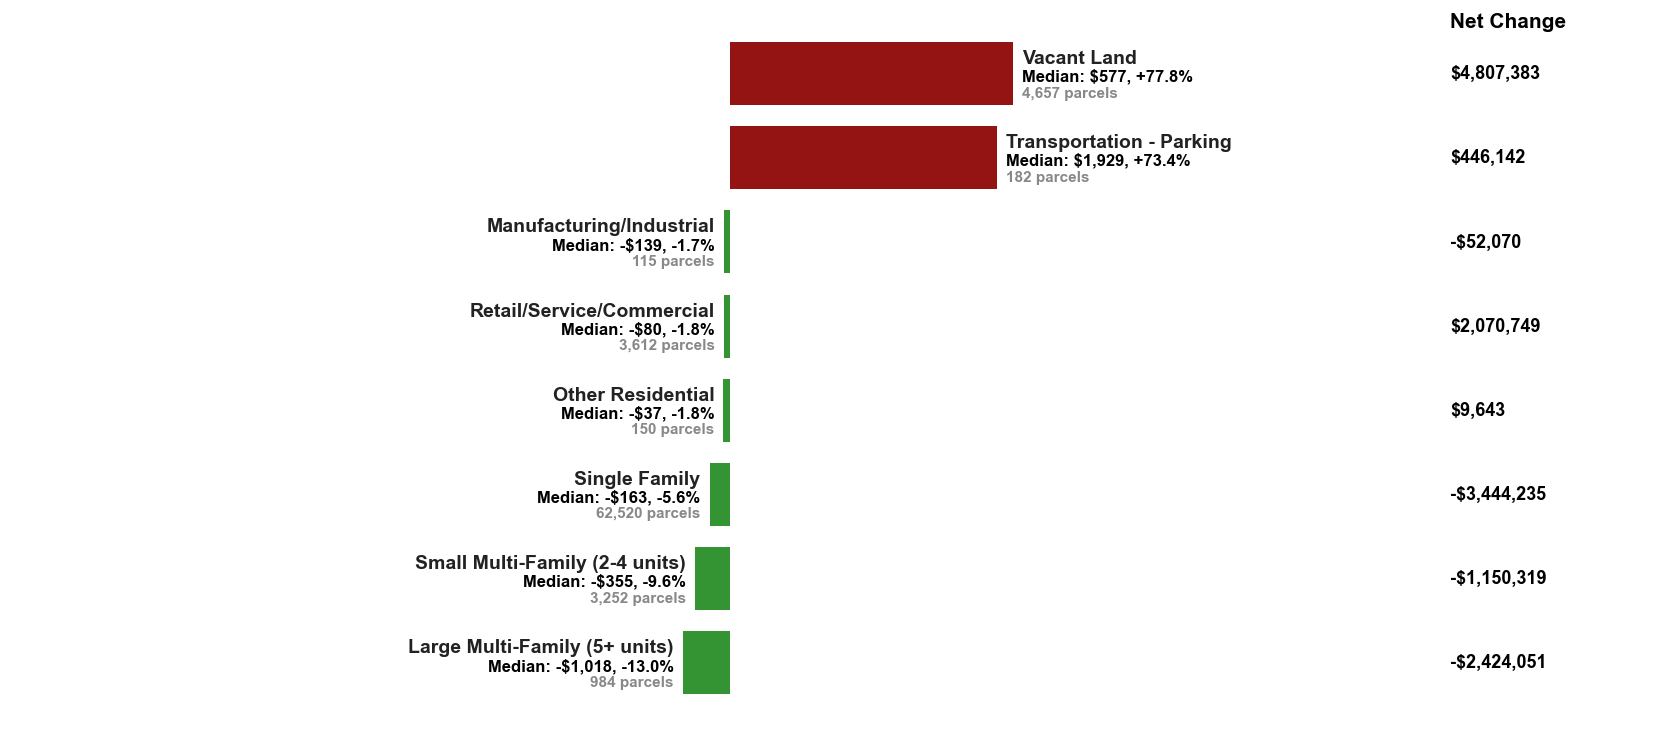

In [308]:
import matplotlib.pyplot as plt
import numpy as np

# Only include categories with property_count > 50
filtered = output_summary[output_summary['property_count'] > 50].copy()

categories = filtered['PROPERTY_CATEGORY'].tolist()
counts = filtered['property_count'].tolist()
median_pct_change = filtered['median_tax_change_pct'].tolist()
median_dollar_change = filtered['median_tax_change'].tolist()
total_tax_change = filtered['total_tax_change'].tolist() if 'total_tax_change' in filtered.columns else (filtered['mean_tax_change'] * filtered['property_count']).tolist()

# Sort by median_pct_change ascending
sorted_idx = np.argsort(median_pct_change)
categories = [categories[i] for i in sorted_idx]
counts = [counts[i] for i in sorted_idx]
median_pct_change = [median_pct_change[i] for i in sorted_idx]
median_dollar_change = [median_dollar_change[i] for i in sorted_idx]
total_tax_change = [total_tax_change[i] for i in sorted_idx]

# Custom color: anything above 0 is dark red, below 0 is green
bar_colors = []
for val in median_pct_change:
    if val > 0:
        bar_colors.append("#8B0000")  # dark red
    else:
        bar_colors.append("#228B22")  # professional green

# Bar settings
bar_height = 0.75
fig_height = len(categories) * 0.8 + 1.2
right_col_pad = 120  # more padding for right column
fig, ax = plt.subplots(figsize=(17, fig_height))  # wider for right column

y = np.arange(len(categories))

# Draw bars
ax.barh(
    y, median_pct_change, color=bar_colors, edgecolor='none',
    height=bar_height, alpha=0.92, linewidth=0, zorder=2
)

# Remove all spines and ticks for a clean look
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Adjusted vertical spacing
cat_offset = 0.18   # less space between category and median
med_offset = -0.03  # median just below category
count_offset = -0.23  # more space below median for parcels

# For right column: position for total tax change
max_abs = max(abs(min(median_pct_change)), abs(max(median_pct_change)))
right_col_x = max_abs + right_col_pad

# Add Net Change header at the top of the right column
ax.text(
    right_col_x, len(categories) - 0.5, "Net Change", va='bottom', ha='left',
    fontsize=15, fontweight='bold', color='black', fontname='Arial'
)

for i, (cat, val, count, med_dol, tot_change) in enumerate(zip(categories, median_pct_change, counts, median_dollar_change, total_tax_change)):
    # Format median dollar and percent change together
    if med_dol >= 0:
        med_dol_str = f"${med_dol:,.0f}"
    else:
        med_dol_str = f"-${abs(med_dol):,.0f}"
    pct_str = f"{val:+.1f}%"
    median_combo = f"Median: {med_dol_str}, {pct_str}"

    # Position: right of bar for positive, left for negative
    if val < 0:
        xpos = val - 2.5
        ha = 'right'
    else:
        xpos = val + 2.5
        ha = 'left'
    # Category name (bold, bigger)
    ax.text(
        xpos, y[i]+cat_offset, cat, va='center', ha=ha,
        fontsize=14, fontweight='bold', color='#222',
        fontname='Arial'
    )
    # Median (dollar + percent, bold, black, just below category)
    ax.text(
        xpos, y[i]+med_offset, median_combo, va='center', ha=ha,
        fontsize=12, fontweight='bold', color='black',
        fontname='Arial'
    )
    # Count (bold, smaller, below median)
    ax.text(
        xpos, y[i]+count_offset, f"{count:,} parcels", va='center', ha=ha,
        fontsize=11, fontweight='bold', color='#888',
        fontname='Arial'
    )
    # Net change column, always right-aligned in a new column, black text, no "Total:"
    if tot_change >= 0:
        tot_change_str = f"${tot_change:,.0f}"
    else:
        tot_change_str = f"-${abs(tot_change):,.0f}"
    ax.text(
        right_col_x, y[i], tot_change_str, va='center', ha='left',
        fontsize=13, fontweight='bold', color='black',
        fontname='Arial'
    )

# Set x limits for symmetry, make bars longer, and leave space for right column
ax.set_xlim(-right_col_x, right_col_x + 60)

# Remove axis labels/ticks
ax.set_yticks([])
ax.set_xticks([])

plt.tight_layout()
plt.show()


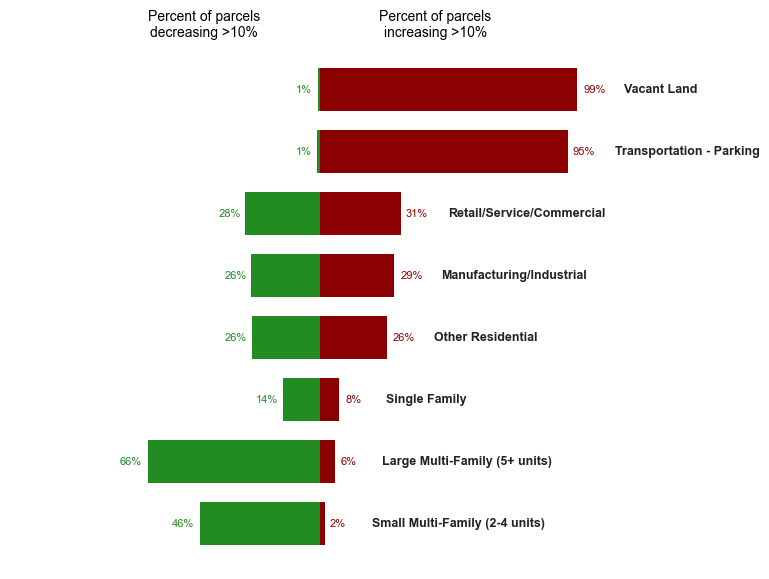

In [309]:
import matplotlib.pyplot as plt
import numpy as np

# Use output_summary to generate categories and percent increase/decrease, filtering to count > 50

# Filter to property_count > 50
summary_filtered = output_summary[output_summary['property_count'] > 50].copy()

# Sort by pct_increase_gt_threshold ascending (smallest percent increase first)
summary_sorted = summary_filtered.sort_values('pct_increase_gt_threshold', ascending=True)

categories_sorted = summary_sorted['PROPERTY_CATEGORY'].tolist()
pct_increase_sorted = summary_sorted['pct_increase_gt_threshold'].tolist()
pct_decrease_sorted = summary_sorted['pct_decrease_gt_threshold'].tolist()

# Convert to integers for display
pct_increase_int_sorted = [int(round(x)) for x in pct_increase_sorted]
pct_decrease_int_sorted = [int(round(x)) for x in pct_decrease_sorted]

y = np.arange(len(categories_sorted))

fig, ax = plt.subplots(figsize=(8, 6))

# Use specified colors
color_increase = "#8B0000"  # dark red
color_decrease = "#228B22"  # professional green

# Plot left (decrease) bars (green, to the left)
ax.barh(
    y, 
    [-v for v in pct_decrease_sorted], 
    color=color_decrease, 
    edgecolor='none', 
    height=0.7
)

# Plot right (increase) bars (red, to the right)
ax.barh(
    y, 
    pct_increase_sorted, 
    color=color_increase, 
    edgecolor='none', 
    height=0.7
)

# Add percent labels (integer, no decimals), smaller Arial font
for i, (inc, dec) in enumerate(zip(pct_increase_int_sorted, pct_decrease_int_sorted)):
    # Left side (decrease)
    if dec > 0:
        ax.text(
            -dec - 2, y[i], f"{dec}%", 
            va='center', ha='right', 
            fontsize=8, fontweight='normal', color=color_decrease, fontname='Arial'
        )
    # Right side (increase)
    if inc > 0:
        ax.text(
            inc + 2, y[i], f"{inc}%", 
            va='center', ha='left', 
            fontsize=8, fontweight='normal', color=color_increase, fontname='Arial'
        )

# Add category name at end of right bar, bold, smaller Arial, further from percent
for i, (cat, inc) in enumerate(zip(categories_sorted, pct_increase_sorted)):
    xpos = inc + 18 if inc > 0 else 18
    ax.text(
        xpos, y[i], cat, 
        va='center', ha='left', 
        fontsize=9, fontweight='bold', color='#222', fontname='Arial'
    )

# Remove all spines, ticks, and axis lines for minimalist look
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

# Remove grid, axis, and titles
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('')

# Set xlim for symmetry
max_val = max(max(pct_increase_sorted), max(pct_decrease_sorted))
ax.set_xlim(-max_val-20, max_val+48)

# --- Add custom titles above left and right bars ---
# Make the titles a little bit bigger and closer to the center
title_fontsize = 10  # increased from 8
title_color = 'black'
title_fontweight = 'normal'
title_fontname = 'Arial'

# Compute center x for both titles, but offset slightly left/right of center
title_y = len(categories_sorted) - 0.2

# Left title (above left bars), closer to center
left_title_x = -max_val * 0.45
ax.text(
    left_title_x, title_y, 
    "Percent of parcels\ndecreasing >10%", 
    ha='center', va='bottom', fontsize=title_fontsize, fontweight=title_fontweight, 
    color=title_color, fontname=title_fontname, 
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15')
)

# Right title (above right bars), closer to center
right_title_x = max_val * 0.45
ax.text(
    right_title_x, title_y, 
    "Percent of parcels\nincreasing >10%", 
    ha='center', va='bottom', fontsize=title_fontsize, fontweight=title_fontweight, 
    color=title_color, fontname=title_fontname, 
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.15')
)

plt.tight_layout()
plt.show()


## Step 5: Understanding Property Types and Impacts

With our split-rate tax calculated, we can now analyze which property types are most affected. Understanding the distribution of tax impacts across different property categories is crucial for policy makers and stakeholders.

### Property Type Analysis

We'll examine how the tax burden shifts across:
- **Residential properties** (single-family, multi-family, condos)
- **Commercial properties** (retail, office, industrial)  
- **Vacant land** (often sees largest increases under LVT)
- **Exempt properties** (government, religious, charitable)

### Key Metrics to Track:
- **Count**: Number of properties in each category
- **Median tax change**: Typical impact (less affected by outliers)
- **Average percentage change**: Overall magnitude of impact
- **Percentage with increases**: How many properties see tax increases

This analysis helps identify which sectors benefit from the LVT shift (typically developed properties) and which see increased burden (typically land-intensive properties with low improvement ratios).


In [310]:
df = df_b.copy()

### Creating Detailed Property Categories

To better understand impacts, we'll create a detailed property categorization system that groups similar property types together. This makes the analysis more meaningful and interpretable.

The function below categorizes properties into groups like:
- **Single Family** (with subcategories by lot size)
- **Multi-Family** (small vs. large)
- **Commercial** (by type: retail, office, industrial)
- **Exempt** (by type: government, religious, charitable)

This categorization helps us understand not just that "residential" properties are affected, but specifically which types of residential properties see the biggest changes.


In [311]:
display(df.head())


,OBJECTID,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry,full_exmp,total_millage,one_cap_millage,statute_millage,spokane_general_millage,total_spokane_boundaries_millage,sp_sd081_spokane_b&i,sp_sd081_spokane_general,sp_spokane_bond,sp_spokane_bond_new,sp_spokane_ems,sp_spokane_general,sp_spokane_general_senior_lift,over_590,over_one_percent,millage_rate,exmp_flag,current_tax,current_tax_full,sp_sd081_spokane_b&i_current_tax,sp_sd081_spokane_general_current_tax,sp_spokane_bond_current_tax,sp_spokane_bond_new_current_tax,sp_spokane_ems_current_tax,sp_spokane_general_current_tax,sp_spokane_general_senior_lift_current_tax,PROPERTY_CATEGORY,improvement_value,total_new_spokane_tax,total_new_spokane_millage,sp_sd081_spokane_b&i_new_tax,sp_sd081_spokane_b&i_new_millage,sp_sd081_spokane_general_new_tax,sp_sd081_spokane_general_new_millage,sp_spokane_bond_new_tax,sp_spokane_bond_new_millage,sp_spokane_bond_new_new_tax,sp_spokane_bond_new_new_millage,sp_spokane_ems_new_tax,sp_spokane_ems_new_millage,sp_spokane_general_new_tax,sp_spokane_general_new_millage,sp_spokane_general_senior_lift_new_tax,sp_spokane_general_senior_lift_new_millage,total_new_millage,new_tax,tax_change,new_tax_full,tax_change_pct
15092,15093,15361.1102,20210618,1.1102,15361.1102,None,0.0,544380,4438O,51,Wholesale,2025.0,11307 W MCFARLANE RD,11307.0,None,W,None,MCFARLANE,RD,None,SPOKANE,WA,99224,ID33,N,N,C,95,14.69,32159400.0,32159400.0,0057,5,15361.1102,959580.0,None,None,1.609459e+12,None,2026.0,Active-Complete,130240.406250,2094.862343,"POLYGON ((-117.56901 47.62471, -117.57151 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.9280,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.9280,0,94162.723200,317699.496660,NaN,NaN,NaN,7039.692660,16063.620300,64537.483920,6521.926320,Retail/Service/Commercial,31199820.0,166189.149466,0,26789.661093,3.064903,49872.777372,5.705755,2047.536106,0.234251,4839.049551,0.553617,15237.068624,0.92223,61216.715344,3.705166,6186.341375,0.374431,14.560353,166189.149466,72026.426266,389725.922926,22.671243
15093,15094,15361.1103,20210618,1.1103,15361.1103,None,0.0,544380,4438O,91,Vacant Land,2025.0,11401 W MCFARLANE RD,11401.0,None,W,None,MCFARLANE,RD,None,AIRWAY HEIGHTS,WA,None,ID33,N,Y,C,95,4.20,274190.0,274190.0,0057,5,15361.1103,274190.0,None,None,1.609459e+12,None,2026.0,Active-Complete,37368.937500,787.394358,"POLYGON ((-117.57139 47.62828, -117.56929 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.9280,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.9280,0,802.828320,2708.695591,NaN,NaN,NaN,60.020191,136.957905,550.244492,55.605732,Vacant Land,0.0,3992.303125,0,840.365845,3.064903,1564.460953,5.705755,64.229234,0.234251,151.796320,0.553617,252.866141,0.92223,1015.919461,3.705166,102.665172,0.374431,14.560353,3992.303125,3189.474805,5898.170396,117.749474
15094,15095,15361.9023,,1.9023,15361.9023,None,0.0,545580,4558O,55,Retail - Auto,2025.0,11019 W MCFARLANE RD,11019.0,None,W,None,MCFARLANE,RD,None,SPOKANE,WA,99224,ID35,N,N,C,122,33.08,1570420.0,1570420.0,0057,5,15361.9023,1080720.0,None,None,3.155328e+11,None,2026.0,Active-Complete,297607.976562,2375.624334,"POLYGON ((-117.56901 47.62471, -117.56899 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.9280,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.9280,0,4598.189760,15514.022138,NaN,NaN,NaN,343.764938,784.424790,3151.518856,318.481176,Retail/Service/Commercial,489700.0,17763.773366,0,3630.056185,3.064903,6757.867646,5.705755,277.445507,0.234251,655.701529,0.553617,1187.896312,0.92223,4772.513150,3.705166,482.293

In [312]:
print(spokane_levy_cols)

['sp_sd081_spokane_b&i', 'sp_sd081_spokane_general', 'sp_spokane_bond', 'sp_spokane_bond_new', 'sp_spokane_ems', 'sp_spokane_general', 'sp_spokane_general_senior_lift']


In [313]:
# Report the min, median, and max of total_new_spokane_millage, and compare to current rates
min_millage = df['total_new_millage'].min()
median_millage = df['total_new_millage'].median()
max_millage = df['total_new_millage'].max()

print(f"total_new_spokane_millage statistics:")
print(f"  Min:    {min_millage:.4f}")
print(f"  Median: {median_millage:.4f}")
print(f"  Max:    {max_millage:.4f}")

# Compare to current millage rates using columns in df
if 'millage_rate' in df.columns:
    current_millage_rate = df['millage_rate'].iloc[0]
else:
    current_millage_rate = float('nan')
if 'one_cap_millage' in df.columns:
    one_cap_millage = df['one_cap_millage'].iloc[0]
else:
    one_cap_millage = float('nan')
if 'statute_millage' in df.columns:
    statute_millage = df['statute_millage'].iloc[0]
else:
    statute_millage = float('nan')

print("\nComparison to current rates:")
print(f"  Current millage rate:      {current_millage_rate:.4f}")
print(f"  One percent cap millage:   {one_cap_millage:.4f}")
print(f"  Statute max millage:       {statute_millage:.4f}")

# --- New logic for difference and new millages ---

# Identify the three Spokane millages
levies_of_interest = [
    'sp_spokane_ems',
    'sp_spokane_general',
    'sp_spokane_general_senior_lift'
]

# --- Calculate total current and new millages for one cap and statute ---

# For one cap: sum all three current and new
current_one_cap_sum = df[levies_of_interest].fillna(0).sum(axis=1)
new_one_cap_cols = [levy + '_new_millage' for levy in levies_of_interest]
# Only use columns that exist
new_one_cap_cols = [col for col in new_one_cap_cols if col in df.columns]
new_one_cap_sum = df[new_one_cap_cols].fillna(0).sum(axis=1)
one_cap_millage_diff = new_one_cap_sum - current_one_cap_sum

df['one_cap_millage_new'] = one_cap_millage_diff + df['one_cap_millage']

# For statute: sum only general and general_senior_lift (not EMS)
statute_levies = ['sp_spokane_general', 'sp_spokane_general_senior_lift']
current_statute_sum = df[statute_levies].fillna(0).sum(axis=1)
new_statute_cols = [levy + '_new_millage' for levy in statute_levies]
new_statute_cols = [col for col in new_statute_cols if col in df.columns]
new_statute_sum = df[new_statute_cols].fillna(0).sum(axis=1)
statute_millage_diff = new_statute_sum - current_statute_sum
print("Current statute sum median:", current_statute_sum.median())
print("Current statute sum max:", current_statute_sum.max())
print("New statute sum median:", new_statute_sum.median())
print("New statute sum max:", new_statute_sum.max())

df['statute_millage_new'] = statute_millage_diff + df['statute_millage']

print("\nStatute millage (statute_millage) statistics:")
print(f"  Median: {df['statute_millage'].median():.4f}")
print(f"  Max:    {df['statute_millage'].max():.4f}")


# Print percent of parcels where new one cap millage > 10
pct_one_cap_gt_10 = (df['one_cap_millage_new'] > 10).mean() * 100
print(f"\nPercent of parcels where new one cap millage > 10: {pct_one_cap_gt_10:.2f}%")

# Print percent of parcels where new statute millage > 5.90
pct_statute_gt_590 = (df['statute_millage_new'] > 5.90).mean() * 100
print(f"Percent of parcels where new statute millage > 5.90: {pct_statute_gt_590:.2f}%")

# Print min, median, and max of new one cap millage
min_one_cap = df['one_cap_millage_new'].min()
median_one_cap = df['one_cap_millage_new'].median()
max_one_cap = df['one_cap_millage_new'].max()
print("\none_cap_millage_new statistics:")
print(f"  Min:    {min_one_cap:.4f}")
print(f"  Median: {median_one_cap:.4f}")
print(f"  Max:    {max_one_cap:.4f}")

# Print min, median, and max of new statute millage
min_statute = df['statute_millage_new'].min()
median_statute = df['statute_millage_new'].median()
max_statute = df['statute_millage_new'].max()
print("\nstatute_millage_new statistics:")
print(f"  Min:    {min_statute:.4f}")
print(f"  Median: {median_statute:.4f}")
print(f"  Max:    {max_statute:.4f}")

# --- Additional: Add together the two statute levies and report percent exceeding 3.375 (the 3.375 rule) ---
if all(col in df.columns for col in new_statute_cols):
    df['statute_levies_sum_new'] = df[new_statute_cols].fillna(0).sum(axis=1)
    pct_statute_levies_gt_3375 = (df['statute_levies_sum_new'] > 3.375).mean() * 100
    median_statute_levies_sum = df['statute_levies_sum_new'].median()
    max_statute_levies_sum = df['statute_levies_sum_new'].max()
    print(f"\nPercent of parcels where the sum of new statute levies (general + general_senior_lift) > 3.375 (the 3.375 rule): {pct_statute_levies_gt_3375:.2f}%")
    print(f"Median sum of new statute levies: {median_statute_levies_sum:.4f}")
    print(f"Max sum of new statute levies: {max_statute_levies_sum:.4f}")
else:
    print("\nCould not compute 3.375 rule: one or both statute levy columns missing.")


total_new_spokane_millage statistics:
  Min:    14.5604
  Median: 14.5604
  Max:    14.5604

Comparison to current rates:
  Current millage rate:      2.9280
  One percent cap millage:   5.7371
  Statute max millage:       2.9185
Current statute sum median: 2.2096
Current statute sum max: 2.2096
New statute sum median: 4.079596750699895
New statute sum max: 4.079596750699895

Statute millage (statute_millage) statistics:
  Median: 2.9185
  Max:    2.9270

Percent of parcels where new one cap millage > 10: 0.00%
Percent of parcels where new statute millage > 5.90: 0.00%

one_cap_millage_new statistics:
  Min:    8.0298
  Median: 8.0298
  Max:    8.0383

statute_millage_new statistics:
  Min:    4.7885
  Median: 4.7885
  Max:    4.7970

Percent of parcels where the sum of new statute levies (general + general_senior_lift) > 3.375 (the 3.375 rule): 100.00%
Median sum of new statute levies: 4.0796
Max sum of new statute levies: 4.0796


### Summary of Tax Impacts by Property Category

Now we can see the clear patterns of how different property types are affected by the LVT shift. This table will show us:

- **Which property types benefit** (negative changes = tax decreases)
- **Which property types pay more** (positive changes = tax increases)  
- **How concentrated the impacts are** (median vs. average differences)
- **What percentage of each type sees increases**

Generally, we expect:
- **Developed properties** (houses, commercial buildings) to see tax **decreases**
- **Vacant land** to see the **largest increases** 
- **Properties with high improvement-to-land ratios** to benefit most


## Step 6: Adding Geographic Context

To make our analysis spatially-aware, we need to add geographic boundaries to our parcel data. This enables us to:

- **Create maps** showing tax changes across the city
- **Analyze patterns by neighborhood** or district  
- **Combine with demographic data** for equity analysis
- **Present results visually** to stakeholders

We'll fetch the parcel boundary data from the same ArcGIS service that contains the geometric information for each property.


### Merging Tax Analysis with Geographic Data

Here we combine our tax analysis results with the geographic boundaries. This creates a spatially-enabled dataset that allows us to:

1. **Map tax changes** across South Bend
2. **Identify spatial patterns** in tax impacts
3. **Prepare for demographic analysis** by having geographic context

The merge should give us the same number of records as our original analysis, now with geographic coordinates for each parcel.


In [314]:
# Get census data for Spokane County (FIPS code: 53063)
census_data, census_boundaries = get_census_data_with_boundaries(
    fips_code='53063',  # Washington (53) + Spokane County (063)
    year=2022
)
# Set CRS for census boundaries before merging
census_boundaries = census_boundaries.set_crs(epsg=4326)  # Assuming WGS84 coordinate system
boundary_gdf = df.set_crs(epsg=4326)  # Set same CRS for boundary data

# Merge census data with our parcel boundaries
df = match_to_census_blockgroups(
    gdf=boundary_gdf,
    census_gdf=census_boundaries,
    join_type="left"
)

print(f"Number of census blocks: {len(census_boundaries)}")
print(f"Number of census data: {len(census_data)}")
print(f"Number of parcels with census data: {len(df)}")

Number of census blocks: 13689
Number of census data: 371
Number of parcels with census data: 75527


## Step 7: Demographic and Equity Analysis

One of the most important aspects of LVT analysis is understanding the **equity implications** - how does the tax shift affect different income levels and demographic groups?

### Adding Census Data

We'll match each property to its Census Block Group and pull demographic data including:
- **Median household income** 
- **Racial/ethnic composition**
- **Population characteristics**

### Why This Matters

Policy makers need to understand:
- Does the LVT shift disproportionately burden low-income neighborhoods?
- Are there racial equity implications?  
- Does the policy align with broader equity goals?

**Note**: You'll need a Census API key for this section. Get one free at: https://api.census.gov/data/key_signup.html


In [315]:
print("DataFrame columns:")
print(df.columns.tolist())


DataFrame columns:
['OBJECTID_left', 'PID_NUM', 'ACO_NUM', 'PIDMAP', 'parcel', 'exmp_code', 'exmp_amt', 'nbhd_code', 'nbhd_name', 'prop_use_code', 'prop_use_desc', 'tax_year', 'site_address', 'site_str_nbr', 'site_str_nbr_suf', 'site_str_dir', 'site_str_dir_suf', 'site_str_name', 'site_str_type', 'site_apartment', 'site_city', 'site_state', 'site_zip', 'soil_id', 'bldg_only_flag', 'vacant_land_flag', 'res_com_flag', 'appraiser_id', 'acreage', 'assessed_amt', 'taxable_amt', 'tax_code_area', 'inspection_cycle', 'parcel_location', 'land_value', 'asmt_year_exmp_code', 'asmt_year_exmp_amt', 'eff_from_date', 'eff_to_date', 'asmt_year', 'seg_status', 'Shape__Area', 'Shape__Length', 'geometry', 'full_exmp', 'total_millage', 'one_cap_millage', 'statute_millage', 'spokane_general_millage', 'total_spokane_boundaries_millage', 'sp_sd081_spokane_b&i', 'sp_sd081_spokane_general', 'sp_spokane_bond', 'sp_spokane_bond_new', 'sp_spokane_ems', 'sp_spokane_general', 'sp_spokane_general_senior_lift', 'over

### Exploring the Enhanced Dataset

With census data merged in, our dataset now contains both property tax information and demographic context. Let's explore what variables we now have available for analysis.

This enhanced dataset allows us to examine relationships between:
- Property characteristics and demographics
- Tax impacts and neighborhood income levels
- Geographic patterns in tax burden shifts


In [316]:
# Display all columns with maximum width
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(df.head())


,OBJECTID_left,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry,full_exmp,total_millage,one_cap_millage,statute_millage,spokane_general_millage,total_spokane_boundaries_millage,sp_sd081_spokane_b&i,sp_sd081_spokane_general,sp_spokane_bond,sp_spokane_bond_new,sp_spokane_ems,sp_spokane_general,sp_spokane_general_senior_lift,over_590,over_one_percent,millage_rate,exmp_flag,current_tax,current_tax_full,sp_sd081_spokane_b&i_current_tax,sp_sd081_spokane_general_current_tax,sp_spokane_bond_current_tax,sp_spokane_bond_new_current_tax,sp_spokane_ems_current_tax,sp_spokane_general_current_tax,sp_spokane_general_senior_lift_current_tax,PROPERTY_CATEGORY,improvement_value,total_new_spokane_tax,total_new_spokane_millage,sp_sd081_spokane_b&i_new_tax,sp_sd081_spokane_b&i_new_millage,sp_sd081_spokane_general_new_tax,sp_sd081_spokane_general_new_millage,sp_spokane_bond_new_tax,sp_spokane_bond_new_millage,sp_spokane_bond_new_new_tax,sp_spokane_bond_new_new_millage,sp_spokane_ems_new_tax,sp_spokane_ems_new_millage,sp_spokane_general_new_tax,sp_spokane_general_new_millage,sp_spokane_general_senior_lift_new_tax,sp_spokane_general_senior_lift_new_millage,total_new_millage,new_tax,tax_change,new_tax_full,tax_change_pct,one_cap_millage_new,statute_millage_new,statute_levies_sum_new,OID,STATE,COUNTY,TRACT,BLKGRP,BLOCK,SUFFIX,GEOID,LWBLKTYP,UR,AREAWATER,AREALAND,MTFCC,NAME,BASENAME,LSADC,FUNCSTAT,CENTLON,CENTLAT,INTPTLON,INTPTLAT,HU100,POP100,OBJECTID_right,state_fips,county_fips,tract_fips,bg_fips,std_geoid,median_income,total_pop,white_pop,black_pop,hispanic_pop,state,county,tract,census_block_group,minority_pct,black_pct
15092,15093,15361.1102,20210618,1.1102,15361.1102,None,0.0,544380,4438O,51,Wholesale,2025.0,11307 W MCFARLANE RD,11307.0,None,W,None,MCFARLANE,RD,None,SPOKANE,WA,99224,ID33,N,N,C,95,14.69,32159400.0,32159400.0,0057,5,15361.1102,959580.0,None,None,1.609459e+12,None,2026.0,Active-Complete,130240.406250,2094.862343,"POLYGON ((-117.56901 47.62471, -117.57151 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.9280,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.9280,0,94162.723200,317699.496660,NaN,NaN,NaN,7039.692660,16063.620300,64537.483920,6521.926320,Retail/Service/Commercial,31199820.0,166189.149466,0,26789.661093,3.064903,49872.777372,5.705755,2047.536106,0.234251,4839.049551,0.553617,15237.068624,0.92223,61216.715344,3.705166,6186.341375,0.374431,14.560353,166189.149466,72026.426266,389725.922926,22.671243,8.029826,4.788497,4.079597,210701008225245,53,063,010401,1,1035,None,530630104011035,L,R,0,2972274,G5040,Block 1035,1035,BK,S,-117.5736778,+47.6204595,-117.5736778,+47.6204595,0,0,741466,53,063,010401,1,530630104011,41555.0,774.0,702.0,0.0,0.0,53,063,010401,1,9.30,0.0
15093,15094,15361.1103,20210618,1.1103,15361.1103,None,0.0,544380,4438O,91,Vacant Land,2025.0,11401 W MCFARLANE RD,11401.0,None,W,None,MCFARLANE,RD,None,AIRWAY HEIGHTS,WA,None,ID33,N,Y,C,95,4.20,274190.0,274190.0,0057,5,15361.1103,274190.0,None,None,1.609459e+12,None,2026.0,Active-Complete,37368.937500,787.394358,"POLYGON ((-117.57139 47.62828, -117.56929 47.6...",0,9.8789,5.7371,2.9185,2.0068,2.9280,NaN,NaN,NaN,0.2189,0.4995,2.0068,0.2028,False,False,2.9280,0,802.828320,2708.695591,NaN,NaN,NaN,60.020191,136.957905,550.244492,55.605732,Vacant Land,0.0,3992.303125,0,840.365845,3.064903,1564.460953,5.705755,64.229234,0.234251,151.796320,0.553617,252.866141,0.92223,1015.919461,3.705166,102.665172,0.374431,14.560353,3992.303125,3189.474805,5898.170396,117.749474,8.029826,4.788497,4.079597,21070100822

### Viewing the Complete Dataset

Let's examine our enhanced dataset with all the variables we've created and merged. This gives us a comprehensive view of each property with:

- **Property characteristics** (type, value, location)
- **Current tax calculations** 
- **New LVT calculations**
- **Tax change impacts**
- **Demographic context** (income, race/ethnicity)

This rich dataset forms the foundation for sophisticated equity and impact analysis.


Number of rows in gdf_filtered: 73861
Number of rows in non_vacant_gdf: 69341


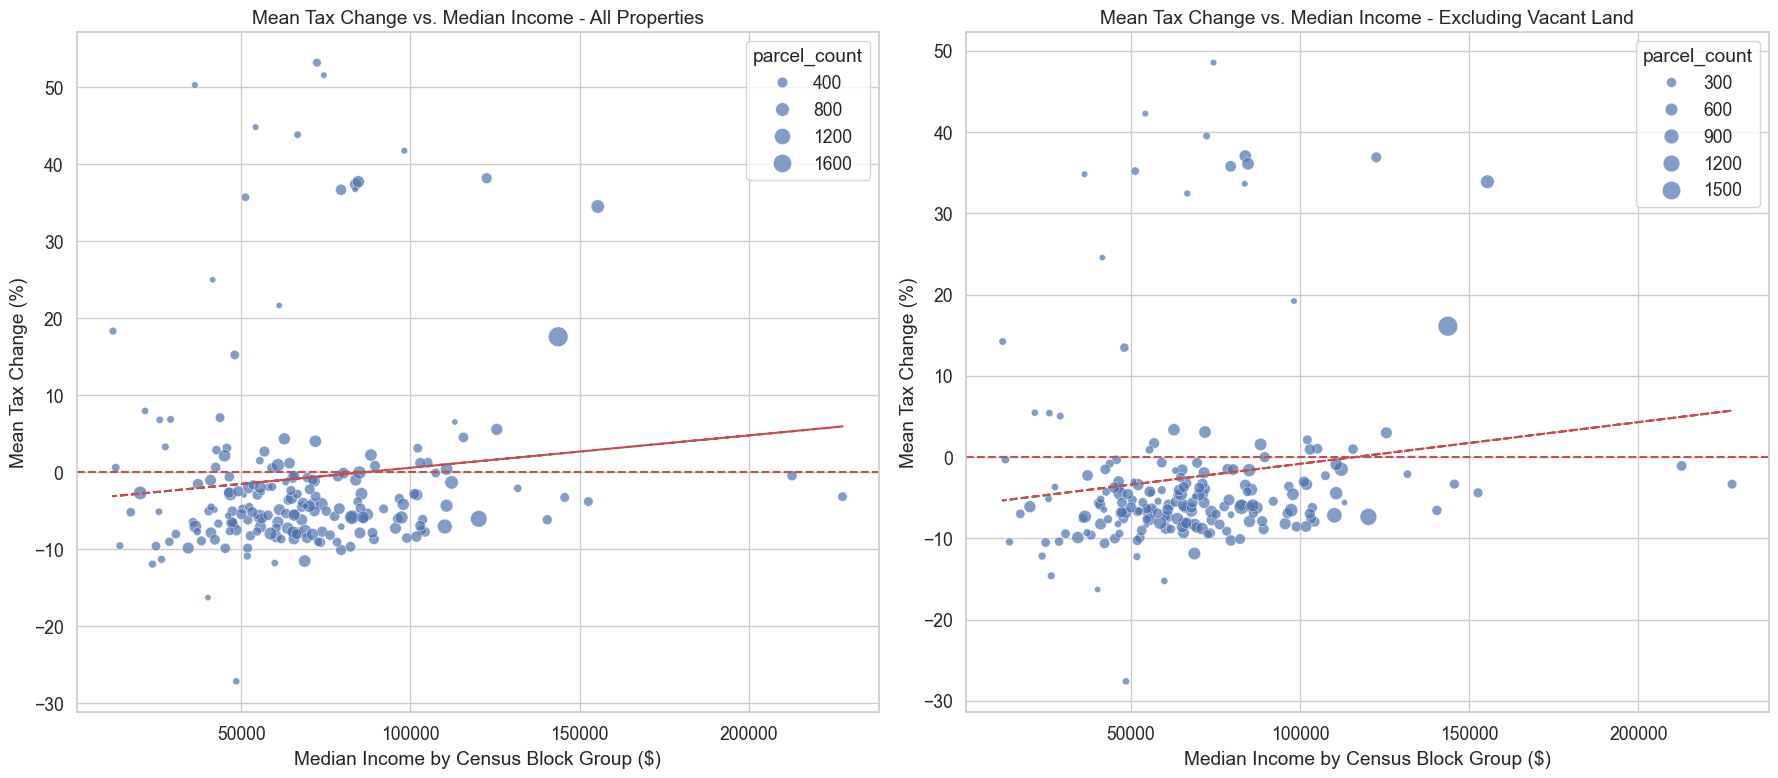

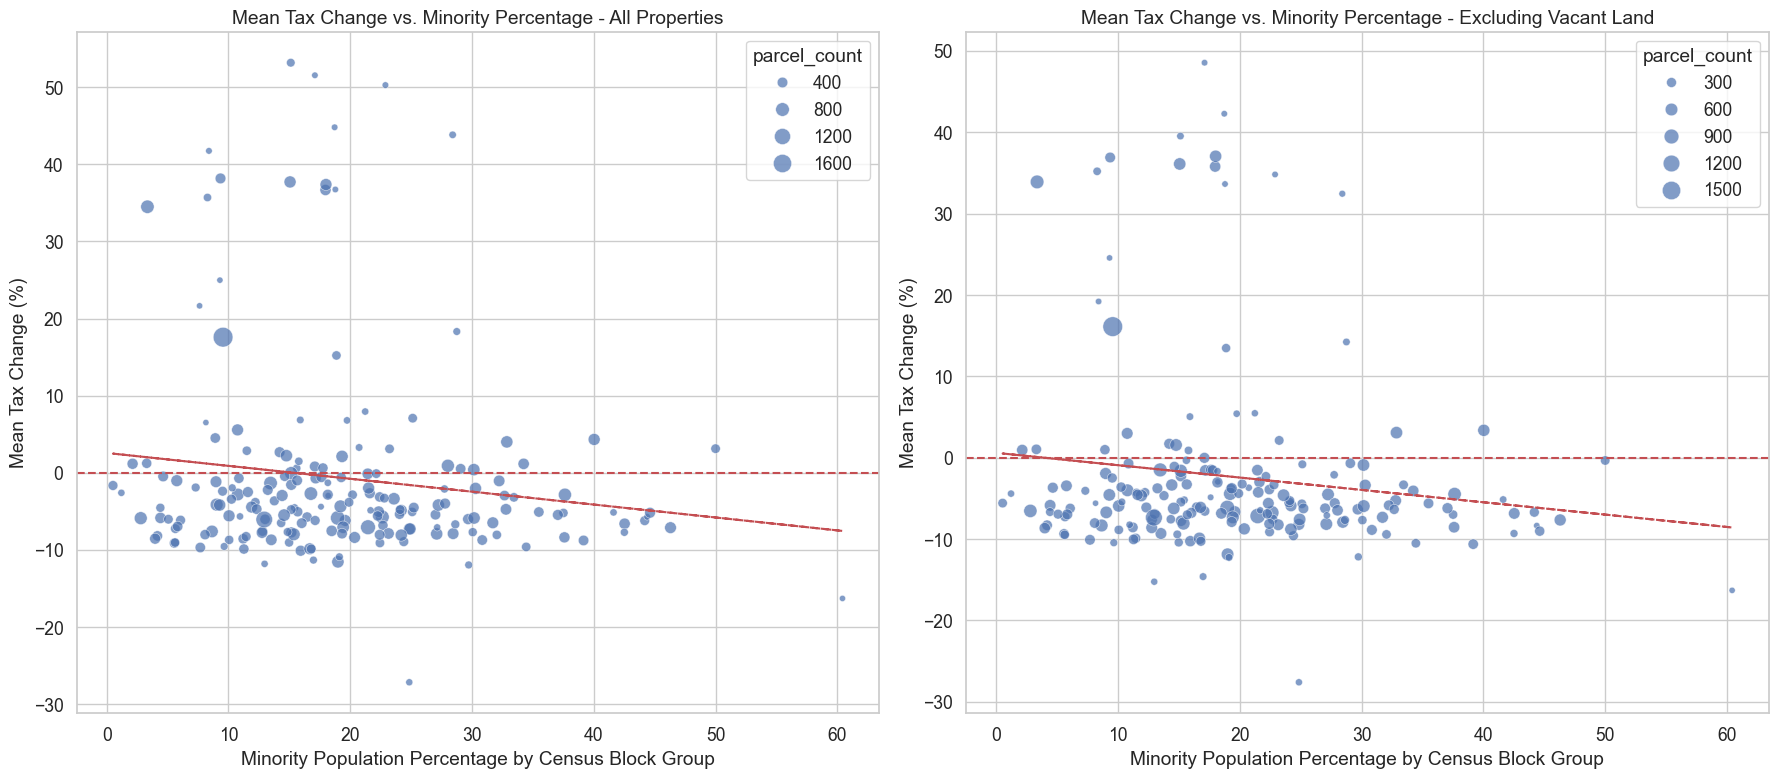

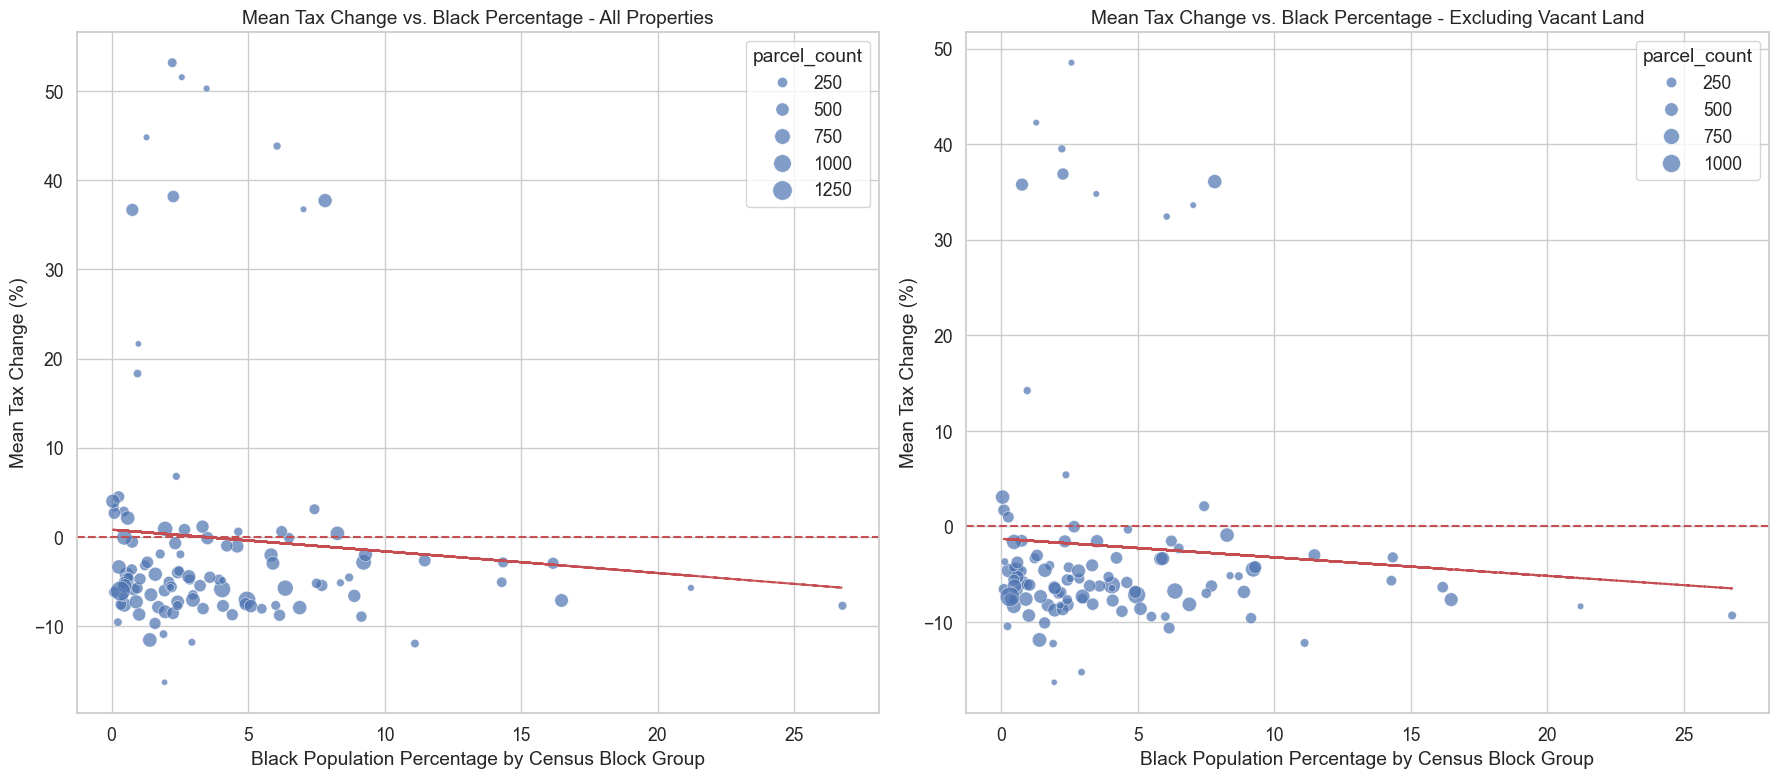

Correlation income_mean_all: 0.1022
Correlation income_median_all: 0.0239
Correlation minority_mean_all: -0.1294
Correlation black_mean_all: -0.0296
Correlation income_mean_non_vacant: 0.1389
Correlation income_median_non_vacant: 0.0840
Correlation minority_mean_non_vacant: -0.1310
Correlation black_mean_non_vacant: -0.0325


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').apply(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby(f'{group_col}_quintile').apply(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: FutureWarning: The default of observed=False is deprecated and 


Tax impact by income quintile (all properties):


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby(f'{group_col}_quintile').apply(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').apply(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grou

,median_income_quintile,count,mean_tax_change_pct,median_tax_change_pct,mean_value
0,Q1 (Lowest),14877.0,1.808981,-5.603890,39714.705855
1,Q2,15157.0,-0.917030,-5.889000,58830.318071
2,Q3,14514.0,-4.006447,-6.250816,69980.685545
3,Q4,14772.0,0.314802,-5.261524,86363.574465
4,Q5 (Highest),14541.0,4.054448,-3.311245,123711.778007



Tax impact by income quintile (excluding vacant land):


,median_income_quintile,count,mean_tax_change_pct,median_tax_change_pct,mean_value
0,Q1 (Lowest),14157.0,-5.898613,-6.402617,40635.079890
1,Q2,14049.0,-8.017711,-6.493052,59660.101288
2,Q3,13656.0,-8.112335,-6.255627,70635.036028
3,Q4,13912.0,-2.603890,-5.649961,87113.489505
4,Q5 (Highest),13567.0,0.897975,-3.477291,124249.879413



Tax impact by minority percentage quintile (all properties):


,minority_pct_quintile,count,mean_tax_change_pct,median_tax_change_pct,mean_value
0,Q1 (Lowest),14822.0,3.297546,-4.953218,6.551183
1,Q2,15049.0,0.431786,-4.617617,13.120068
2,Q3,14470.0,1.414584,-5.704813,17.638800
3,Q4,14853.0,-4.094016,-5.907908,23.354814
4,Q5 (Highest),14667.0,0.234161,-5.445360,34.530079



Tax impact by minority percentage quintile (excluding vacant land):


,minority_pct_quintile,count,mean_tax_change_pct,median_tax_change_pct,mean_value
0,Q1 (Lowest),14057.0,-1.074402,-5.306291,6.520837
1,Q2,14183.0,-4.417942,-5.048818,13.112072
2,Q3,13581.0,-3.257760,-6.096252,17.634582
3,Q4,13936.0,-8.402958,-6.236036,23.323176
4,Q5 (Highest),13584.0,-6.762532,-5.955426,34.554146


In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def filter_data(df):
    """Filter data to remove negative or zero median incomes and create non-vacant subset (also with positive income)"""
    df_filtered = df[df['median_income'] > 0].copy()
    non_vacant_df = df[(df['PROPERTY_CATEGORY'] != 'Vacant Land') & (df['median_income'] > 0)].copy()
    return df_filtered, non_vacant_df

def calculate_block_group_summary(df):
    """Calculate summary statistics for census block groups, excluding negative/zero median incomes"""
    # Only include block groups with positive median income
    df = df[df['median_income'] > 0].copy()
    summary = df.groupby('std_geoid').agg(
        median_income=('median_income', 'first'),
        minority_pct=('minority_pct', 'first'),
        black_pct=('black_pct', 'first'),
        total_current_tax=('current_tax_full', 'sum'),
        total_new_tax=('new_tax_full', 'sum'),
        mean_tax_change=('tax_change', 'mean'),
        median_tax_change=('tax_change', 'median'),
        median_tax_change_pct=('tax_change_pct', 'median'),
        parcel_count=('tax_change', 'count'),
        has_vacant_land=('PROPERTY_CATEGORY', lambda x: 'Vacant Land' in x.values)
    ).reset_index()
    # Exclude block groups with non-positive median income (shouldn't be needed, but for safety)
    summary = summary[summary['median_income'] > 0].copy()
    summary['mean_tax_change_pct'] = ((summary['total_new_tax'] - summary['total_current_tax']) / 
                                    summary['total_current_tax']) * 100
    return summary

def create_scatter_plot(data, x_col, y_col, ax, title, xlabel, ylabel):
    """Create a scatter plot with trend line, excluding negative/zero incomes"""
    # Exclude rows with non-positive x_col (e.g., median_income)
    data = data[data[x_col] > 0].copy()
    sns.scatterplot(
        data=data,
        x=x_col,
        y=y_col,
        size='parcel_count',
        sizes=(20, 200),
        alpha=0.7,
        ax=ax
    )
    
    ax.axhline(y=0, color='r', linestyle='--')
    
    x = data[x_col].dropna()
    y = data[y_col].dropna()
    mask = ~np.isnan(x) & ~np.isnan(y)
    
    if len(x[mask]) > 1:
        z = np.polyfit(x[mask], y[mask], 1)
        p = np.poly1d(z)
        ax.plot(x[mask], p(x[mask]), "r--")
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

def plot_comparison(data1, data2, x_col, y_col, title_prefix, xlabel):
    """Create side-by-side comparison plots, excluding negative/zero incomes"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    create_scatter_plot(data1, x_col, y_col, ax1, 
                       f'{title_prefix} - All Properties', xlabel, 'Mean Tax Change (%)')
    create_scatter_plot(data2, x_col, y_col, ax2,
                       f'{title_prefix} - Excluding Vacant Land', xlabel, 'Mean Tax Change (%)')
    
    plt.tight_layout()
    plt.show()

def calculate_correlations(data1, data2):
    """Calculate correlations between variables, excluding negative/zero incomes"""
    correlations = {}
    for df, suffix in [(data1, 'all'), (data2, 'non_vacant')]:
        # Exclude rows with non-positive median_income for correlation
        df_corr = df[df['median_income'] > 0].copy()
        correlations[f'income_mean_{suffix}'] = df_corr[['median_income', 'mean_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'income_median_{suffix}'] = df_corr[['median_income', 'median_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'minority_mean_{suffix}'] = df_corr[['minority_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]
        correlations[f'black_mean_{suffix}'] = df_corr[['black_pct', 'mean_tax_change_pct']].corr().iloc[0, 1]
    return correlations

def weighted_median(values, weights):
    """Compute the weighted median of values with corresponding weights."""
    # Remove NaNs
    mask = (~np.isnan(values)) & (~np.isnan(weights))
    values = np.array(values)[mask]
    weights = np.array(weights)[mask]
    if len(values) == 0:
        return np.nan
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]
    cumsum = np.cumsum(weights)
    cutoff = weights.sum() / 2.0
    return values[np.searchsorted(cumsum, cutoff)]

def create_quintile_summary(df, group_col, value_col):
    """Create summary statistics by quintiles, using mean/weighted-median tax change percent, excluding negative/zero incomes for income-based quintiles"""
    # If grouping by income, exclude non-positive values
    if group_col == 'median_income':
        df = df[df['median_income'] > 0].copy()
    df[f'{group_col}_quintile'] = pd.qcut(df[group_col], 5, 
                                         labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])
    
    def weighted_median_tax_change_pct(subdf):
        # Use parcel_count as weights if available, else weight each row equally
        if 'parcel_count' in subdf.columns:
            weights = subdf['parcel_count']
        else:
            weights = np.ones(len(subdf))
        return weighted_median(subdf['tax_change_pct'], weights)
    
    # For this context, each row is a parcel, so weight by 1 (or by parcel_count if already aggregated)
    summary = df.groupby(f'{group_col}_quintile').apply(
        lambda g: pd.Series({
            'count': g['tax_change'].count(),
            'mean_tax_change_pct': g['tax_change_pct'].mean(),
            'median_tax_change_pct': weighted_median(g['tax_change_pct'], np.ones(len(g))),
            'mean_value': g[value_col].mean()
        })
    ).reset_index()
    
    return summary

# Main execution
gdf_filtered, non_vacant_gdf = filter_data(df)
print(f"Number of rows in gdf_filtered: {len(gdf_filtered)}")
print(f"Number of rows in non_vacant_gdf: {len(non_vacant_gdf)}")

# Calculate block group summaries (all with positive median_income only)
census_block_groups = calculate_block_group_summary(gdf_filtered)
non_vacant_block_summary = calculate_block_group_summary(non_vacant_gdf)

# Create comparison plots (all with positive median_income only)
plot_comparison(census_block_groups, non_vacant_block_summary, 
               'median_income', 'mean_tax_change_pct', 
               'Mean Tax Change vs. Median Income', 
               'Median Income by Census Block Group ($)')

plot_comparison(census_block_groups, non_vacant_block_summary,
               'minority_pct', 'mean_tax_change_pct',
               'Mean Tax Change vs. Minority Percentage',
               'Minority Population Percentage by Census Block Group')

plot_comparison(census_block_groups, non_vacant_block_summary,
               'black_pct', 'mean_tax_change_pct',
               'Mean Tax Change vs. Black Percentage',
               'Black Population Percentage by Census Block Group')

# Calculate and print correlations (all with positive median_income only)
correlations = calculate_correlations(census_block_groups, non_vacant_block_summary)
for key, value in correlations.items():
    print(f"Correlation {key}: {value:.4f}")

# Create and display quintile summaries (income quintiles exclude negative/zero incomes)
income_quintile_summary = create_quintile_summary(gdf_filtered, 'median_income', 'median_income')
non_vacant_income_quintile_summary = create_quintile_summary(non_vacant_gdf, 'median_income', 'median_income')
minority_quintile_summary = create_quintile_summary(gdf_filtered, 'minority_pct', 'minority_pct')
non_vacant_minority_quintile_summary = create_quintile_summary(non_vacant_gdf, 'minority_pct', 'minority_pct')

print("\nTax impact by income quintile (all properties):")
display(income_quintile_summary)
print("\nTax impact by income quintile (excluding vacant land):")
display(non_vacant_income_quintile_summary)
print("\nTax impact by minority percentage quintile (all properties):")
display(minority_quintile_summary)
print("\nTax impact by minority percentage quintile (excluding vacant land):")
display(non_vacant_minority_quintile_summary)


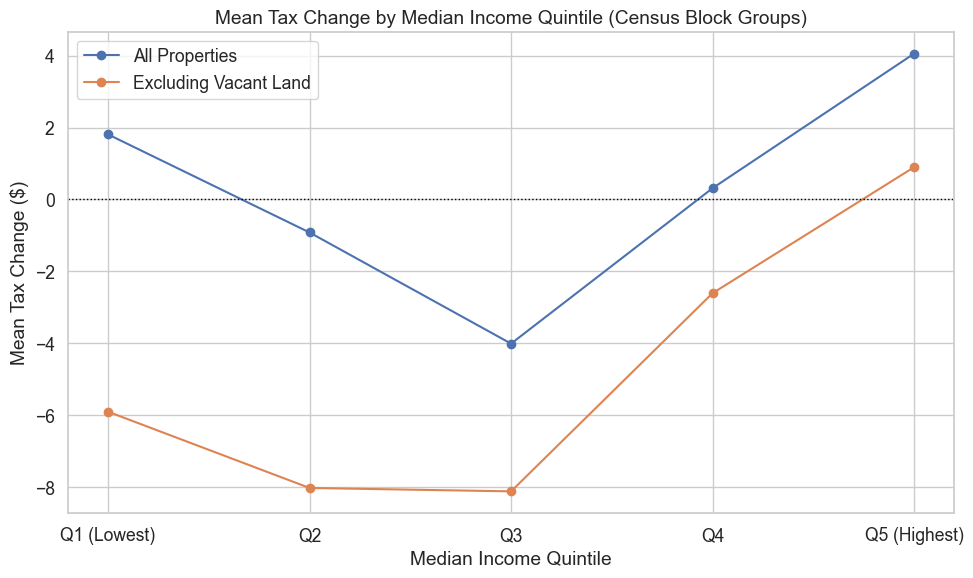

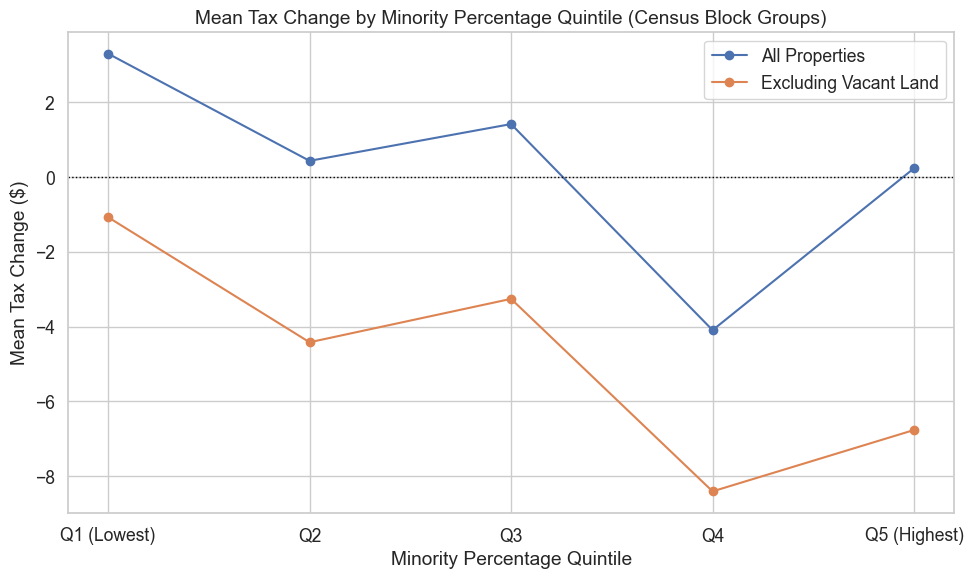

In [318]:
# Plot 1: Median Income Quintiles vs. Mean Tax Change Percent (Census Block Groups)

plt.figure(figsize=(10, 6))
plt.plot(
    income_quintile_summary['median_income_quintile'],
    income_quintile_summary['mean_tax_change_pct'],
    marker='o',
    label='All Properties'
)
plt.plot(
    non_vacant_income_quintile_summary['median_income_quintile'],
    non_vacant_income_quintile_summary['mean_tax_change_pct'],
    marker='o',
    label='Excluding Vacant Land'
)
plt.xlabel('Median Income Quintile')
plt.ylabel('Mean Tax Change ($)')
plt.title('Mean Tax Change by Median Income Quintile (Census Block Groups)')
plt.legend()
# Remove grid
# Ensure x-axis at y=0 if negative values present
ymin = min(
    income_quintile_summary['mean_tax_change_pct'].min(),
    non_vacant_income_quintile_summary['mean_tax_change_pct'].min()
)
ymax = max(
    income_quintile_summary['mean_tax_change_pct'].max(),
    non_vacant_income_quintile_summary['mean_tax_change_pct'].max()
)
if ymin < 0 < ymax:
    plt.axhline(0, color='black', linewidth=1, linestyle='dotted')
plt.tight_layout()
plt.show()

# Plot 2: Minority Percentage Quintiles vs. Mean Tax Change Percent (Census Block Groups)

plt.figure(figsize=(10, 6))
plt.plot(
    minority_quintile_summary['minority_pct_quintile'],
    minority_quintile_summary['mean_tax_change_pct'],
    marker='o',
    label='All Properties'
)
plt.plot(
    non_vacant_minority_quintile_summary['minority_pct_quintile'],
    non_vacant_minority_quintile_summary['mean_tax_change_pct'],
    marker='o',
    label='Excluding Vacant Land'
)
plt.xlabel('Minority Percentage Quintile')
plt.ylabel('Mean Tax Change ($)')
plt.title('Mean Tax Change by Minority Percentage Quintile (Census Block Groups)')
plt.legend()
# Remove grid
# Ensure x-axis at y=0 if negative values present
ymin2 = min(
    minority_quintile_summary['mean_tax_change_pct'].min(),
    non_vacant_minority_quintile_summary['mean_tax_change_pct'].min()
)
ymax2 = max(
    minority_quintile_summary['mean_tax_change_pct'].max(),
    non_vacant_minority_quintile_summary['mean_tax_change_pct'].max()
)
if ymin2 < 0 < ymax2:
    plt.axhline(0, color='black', linewidth=1, linestyle='dotted')
plt.tight_layout()
plt.show()


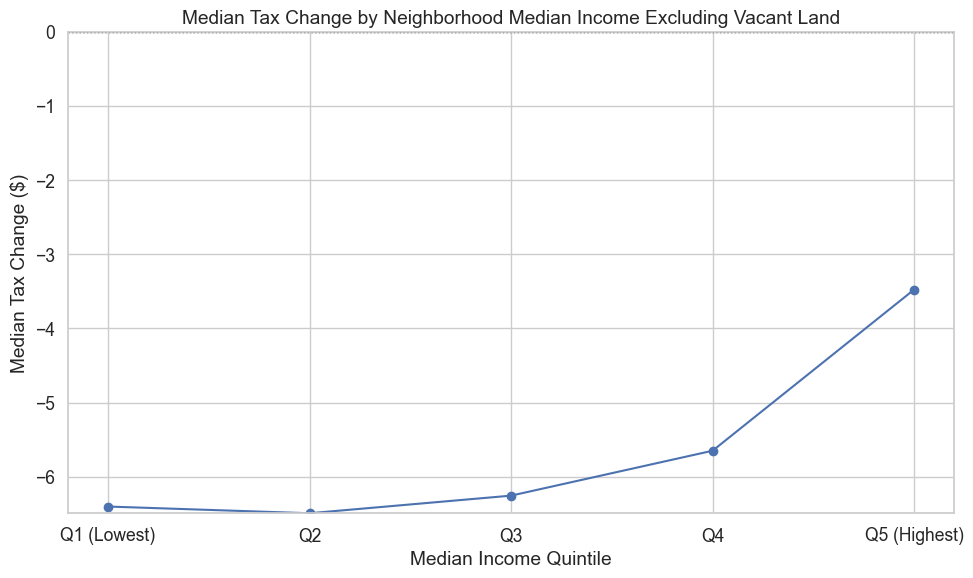

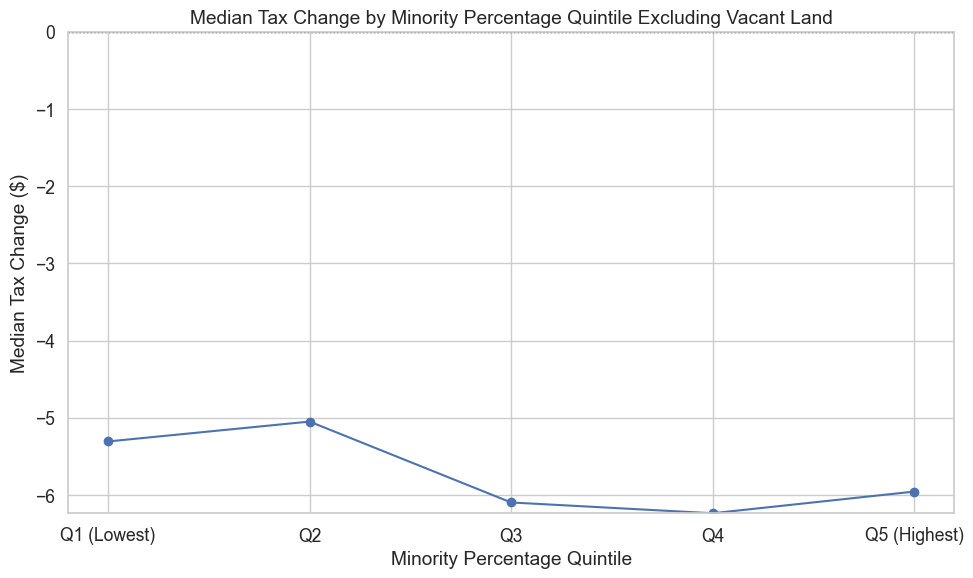

In [319]:
# Plot: Median Tax Change by Neighborhood Median Income Excluding Vacant Land

plt.figure(figsize=(10, 6))
plt.plot(
    non_vacant_income_quintile_summary['median_income_quintile'],
    non_vacant_income_quintile_summary['median_tax_change_pct'],
    marker='o',
    label='Excluding Vacant Land'
)
plt.xlabel('Median Income Quintile')
plt.ylabel('Median Tax Change ($)')
plt.title('Median Tax Change by Neighborhood Median Income Excluding Vacant Land')
ymin = non_vacant_income_quintile_summary['median_tax_change_pct'].min()
ymax = non_vacant_income_quintile_summary['median_tax_change_pct'].max()
# Ensure 0 is included on the y-axis
plt.ylim(min(ymin, 0), max(ymax, 0) if ymax < 0 else max(ymax, 0, 1.05*ymax))
plt.axhline(0, color='black', linewidth=1, linestyle='dotted')
plt.tight_layout()
plt.show()

# Plot: Median Tax Change by Minority Percentage Quintile Excluding Vacant Land

plt.figure(figsize=(10, 6))
plt.plot(
    non_vacant_minority_quintile_summary['minority_pct_quintile'],
    non_vacant_minority_quintile_summary['median_tax_change_pct'],
    marker='o',
    label='Excluding Vacant Land'
)
plt.xlabel('Minority Percentage Quintile')
plt.ylabel('Median Tax Change ($)')
plt.title('Median Tax Change by Minority Percentage Quintile Excluding Vacant Land')
ymin2 = non_vacant_minority_quintile_summary['median_tax_change_pct'].min()
ymax2 = non_vacant_minority_quintile_summary['median_tax_change_pct'].max()
# Ensure 0 is included on the y-axis
plt.ylim(min(ymin2, 0), max(ymax2, 0) if ymax2 < 0 else max(ymax2, 0, 1.05*ymax2))
plt.axhline(0, color='black', linewidth=1, linestyle='dotted')
plt.tight_layout()
plt.show()


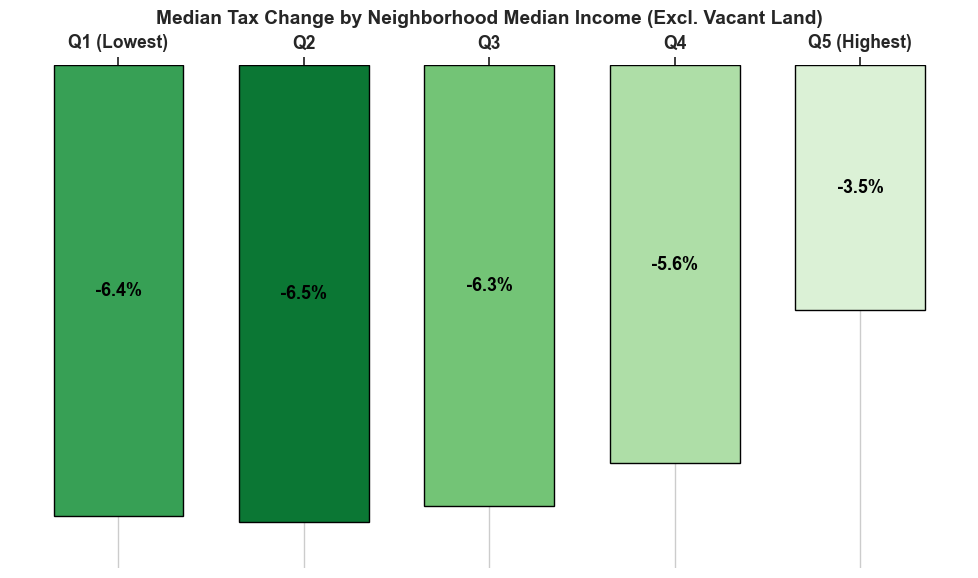

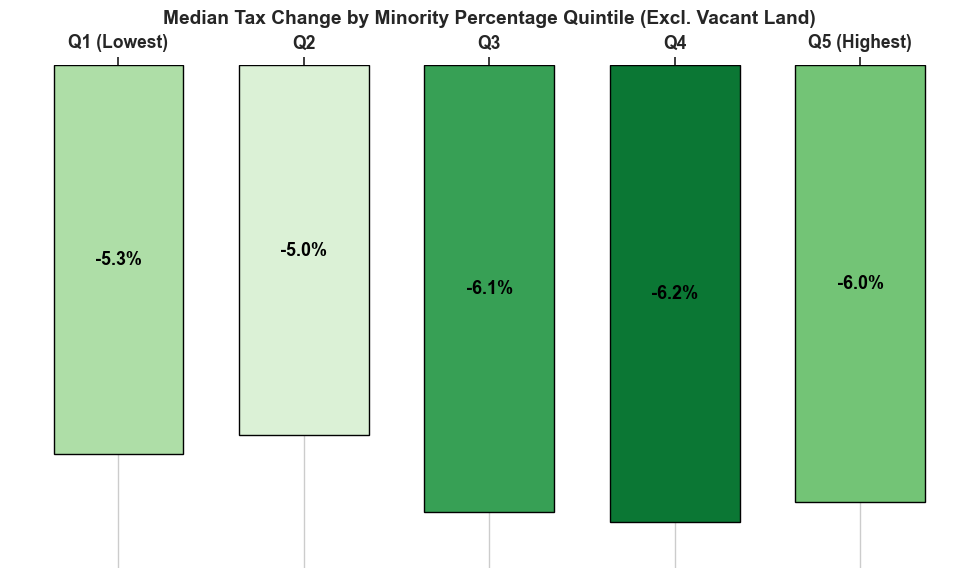

In [320]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a modern style
sns.set_theme(style="whitegrid", font_scale=1.15)

# Upside Down Bar Graph: Median Tax Change by Neighborhood Median Income Excluding Vacant Land
fig, ax = plt.subplots(figsize=(10, 6))

vals = non_vacant_income_quintile_summary['median_tax_change_pct']
labels = non_vacant_income_quintile_summary['median_income_quintile']

# Color mapping: dark green (more negative) to light green (less negative)
colors = sns.color_palette("Greens", n_colors=len(vals))
# Sort so that the most negative (largest magnitude) is darkest
color_map = [colors[i] for i in np.argsort(np.argsort(-vals))]

# To make bars start at the top and go down, invert the y-axis and plot positive heights
bars = ax.bar(
    labels,
    np.abs(vals),
    color=color_map,
    edgecolor='black',
    width=0.7
)

# Invert the y-axis so bars start at the top and go down
ax.invert_yaxis()

# Remove y-axis
ax.yaxis.set_visible(False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title('Median Tax Change by Neighborhood Median Income (Excl. Vacant Land)', weight='bold', pad=30)

# Remove all spines (including bottom)
sns.despine(left=True, right=True, top=True, bottom=True)

# Add value labels (bold, % sign) centered inside each bar (no line below the bar)
for bar, val in zip(bars, vals):
    ax.annotate(
        f"{val:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center', va='center',
        fontsize=13, color='black', fontweight='bold'
    )

# Move x-tick labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(fontweight='bold')

# Set y-limits to show bars going down from the top
ymax = np.abs(vals).max() * 1.1
ax.set_ylim(ymax, 0)

plt.tight_layout()
plt.show()

# Upside Down Bar Graph: Median Tax Change by Minority Percentage Quintile Excluding Vacant Land
fig, ax = plt.subplots(figsize=(10, 6))

vals2 = non_vacant_minority_quintile_summary['median_tax_change_pct']
labels2 = non_vacant_minority_quintile_summary['minority_pct_quintile']

colors2 = sns.color_palette("Greens", n_colors=len(vals2))
color_map2 = [colors2[i] for i in np.argsort(np.argsort(-vals2))]

bars2 = ax.bar(
    labels2,
    np.abs(vals2),
    color=color_map2,
    edgecolor='black',
    width=0.7
)

ax.invert_yaxis()
ax.yaxis.set_visible(False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title('Median Tax Change by Minority Percentage Quintile (Excl. Vacant Land)', weight='bold', pad=30)
sns.despine(left=True, right=True, top=True, bottom=True)

for bar, val in zip(bars2, vals2):
    ax.annotate(
        f"{val:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center', va='center',
        fontsize=13, color='black', fontweight='bold'
    )

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(fontweight='bold')

ymax2 = np.abs(vals2).max() * 1.1
ax.set_ylim(ymax2, 0)

plt.tight_layout()
plt.show()


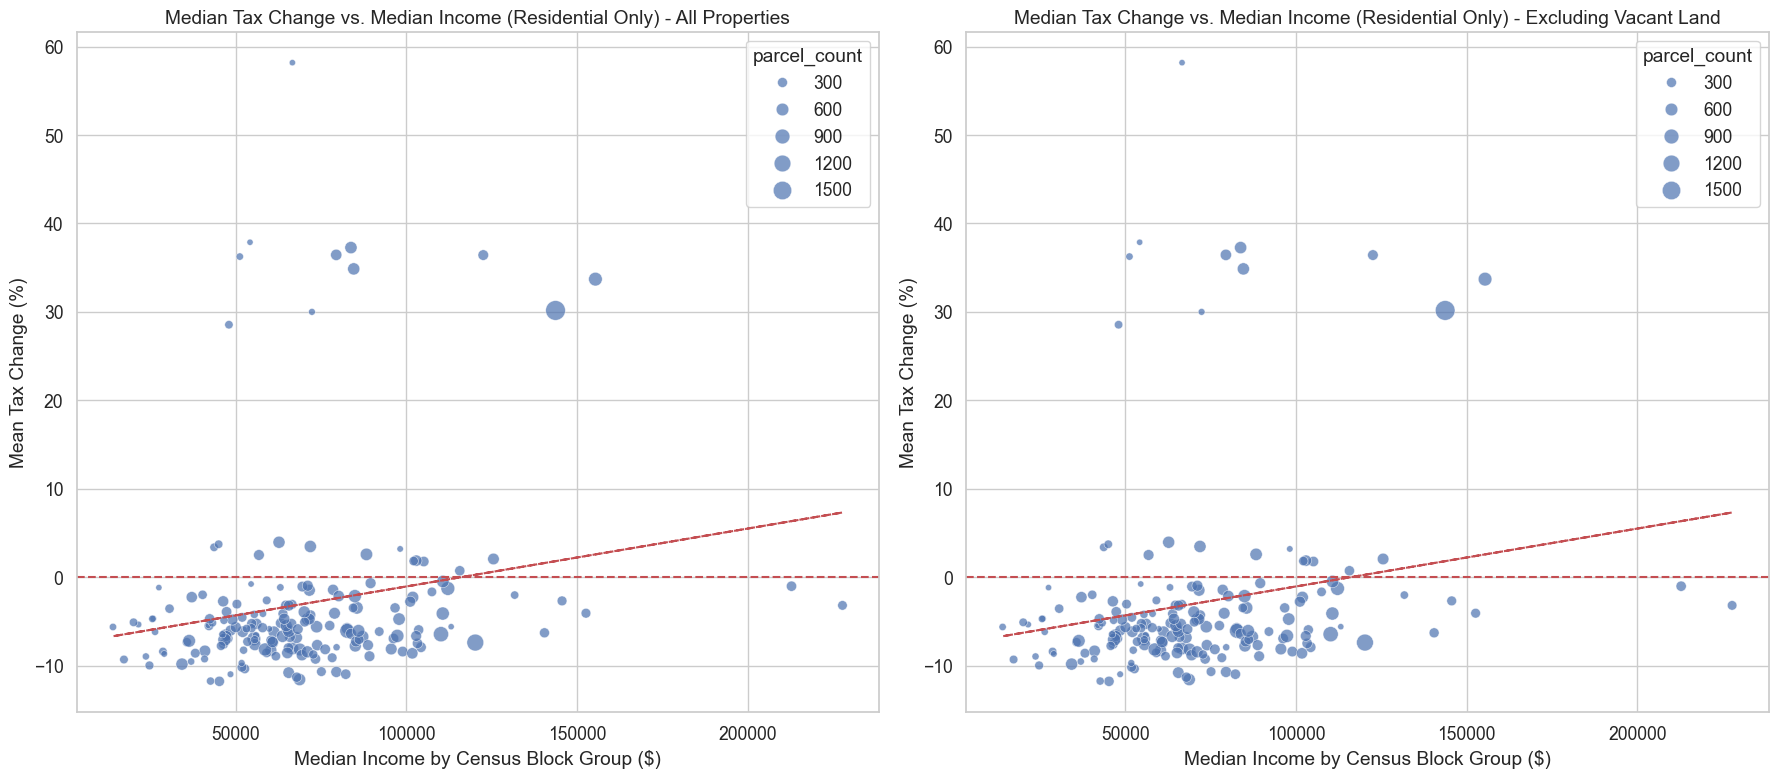

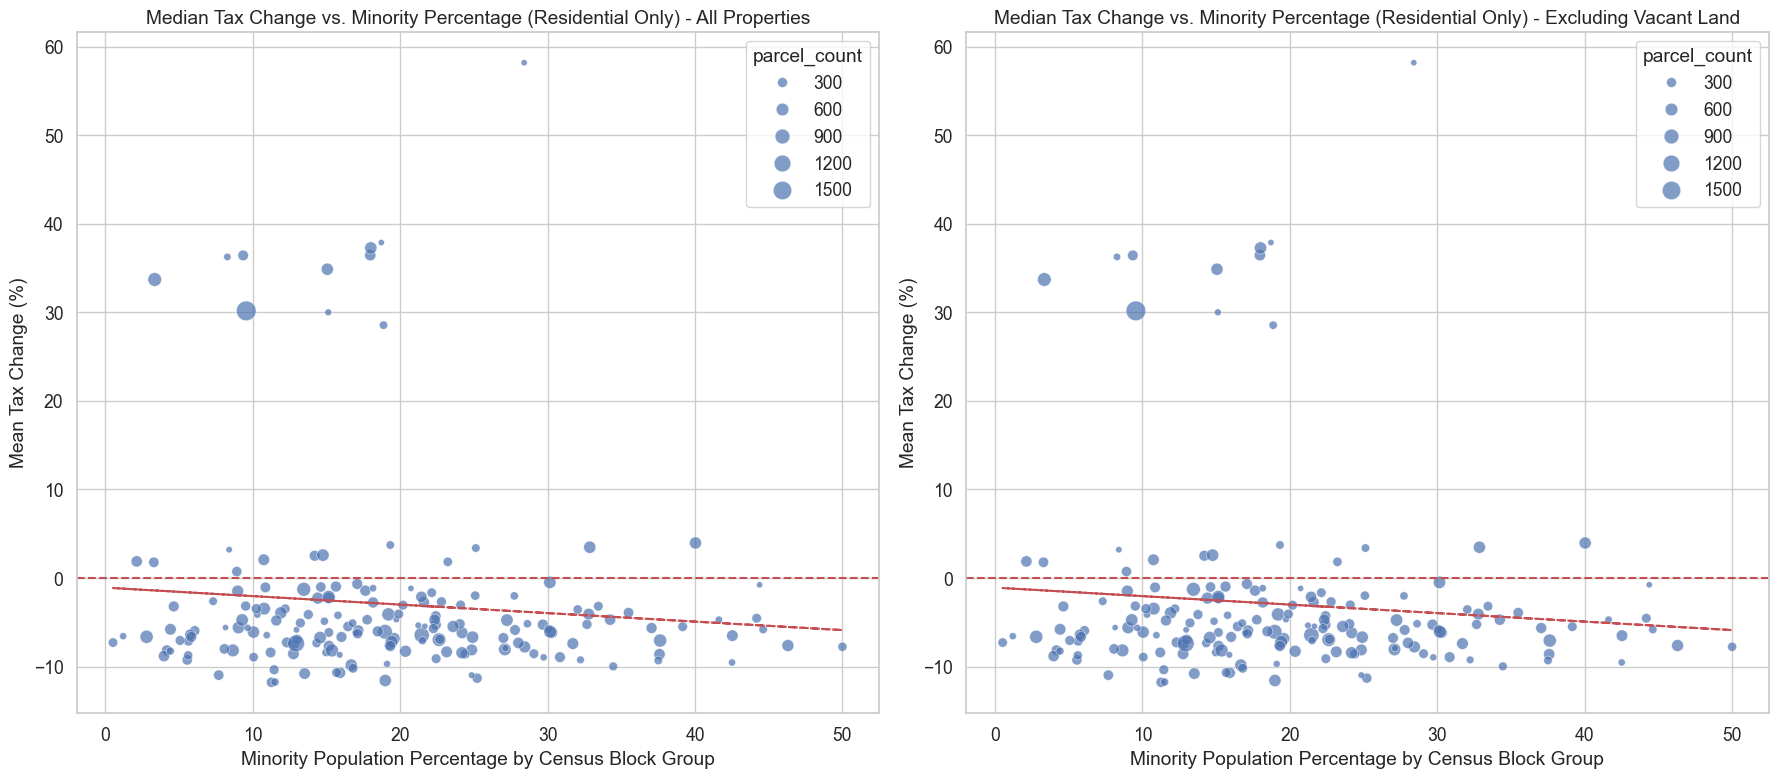

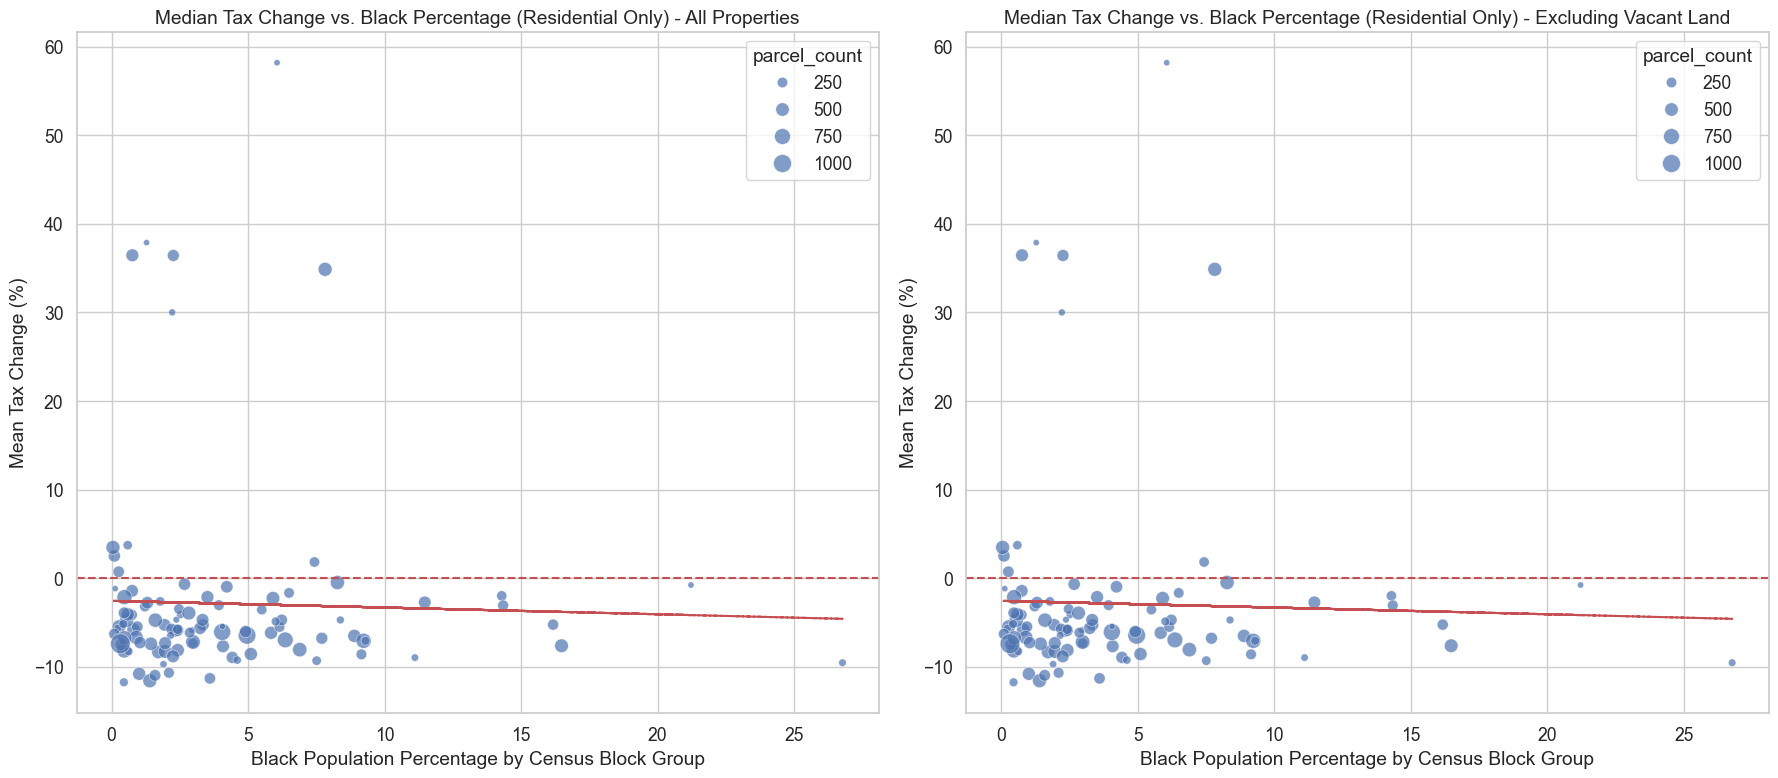

[Residential] Correlation income_mean_all: 0.1874
[Residential] Correlation income_median_all: 0.1926
[Residential] Correlation minority_mean_all: -0.0951
[Residential] Correlation black_mean_all: -0.0228
[Residential] Correlation income_mean_non_vacant: 0.1874
[Residential] Correlation income_median_non_vacant: 0.1926
[Residential] Correlation minority_mean_non_vacant: -0.0951
[Residential] Correlation black_mean_non_vacant: -0.0228


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').apply(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby(f'{group_col}_quintile').apply(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: FutureWarning: The default of observed=False is deprecated and 


[Residential] Tax impact by income quintile (all properties):


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df.groupby(f'{group_col}_quintile').apply(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').apply(
/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/3746907649.py:118: DeprecationWarning: DataFrameGroupBy.apply operated on the grou

,median_income_quintile,count,mean_tax_change_pct,median_tax_change_pct,mean_value
0,Q1 (Lowest),12909.0,-8.808890,-6.606121,43325.904563
1,Q2,13069.0,-8.987762,-6.322472,61468.222282
2,Q3,12705.0,-7.397929,-6.351193,72187.673514
3,Q4,13149.0,-3.820025,-5.824324,88863.460263
4,Q5 (Highest),12609.0,1.427688,-3.176143,125856.200888



[Residential] Tax impact by income quintile (excluding vacant land):


,median_income_quintile,count,mean_tax_change_pct,median_tax_change_pct,mean_value
0,Q1 (Lowest),12909.0,-8.808890,-6.606121,43325.904563
1,Q2,13069.0,-8.987762,-6.322472,61468.222282
2,Q3,12705.0,-7.397929,-6.351193,72187.673514
3,Q4,13149.0,-3.820025,-5.824324,88863.460263
4,Q5 (Highest),12609.0,1.427688,-3.176143,125856.200888



[Residential] Tax impact by minority percentage quintile (all properties):


,minority_pct_quintile,count,mean_tax_change_pct,median_tax_change_pct,mean_value
0,Q1 (Lowest),13403.0,-1.266591,-5.253778,6.447605
1,Q2,12449.0,-5.012698,-5.477547,12.814502
2,Q3,12940.0,-4.421669,-5.775717,17.318255
3,Q4,12771.0,-9.494537,-6.350443,23.045058
4,Q5 (Highest),12878.0,-7.729707,-5.893494,34.135827



[Residential] Tax impact by minority percentage quintile (excluding vacant land):


,minority_pct_quintile,count,mean_tax_change_pct,median_tax_change_pct,mean_value
0,Q1 (Lowest),13403.0,-1.266591,-5.253778,6.447605
1,Q2,12449.0,-5.012698,-5.477547,12.814502
2,Q3,12940.0,-4.421669,-5.775717,17.318255
3,Q4,12771.0,-9.494537,-6.350443,23.045058
4,Q5 (Highest),12878.0,-7.729707,-5.893494,34.135827


In [321]:
# Restrict df to only residential property categories
residential_categories = [
    "Single Family",
    "Small Multi-Family (2-4 units)"
]
df_residential = df[df['PROPERTY_CATEGORY'].isin(residential_categories)].copy()

# --- Repeat the block group summary and quintile analysis for residential only ---

# Filter data for residential (positive income, non-vacant)
gdf_residential_filtered, non_vacant_residential_gdf = filter_data(df_residential)

# Calculate block group summaries (all with positive median_income only, residential only)
census_block_groups_res = calculate_block_group_summary(gdf_residential_filtered)
non_vacant_block_summary_res = calculate_block_group_summary(non_vacant_residential_gdf)

# Create comparison plots (all with positive median_income only, residential only)
plot_comparison(
    census_block_groups_res, non_vacant_block_summary_res, 
    'median_income', 'median_tax_change_pct', 
    'Median Tax Change vs. Median Income (Residential Only)', 
    'Median Income by Census Block Group ($)'
)

plot_comparison(
    census_block_groups_res, non_vacant_block_summary_res,
    'minority_pct', 'median_tax_change_pct',
    'Median Tax Change vs. Minority Percentage (Residential Only)',
    'Minority Population Percentage by Census Block Group'
)

plot_comparison(
    census_block_groups_res, non_vacant_block_summary_res,
    'black_pct', 'median_tax_change_pct',
    'Median Tax Change vs. Black Percentage (Residential Only)',
    'Black Population Percentage by Census Block Group'
)

# Calculate and print correlations (all with positive median_income only, residential only)
correlations_res = calculate_correlations(census_block_groups_res, non_vacant_block_summary_res)
for key, value in correlations_res.items():
    print(f"[Residential] Correlation {key}: {value:.4f}")

# Create and display quintile summaries (income quintiles exclude negative/zero incomes, residential only)
income_quintile_summary_res = create_quintile_summary(gdf_residential_filtered, 'median_income', 'median_income')
non_vacant_income_quintile_summary_res = create_quintile_summary(non_vacant_residential_gdf, 'median_income', 'median_income')
minority_quintile_summary_res = create_quintile_summary(gdf_residential_filtered, 'minority_pct', 'minority_pct')
non_vacant_minority_quintile_summary_res = create_quintile_summary(non_vacant_residential_gdf, 'minority_pct', 'minority_pct')

print("\n[Residential] Tax impact by income quintile (all properties):")
display(income_quintile_summary_res)
print("\n[Residential] Tax impact by income quintile (excluding vacant land):")
display(non_vacant_income_quintile_summary_res)
print("\n[Residential] Tax impact by minority percentage quintile (all properties):")
display(minority_quintile_summary_res)
print("\n[Residential] Tax impact by minority percentage quintile (excluding vacant land):")
display(non_vacant_minority_quintile_summary_res)


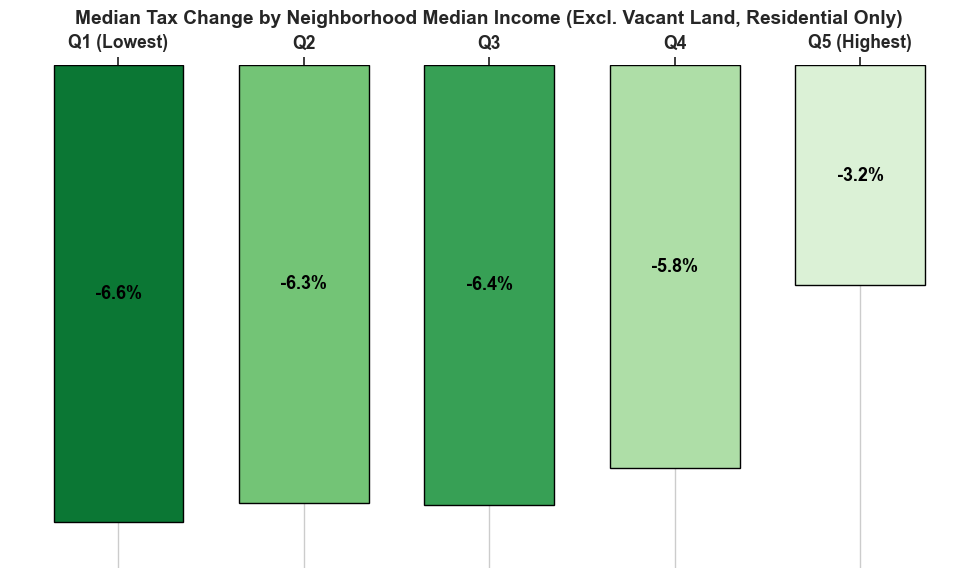

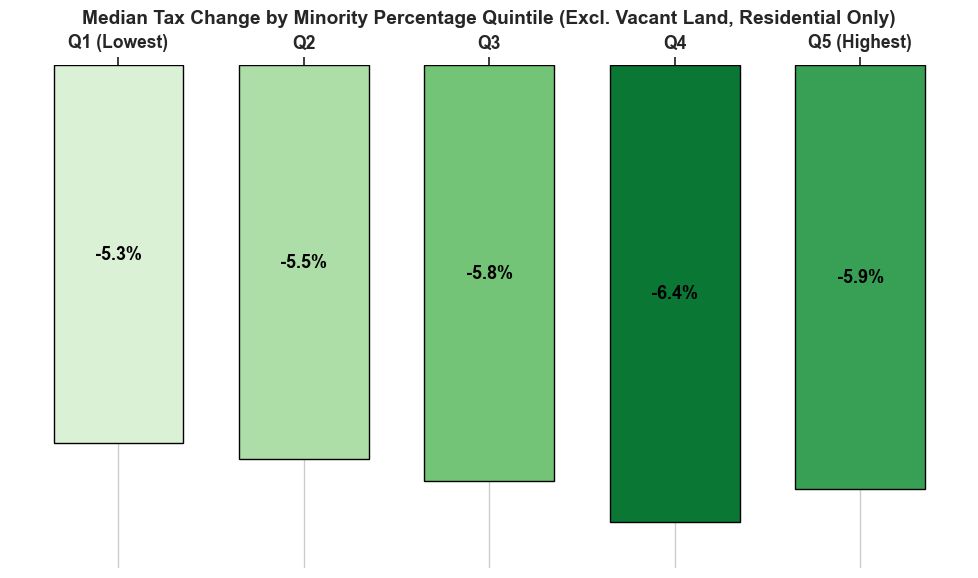

In [322]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a modern style
sns.set_theme(style="whitegrid", font_scale=1.15)

# Upside Down Bar Graph: Median Tax Change by Neighborhood Median Income Excluding Vacant Land (Residential Only)
fig, ax = plt.subplots(figsize=(10, 6))

vals = non_vacant_income_quintile_summary_res['median_tax_change_pct']
labels = non_vacant_income_quintile_summary_res['median_income_quintile']

# Color mapping: dark green (more negative) to light green (less negative)
colors = sns.color_palette("Greens", n_colors=len(vals))
# Sort so that the most negative (largest magnitude) is darkest
color_map = [colors[i] for i in np.argsort(np.argsort(-vals))]

# To make bars start at the top and go down, invert the y-axis and plot positive heights
bars = ax.bar(
    labels,
    np.abs(vals),
    color=color_map,
    edgecolor='black',
    width=0.7
)

# Invert the y-axis so bars start at the top and go down
ax.invert_yaxis()

# Remove y-axis
ax.yaxis.set_visible(False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title('Median Tax Change by Neighborhood Median Income (Excl. Vacant Land, Residential Only)', weight='bold', pad=30)

# Remove all spines (including bottom)
sns.despine(left=True, right=True, top=True, bottom=True)

# Add value labels (bold, % sign) centered inside each bar (no line below the bar)
for bar, val in zip(bars, vals):
    ax.annotate(
        f"{val:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center', va='center',
        fontsize=13, color='black', fontweight='bold'
    )

# Move x-tick labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(fontweight='bold')

# Set y-limits to show bars going down from the top
ymax = np.abs(vals).max() * 1.1
ax.set_ylim(ymax, 0)

plt.tight_layout()
plt.show()

# Upside Down Bar Graph: Median Tax Change by Minority Percentage Quintile Excluding Vacant Land (Residential Only)
fig, ax = plt.subplots(figsize=(10, 6))

vals2 = non_vacant_minority_quintile_summary_res['median_tax_change_pct']
labels2 = non_vacant_minority_quintile_summary_res['minority_pct_quintile']

colors2 = sns.color_palette("Greens", n_colors=len(vals2))
color_map2 = [colors2[i] for i in np.argsort(np.argsort(-vals2))]

bars2 = ax.bar(
    labels2,
    np.abs(vals2),
    color=color_map2,
    edgecolor='black',
    width=0.7
)

ax.invert_yaxis()
ax.yaxis.set_visible(False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title('Median Tax Change by Minority Percentage Quintile (Excl. Vacant Land, Residential Only)', weight='bold', pad=30)
sns.despine(left=True, right=True, top=True, bottom=True)

for bar, val in zip(bars2, vals2):
    ax.annotate(
        f"{val:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center', va='center',
        fontsize=13, color='black', fontweight='bold'
    )

ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(fontweight='bold')

ymax2 = np.abs(vals2).max() * 1.1
ax.set_ylim(ymax2, 0)

plt.tight_layout()
plt.show()


In [323]:
# Import our new policy analysis functions
import sys
sys.path.append('..')  # Add parent directory to path
from policy_analysis import (
    analyze_vacant_land, 
    analyze_parking_lots, 
    calculate_development_tax_penalty,
    print_vacant_land_summary,
    print_parking_analysis_summary, 
    print_development_penalty_summary
)


In [324]:
## Policy Analysis: Vacant Land Speculation

# Let's see if we have owner information in our dataset
print("Columns that might contain owner information:")
owner_cols = [col for col in df.columns if 'owner' in col.lower() or 'name' in col.lower()]
print(owner_cols)

# Filter out fully exempt properties for analysis
df_non_exempt = df[df['full_exmp'] == 0].copy()
print(f"Excluding {(df['full_exmp'] == 1).sum():,} fully exempt properties from analysis")
print(f"Analysis dataset: {len(df_non_exempt):,} properties (down from {len(df):,})")

# Run vacant land analysis excluding fully exempt land
vacant_analysis = analyze_vacant_land(
    df=df_non_exempt,
    land_value_col='land_value',
    property_type_col='prop_use_desc', 
    neighborhood_col='nbhd_name',
    vacant_identifier='Vacant Land',
    improvement_value_col='improvement_value',
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

# Print formatted summary
print_vacant_land_summary(vacant_analysis)


Columns that might contain owner information:
['nbhd_name', 'site_str_name', 'NAME', 'BASENAME']
Excluding 0 fully exempt properties from analysis
Analysis dataset: 75,527 properties (down from 75,527)
VACANT LAND ANALYSIS SUMMARY
Total vacant parcels: 4,657
Total vacant land value: $583,975,745
Average vacant land value: $125,397
Vacant land as % of total city land value: 7.0%

Top 5 neighborhoods by vacant land value:
           count  total_value   avg_value  median_value
nbhd_name                                              
4433M        307   32916440.0   107219.67       59490.0
4538O         23   23151310.0  1006578.70      167170.0
4132M         88   21768080.0   247364.55       99420.0
4113M         56   21174200.0   378110.71       67140.0
4133M         96   18415820.0   191831.46       62110.0


In [325]:
## Policy Analysis: Parking Lot Efficiency

# Run parking lot analysis excluding fully exempt land
parking_analysis = analyze_parking_lots(
    df=df_non_exempt,
    land_value_col='land_value',
    improvement_value_col='improvement_value',
    property_type_col='prop_use_desc',
    parking_identifier='Trans - Parking',
    min_land_value_threshold=50000,  # Focus on land worth $50k+
    max_improvement_ratio=0.1,  # Improvement value <= 10% of land value
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

# Print formatted summary
print_parking_analysis_summary(parking_analysis)

# Show detailed breakdown by land value tier
if 'by_land_value_tier' in parking_analysis:
    print("\nDetailed breakdown by land value tier:")
    print(parking_analysis['by_land_value_tier'].to_string())


PARKING LOT EFFICIENCY ANALYSIS
Total parking lots: 182
Total parking land value: $69,656,039
Average parking land value: $382,725
Average improvement ratio: 17.7%

Underutilized parking lots (Land value >= $50,000 and improvement ratio <= 10.0%):
Count: 160
Total land value: $57,961,209
Average land value: $362,258

Development potential:
Current improvement value: $1,612,400
Potential improvement value: $169,252,165
Untapped development value: $167,639,765

Detailed breakdown by land value tier:
                 count  total_land_value  avg_land_value  avg_improvement_ratio
land_value_tier                                                                
<$25k                1            1040.0        1040.000                  0.000
$25k-$50k            1           49680.0       49680.000                  0.040
$50k-$100k          19         1502413.0       79074.368                  0.038
$100k-$250k         61        11060570.0      181320.820                  0.044
>$250k           

/Users/gregmiller/Documents/CLE/cle/LVTShift/examples/../policy_analysis.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_analysis = tier_df.groupby('land_value_tier').agg({


In [326]:
# Import new property analysis functions
from policy_analysis import (
    analyze_property_values_by_category, 
    print_property_values_summary
)


In [327]:
## Property Value Analysis by Category

# Analyze property values by category including exemptions
property_values = analyze_property_values_by_category(
    df=df,
    category_col='PROPERTY_CATEGORY', 
    land_value_col='land_value',
    improvement_value_col='improvement_value',
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

# Print formatted summary
print_property_values_summary(property_values, "Spokane Property Values by Category")


SPOKANE PROPERTY VALUES BY CATEGORY
             PROPERTY_CATEGORY total_land_value  property_count total_improvement_value improvement_land_ratio total_exemptions non_exempt_land_value non_exempt_improvement_value non_exempt_improvement_land_ratio  fully_exempt_count
                 Single Family   $6,078,620,740           62520         $17,680,046,150                   2.91     $940,487,108        $5,860,215,005              $16,957,964,777                              2.89                 NaN
     Retail/Service/Commercial   $1,225,496,200            3612          $4,470,793,215                   3.65     $479,511,282        $1,206,792,143               $4,009,985,990                              3.32                 NaN
                   Vacant Land     $584,881,970            4657             $36,486,440                   0.06       $5,476,925          $583,975,745                  $31,915,740                              0.05                 NaN
Small Multi-Family (2-4 units)  

In [328]:
## Policy Analysis: Development Tax Penalty

# Calculate the perverse incentive of building taxes
# Using the current building millage rate from the split-rate system we modeled
building_millage = 1.1238 / 1000  # Convert from per-thousand to decimal

penalty_analysis = calculate_development_tax_penalty(
    df=df,
    improvement_value_col='improvement_value',
    millage_rate=building_millage,  # Current building tax rate
    years=30,  # 30-year analysis horizon
    discount_rate=0.05,  # 5% discount rate
    typical_construction_cost_per_sqft=200,  # Spokane construction costs
    typical_unit_size_sqft=1200  # Typical housing unit size
)

# Print formatted summary
print_development_penalty_summary(penalty_analysis)

# Compare with LVT scenario (zero building tax)
print("\n" + "="*60)
print("COMPARISON: LVT ELIMINATES DEVELOPMENT PENALTY")
print("="*60)

lvt_penalty_analysis = calculate_development_tax_penalty(
    df=df,
    improvement_value_col='improvement_value',
    millage_rate=0.0,  # No building tax under pure LVT
    years=30,
    discount_rate=0.05,
    typical_construction_cost_per_sqft=200,
    typical_unit_size_sqft=1200
)

print(f"Current system development penalty: {penalty_analysis['equivalent_lost_units']:,.0f} housing units")
print(f"LVT system development penalty: {lvt_penalty_analysis['equivalent_lost_units']:,.0f} housing units")
print(f"Net housing units enabled by LVT: {penalty_analysis['equivalent_lost_units'] - lvt_penalty_analysis['equivalent_lost_units']:,.0f}")

# Show different scenarios with varying building tax rates
print("\n" + "="*60)
print("SCENARIO ANALYSIS: VARYING BUILDING TAX RATES")
print("="*60)

tax_rates = [0.005, 0.01, 0.015, 0.02, 0.025]  # 0.5% to 2.5%
scenarios = []

for rate in tax_rates:
    scenario = calculate_development_tax_penalty(
        df=df,
        improvement_value_col='improvement_value',
        millage_rate=rate,
        years=30,
        discount_rate=0.05,
        typical_construction_cost_per_sqft=200,
        typical_unit_size_sqft=1200
    )
    scenarios.append({
        'Tax Rate (%)': rate * 100,
        'NPV as % of Construction': scenario['npv_as_pct_of_construction_cost'],
        'Equivalent Lost Units': scenario['equivalent_lost_units'],
        'Lost Units as % of Stock': scenario['units_lost_percentage']
    })

scenario_df = pd.DataFrame(scenarios)
print(scenario_df.round(1).to_string(index=False))


DEVELOPMENT TAX PENALTY ANALYSIS
Analysis parameters:
  Building tax rate: 0.1%
  Time horizon: 30 years
  Discount rate: 5.0%

Results:
Total improvement value in city: $25,807,091,185
Annual building tax revenue: $29,002,009
NPV of building taxes (30 years): $445,831,964
NPV as % of construction cost: 1.7%

Housing impact analysis:
Equivalent 'lost' housing units: 1,858
Percentage of current housing stock: 1.7%

Interpretation:
  With a 0.1% building tax, the NPV of taxes over 30 years equals 1.7% of initial construction cost.
  This tax penalty is equivalent to losing 1,858 housing units (1.7% of current housing stock).
  Removing building taxes could enable 1,858 additional housing units to be economically viable.

COMPARISON: LVT ELIMINATES DEVELOPMENT PENALTY
Current system development penalty: 1,858 housing units
LVT system development penalty: 0 housing units
Net housing units enabled by LVT: 1,858

SCENARIO ANALYSIS: VARYING BUILDING TAX RATES
 Tax Rate (%)  NPV as % of Constr

In [329]:
# Land value by improvement share categories (non-exempt basis)
from policy_analysis import analyze_land_by_improvement_share

# Run for all parcels
share_summary = analyze_land_by_improvement_share(
    df=df,
    land_value_col='land_value',
    improvement_value_col='improvement_value',
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

print("Adjusted total land value (non-exempt): ${:,.0f}".format(share_summary['total_adjusted_land_value']))
for row in share_summary['categories']:
    print("- {}: {:,} parcels | Adjusted land: ${:,.0f} ({:.1f}%)".format(
        row['category'], row['parcel_count'], row['adjusted_land_value'], row['share_of_total_land_value_pct']
    ))

# Now exclude vacant land and parking lots using PROPERTY_CATEGORY
exclude_categories = ["Vacant Land", "Transportation - Parking"]
df_non_vacant = df[~df["PROPERTY_CATEGORY"].isin(exclude_categories)]

share_summary_non_vacant = analyze_land_by_improvement_share(
    df=df_non_vacant,
    land_value_col='land_value',
    improvement_value_col='improvement_value',
    exemption_col='exmp_amt',
    exemption_flag_col='full_exmp'
)

print("\n(Excluding Vacant Land and Transportation - Parking)")
print("Adjusted total land value (non-exempt, non-vacant): ${:,.0f}".format(share_summary_non_vacant['total_adjusted_land_value']))
for row in share_summary_non_vacant['categories']:
    print("- {}: {:,} parcels | Adjusted land: ${:,.0f} ({:.1f}%)".format(
        row['category'], row['parcel_count'], row['adjusted_land_value'], row['share_of_total_land_value_pct']
    ))


Adjusted total land value (non-exempt): $8,303,658,227
- 0% improvement: 3,949 parcels | Adjusted land: $505,954,960 (6.1%)
- <10% improvement (excl. 0%): 826 parcels | Adjusted land: $170,884,568 (2.1%)
- 10-25% improvement: 369 parcels | Adjusted land: $75,905,035 (0.9%)
- 25-50% improvement: 821 parcels | Adjusted land: $230,090,411 (2.8%)

(Excluding Vacant Land and Transportation - Parking)
Adjusted total land value (non-exempt, non-vacant): $7,650,026,443
- 0% improvement: 294 parcels | Adjusted land: $47,289,530 (0.6%)
- <10% improvement (excl. 0%): 70 parcels | Adjusted land: $26,713,491 (0.3%)
- 10-25% improvement: 100 parcels | Adjusted land: $46,430,500 (0.6%)
- 25-50% improvement: 729 parcels | Adjusted land: $219,582,211 (2.9%)


In [330]:
print(output_summary)

                 PROPERTY_CATEGORY  total_tax_change_dollars  property_count  \
7                    Single Family             -3.444235e+06           62520   
11                     Vacant Land              4.807383e+06            4657   
6        Retail/Service/Commercial              2.070749e+06            3612   
8   Small Multi-Family (2-4 units)             -1.150319e+06            3252   
2    Large Multi-Family (5+ units)             -2.424051e+06             984   
9         Transportation - Parking              4.461419e+05             182   
5                Other Residential              9.643387e+03             150   
3         Manufacturing/Industrial             -5.206984e+04             115   
10            Transportation/Other              1.473286e+04              23   
4                 Mobile Home Park              2.146673e+05              21   
1                Designated Forest              6.309573e+00               5   
0                     Agricultural      

In [331]:
import pandas as pd

# Calculate square footage for each parcel
# If 'Shape__Area' is in square meters, convert to square feet (1 sq meter = 10.7639 sq ft)
if 'Shape__Area' in df.columns:
    df['sqft'] = df['Shape__Area'] * 10.7639
else:
    # If not available, try to calculate from geometry (assuming geometry is projected in meters)
    df['sqft'] = df.geometry.area * 10.7639

# Avoid division by zero
df['sqft'] = df['sqft'].replace(0, pd.NA)

# Calculate improvement value (assessed minus land, clipped at zero)
df['improvement_value'] = (df['assessed_amt'] - df['land_value']).clip(lower=0)

# Calculate per square foot columns
df['land_value_per_sqft'] = df['land_value'] / df['sqft']
df['assessed_amt_per_sqft'] = df['assessed_amt'] / df['sqft']
df['improvement_value_per_sqft'] = df['improvement_value'] / df['sqft']
df['tax_change_per_sqft'] = df['tax_change'] / df['sqft']
df['new_tax_per_sqft'] = df['new_tax'] / df['sqft']
df['current_tax_per_sqft'] = df['current_tax'] / df['sqft']

# Ensure geometry is attached and select columns to save
columns_to_save = [
    'tax_change_pct', 'tax_change', 'new_tax', 'current_tax', 'PID_NUM', 
    'PROPERTY_CATEGORY', 'nbhd_code', 'prop_use_desc', 'site_address', 
    'assessed_amt', 'land_value', 'improvement_value',  'geometry',
    'sqft', 'land_value_per_sqft', 'assessed_amt_per_sqft', 'improvement_value_per_sqft',
    'tax_change_per_sqft', 'new_tax_per_sqft', 'current_tax_per_sqft'
]

# Save the DataFrame with geometry as a parquet file (restricted columns)
df[columns_to_save].to_parquet('spokane_full_geom.parquet', index=False)

# Also save the full DataFrame with geometry as a parquet file (all columns)
df.to_parquet('spokane_full_geom_fullcols.parquet', index=False)


In [332]:
# Check if all geometries are Polygon or MultiPolygon and print the result
is_all_polygons = df.geometry.geom_type.isin(['Polygon', 'MultiPolygon']).all()
print(f"All geometries are Polygon or MultiPolygon: {is_all_polygons}")
if not is_all_polygons:
    # Try to convert to polygons if possible
    df = df[df.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()


All geometries are Polygon or MultiPolygon: True


In [333]:

# Define "underdeveloped" as: non-exempt and improvement_value / assessed_amt < 0.5
# "Vacant" properties: PROPERTY_CATEGORY contains "vacant" (case-insensitive)
# "Non-exempt": new_exemption is null/None/NaN or 0

# 1. Vacant properties
vacant_mask = df['PROPERTY_CATEGORY'].str.lower().str.contains('vacant', na=False)

# 3. Underdeveloped: improvement_value / assessed_amt < 0.5
underdeveloped_mask = (df['improvement_value'] / df['assessed_amt'] < 0.75)

# Report the number of parcels that are vacant and number that are underdeveloped
n_vacant = vacant_mask.sum()
n_underdeveloped = underdeveloped_mask.sum()
print(f"Number of vacant parcels: {n_vacant}")
print(f"Number of underdeveloped parcels: {n_underdeveloped}")

# Combine: vacant OR underdeveloped
target_mask = vacant_mask | underdeveloped_mask

# Calculate for target group
target_df = df[target_mask]
other_df = df[~target_mask]

# Results for target group
total_tax_change_target = target_df['tax_change'].sum()
median_pct_target = target_df['tax_change_pct'].median()
n_target = len(target_df)
n_target_increase = (target_df['tax_change'] > 0).sum()
n_target_decrease = (target_df['tax_change'] < 0).sum()
pct_target_increase = 100 * n_target_increase / n_target if n_target > 0 else float('nan')
pct_target_decrease = 100 * n_target_decrease / n_target if n_target > 0 else float('nan')

# Results for all other parcels
total_tax_change_other = other_df['tax_change'].sum()
median_pct_other = other_df['tax_change_pct'].median()
n_other = len(other_df)
n_other_increase = (other_df['tax_change'] > 0).sum()
n_other_decrease = (other_df['tax_change'] < 0).sum()
pct_other_increase = 100 * n_other_increase / n_other if n_other > 0 else float('nan')
pct_other_decrease = 100 * n_other_decrease / n_other if n_other > 0 else float('nan')

print("Vacant or Underdeveloped Parcels:")
print(f"  Total Tax Change ($): {total_tax_change_target:,.2f}")
print(f"  Median Tax Change (%): {median_pct_target:.2f}")
print(f"  Parcels with Tax Increase: {pct_target_increase:.1f}%")
print(f"  Parcels with Tax Decrease: {pct_target_decrease:.1f}%")

print("\nAll Other Parcels:")
print(f"  Total Tax Change ($): {total_tax_change_other:,.2f}")
print(f"  Median Tax Change (%): {median_pct_other:.2f}")
print(f"  Parcels with Tax Increase: {pct_other_increase:.1f}%")
print(f"  Parcels with Tax Decrease: {pct_other_decrease:.1f}%")


Number of vacant parcels: 4657
Number of underdeveloped parcels: 44173
Vacant or Underdeveloped Parcels:
  Total Tax Change ($): 10,069,603.84
  Median Tax Change (%): -2.49
  Parcels with Tax Increase: 37.0%
  Parcels with Tax Decrease: 63.0%

All Other Parcels:
  Total Tax Change ($): -9,567,968.66
  Median Tax Change (%): -8.41
  Parcels with Tax Increase: 7.9%
  Parcels with Tax Decrease: 92.1%


In [334]:
with pd.option_context('display.max_rows', None):
    display(df[df['PID_NUM'].isin(['35081.2213', '35081.2312'])])



,OBJECTID_left,PID_NUM,ACO_NUM,PIDMAP,parcel,exmp_code,exmp_amt,nbhd_code,nbhd_name,prop_use_code,prop_use_desc,tax_year,site_address,site_str_nbr,site_str_nbr_suf,site_str_dir,site_str_dir_suf,site_str_name,site_str_type,site_apartment,site_city,site_state,site_zip,soil_id,bldg_only_flag,vacant_land_flag,res_com_flag,appraiser_id,acreage,assessed_amt,taxable_amt,tax_code_area,inspection_cycle,parcel_location,land_value,asmt_year_exmp_code,asmt_year_exmp_amt,eff_from_date,eff_to_date,asmt_year,seg_status,Shape__Area,Shape__Length,geometry,full_exmp,total_millage,one_cap_millage,statute_millage,spokane_general_millage,total_spokane_boundaries_millage,sp_sd081_spokane_b&i,sp_sd081_spokane_general,sp_spokane_bond,sp_spokane_bond_new,sp_spokane_ems,sp_spokane_general,sp_spokane_general_senior_lift,over_590,over_one_percent,millage_rate,exmp_flag,current_tax,current_tax_full,sp_sd081_spokane_b&i_current_tax,sp_sd081_spokane_general_current_tax,sp_spokane_bond_current_tax,sp_spokane_bond_new_current_tax,sp_spokane_ems_current_tax,sp_spokane_general_current_tax,sp_spokane_general_senior_lift_current_tax,PROPERTY_CATEGORY,improvement_value,total_new_spokane_tax,total_new_spokane_millage,sp_sd081_spokane_b&i_new_tax,sp_sd081_spokane_b&i_new_millage,sp_sd081_spokane_general_new_tax,sp_sd081_spokane_general_new_millage,sp_spokane_bond_new_tax,sp_spokane_bond_new_millage,sp_spokane_bond_new_new_tax,sp_spokane_bond_new_new_millage,sp_spokane_ems_new_tax,sp_spokane_ems_new_millage,sp_spokane_general_new_tax,sp_spokane_general_new_millage,sp_spokane_general_senior_lift_new_tax,sp_spokane_general_senior_lift_new_millage,total_new_millage,new_tax,tax_change,new_tax_full,tax_change_pct,one_cap_millage_new,statute_millage_new,statute_levies_sum_new,OID,STATE,COUNTY,TRACT,BLKGRP,BLOCK,SUFFIX,GEOID,LWBLKTYP,UR,AREAWATER,AREALAND,MTFCC,NAME,BASENAME,LSADC,FUNCSTAT,CENTLON,CENTLAT,INTPTLON,INTPTLAT,HU100,POP100,OBJECTID_right,state_fips,county_fips,tract_fips,bg_fips,std_geoid,median_income,total_pop,white_pop,black_pop,hispanic_pop,state,county,tract,census_block_group,minority_pct,black_pct,sqft,land_value_per_sqft,assessed_amt_per_sqft,improvement_value_per_sqft,tax_change_per_sqft,new_tax_per_sqft,current_tax_per_sqft
83348,83349,35081.2213,20220202,1.2213,35081.2213,None,0.0,713568,LOGAN,91,Vacant Land,2025.0,2808 N CINCINNATI ST,2808.0,None,N,None,CINCINNATI,ST,None,SPOKANE,WA,99207,R1OL,N,Y,R,150,0.45,154000.0,154000.0,0010,6,35081.2213,154000.0,None,None,1.640995e+12,None,2026.0,Active-Complete,4061.328125,255.467142,"POLYGON ((-117.39766 47.68357, -117.39802 47.6...",0,9.8928,5.7371,2.9185,2.0068,6.8648,1.3429,2.5,0.0939,0.2189,0.4995,2.0068,0.2028,False,False,6.8648,0,1057.17920,1523.49120,206.80660,385.0,14.46060,33.71060,76.9230,309.04720,31.23120,Vacant Land,0.0,2242.294326,0,471.995114,3.064903,878.686264,5.705755,36.074627,0.234251,85.257060,0.553617,142.023362,0.92223,570.595562,3.705166,57.662338,0.374431,14.560353,2242.294326,1185.115126,2708.606326,77.789430,8.029826,4.788497,4.079597,210701008218360,53,063,001400,2,2050,None,530630014002050,L,U,0,6633,G5040,Block 2050,2050,BK,S,-117.3978330,+47.6839799,-117.3978330,+47.6839799,3,13,4313737,53,063,001400,2,530630014002,71071.0,2177.0,1584.0,12.0,385.0,53,063,001400,2,27.24,0.55,43715.729805,3.522759,3.522759,0.00000,0.027110,0.051293,0.024183
83358,83359,35081.2312,,1.2312,35081.2312,None,0.0,713568,LOGAN,12,Two-to-Four Unit,2025.0,2811 N CINCINNATI ST,2811.0,None,N,None,CINCINNATI,ST,None,SPOKANE,WA,None,RO13,N,N,R,150,0.15,394600.0,394600.0,0010,6,35081.2312,75000.0,None,None,3.155328e+11,None,2026.0,Active-Complete,1354.984375,164.834953,"POLYGON ((-117.39843 47.68385, -117.39896 47.6...",0,9.8928,5.7371,2.9185,2.0068,6.8648,1.3429,2.5,0.0939,0.2189,0.4995,2.0068,0.2028,False,False,6.8648,0,2708.85008,3903.69888,529.90834,986.5,37.05294,86.37794,197.1027,791.88328,80.02488,Small Multi-Family (2-4 units),319600.0,2288.253712,0,417.286589,3.064903,776.838538,5.705755,31.893250,0.

In [335]:

# --- Export spokane.parquet with same columns as Syracuse ---
import os
import numpy as np

# Create export dataframe
export_gdf = df.copy()

# Create exemption flag as binary (1/0) for fully exempt properties
export_gdf['exemption_flag'] = (export_gdf['full_exmp'] == True).astype(int)

# Map property category (use existing PROPERTY_CATEGORY column)
export_gdf['property_land_use_category'] = export_gdf['PROPERTY_CATEGORY']

# Create refined property/land use category with three options: Vacant, Parking Lot, Underdeveloped
def categorize_property_refined(row):
    """Categorize properties into refined categories"""
    category = row['PROPERTY_CATEGORY']
    if 'Vacant' in str(category):
        return 'Vacant'
    elif 'Parking' in str(category):
        return 'Parking Lot'
    elif row['improvement_value'] < 0.5 * (row['land_value'] + row['improvement_value']):
        return 'Underdeveloped'
    else:
        return None  # null for all other categories

export_gdf['property_land_use_refined'] = export_gdf.apply(categorize_property_refined, axis=1)

# Calculate area in square feet from geometry (Shape__Area is already in square feet or convert from sq meters)
if 'Shape__Area' in export_gdf.columns:
    # Assume Shape__Area is in square meters, convert to square feet
    export_gdf['area_sqft'] = export_gdf['Shape__Area'] * 10.7639
else:
    # Fallback: calculate from geometry
    export_gdf['area_sqft'] = export_gdf.geometry.area * 10.7639

# Calculate current tax per square foot
export_gdf['current_tax_per_sqft'] = np.where(
    export_gdf['area_sqft'] > 0,
    export_gdf['current_tax'] / export_gdf['area_sqft'],
    0
)

# Calculate land value per square foot
export_gdf['land_value_per_sqft'] = np.where(
    export_gdf['area_sqft'] > 0,
    export_gdf['land_value'] / export_gdf['area_sqft'],
    0
)

# Calculate improvement value per square foot
export_gdf['improvement_value_per_sqft'] = np.where(
    export_gdf['area_sqft'] > 0,
    export_gdf['improvement_value'] / export_gdf['area_sqft'],
    0
)

# Select columns for export, matching Syracuse structure
columns_to_export = [
    'geometry',
    'exemption_flag',
    'property_land_use_category',
    'property_land_use_refined',
    'current_tax',
    'current_tax_per_sqft',
    'land_value',
    'land_value_per_sqft',
    'improvement_value',
    'improvement_value_per_sqft'
]

# Rename columns to match Syracuse naming convention
export_final = export_gdf[columns_to_export].rename(columns={
    'land_value': 'current_full_land_value'
})

# Ensure geometry is valid
export_final['geometry'] = export_final['geometry'].apply(lambda geom: geom if geom is None or geom.is_valid else geom.buffer(0))

# Ensure output is in WGS84 (EPSG:4326) before saving
if export_final.crs is None or export_final.crs.to_epsg() != 4326:
    export_final = export_final.to_crs("EPSG:4326")
    print("Converted to EPSG:4326")

# Save as Parquet
output_filename = os.path.expanduser("~/Downloads/spokane.parquet")
export_final.to_parquet(output_filename, index=False)

print(f"\n✅ Saved spokane.parquet to Downloads")
print("Saved columns:", export_final.columns.tolist())
print("Property refined category counts:")
print(export_final['property_land_use_refined'].value_counts(dropna=False))
print("Property category counts:")
print(export_final['property_land_use_category'].value_counts().head(10))

# Display first few rows
print(f"\n👀 First 5 rows of exported data:")
display(export_final.head())


✅ Saved spokane.parquet to Downloads
Saved columns: ['geometry', 'exemption_flag', 'property_land_use_category', 'property_land_use_refined', 'current_tax', 'current_tax_per_sqft', 'current_full_land_value', 'land_value_per_sqft', 'improvement_value', 'improvement_value_per_sqft']
Property refined category counts:
property_land_use_refined
None              69495
Vacant             4657
Underdeveloped     1193
Parking Lot         182
Name: count, dtype: int64
Property category counts:
property_land_use_category
Single Family                     62520
Vacant Land                        4657
Retail/Service/Commercial          3612
Small Multi-Family (2-4 units)     3252
Large Multi-Family (5+ units)       984
Transportation - Parking            182
Other Residential                   150
Manufacturing/Industrial            115
Transportation/Other                 23
Mobile Home Park                     21
Name: count, dtype: int64

👀 First 5 rows of exported data:


,geometry,exemption_flag,property_land_use_category,property_land_use_refined,current_tax,current_tax_per_sqft,current_full_land_value,land_value_per_sqft,improvement_value,improvement_value_per_sqft
15092,"POLYGON ((-117.56901 47.62471, -117.57151 47.6...",0,Retail/Service/Commercial,None,94162.723200,6.716819e-02,959580.0,0.684488,31199820.0,22.255466
15093,"POLYGON ((-117.57139 47.62828, -117.56929 47.6...",0,Vacant Land,Vacant,802.828320,1.995916e-03,274190.0,0.681665,0.0,0.000000
15094,"POLYGON ((-117.56901 47.62471, -117.56899 47.6...",0,Retail/Service/Commercial,Underdeveloped,4598.189760,1.435399e-03,1080720.0,0.337364,489700.0,0.152868
15100,"POLYGON ((-117.57151 47.62472, -117.57171 47.6...",0,Retail/Service/Commercial,None,74123.579040,5.586946e-02,899730.0,0.678157,24415700.0,18.402943
18341,"POLYGON ((-117.43145 47.60516, -117.43305 47.6...",0,Designated Forest,Underdeveloped,0.483504,5.550097e-07,160.0,0.000184,0.0,0.000000


In [336]:
import requests
from bs4 import BeautifulSoup

def load_owner_info(pid):
    """
    Loads the owner information for a given PID from the Spokane County property information site.
    Returns a dictionary with keys: owner_name, owner_address.
    """
    url = f"https://cp.spokanecounty.org/SCOUT/propertyinformation/Summary.aspx?PID={pid}"
    resp = requests.get(url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find("table", id="MainContent_OwnerName_dlOwner")
    if table is None:
        raise ValueError("Could not find owner info table in the page.")

    # Find the owner name and address spans
    owner_name_span = table.find("span", id="MainContent_OwnerName_dlOwner_txtNameLabel_0")
    owner_address_span = table.find("span", id="MainContent_OwnerName_dlOwner_addressLabel_0")

    owner_name = owner_name_span.get_text(strip=True) if owner_name_span else None
    owner_address = owner_address_span.get_text(strip=True) if owner_address_span else None

    return {
        "owner_name": owner_name,
        "owner_address": owner_address
    }

# Test the function with the given PID
test_pid = "35182.4601"
owner_info = load_owner_info(test_pid)
print(owner_info)


{'owner_name': 'SPOKANE COUNTY', 'owner_address': '1116 W BROADWAY AVE, SPOKANE, WA, 99260-2052'}


In [337]:
if scrape_data == 1:
    import pandas as pd
    from concurrent.futures import ThreadPoolExecutor, as_completed
    from tqdm import tqdm
    import os
    import time

    # Assume df is already loaded in the notebook and contains a 'PID_NUM' column
    # Remove any rows with missing or null PID_NUM
    pids = df['PID_NUM'].dropna().unique().tolist()

    results = []
    output_path = os.path.join("data", "spokane", "owner_info.csv")

    def safe_load_owner_info(pid):
        try:
            info = load_owner_info(pid)
            return {"pid": pid, "owner_name": info["owner_name"], "owner_address": info["owner_address"]}
        except Exception as e:
            return {"pid": pid, "owner_name": None, "owner_address": None, "error": str(e)}

    max_workers = min(32, (os.cpu_count() or 1) * 5)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        future_to_pid = {executor.submit(safe_load_owner_info, pid): pid for pid in pids}
        for future in tqdm(as_completed(future_to_pid), total=len(future_to_pid), desc="Fetching owner info"):
            result = future.result()
            results.append(result)
            # Optional: sleep a tiny bit to be nice to the server
            time.sleep(0.01)

    owner_info_df = pd.DataFrame(results)
    owner_info_df.to_csv(output_path, index=False)
    print(f"Saved owner info for {len(owner_info_df)} parcels to {output_path}")


In [338]:
# If you have run the owner info scraping above, load the resulting CSV and join it to your main dataframe.
import pandas as pd
import os

owner_info_path = os.path.join("data", "spokane", "owner_info.csv")
if os.path.exists(owner_info_path):
    owner_info_df = pd.read_csv(owner_info_path)
    # If 'df' is your main dataframe, join on PID_NUM (or 'pid' if that's the column in owner_info_df)
    # Make sure both columns are string type for a clean join
    df['PID_NUM'] = df['PID_NUM'].astype(str)
    owner_info_df['pid'] = owner_info_df['pid'].astype(str)
    df = df.merge(owner_info_df, left_on='PID_NUM', right_on='pid', how='left')
    print("Owner info joined. Example rows:")
    display(df[['PID_NUM', 'owner_name', 'owner_address']].head())
else:
    print(f"Owner info file not found at {owner_info_path}. Run the scraping cell above first.")


Owner info joined. Example rows:


,PID_NUM,owner_name,owner_address
0,15361.1102,AT QOZB II LLC,"12709 E MIRABEAU PKWY STE 10, SPOKANE VALLEY, ..."
1,15361.1103,AT QOZB III LLC,"12709 E MIRABEAU PKWY STE 10, SPOKANE VALLEY, ..."
2,15361.9023,"COPART OF WASHINGTON, INC","14185 DALLAS PKWY STE 300, DALLAS, TX, 75254"
3,15365.1201,AT QOZB III LLC,"12709 E MIRABEAU PKWY STE 10, SPOKANE VALLEY, ..."
4,24011.0004,"WOLFF ETAL, C T","5507 S MARSHALL RD, SPOKANE, WA, 99224-9603"


In [339]:
num_missing_owner_name = owner_info_df['owner_name'].isna().sum()
num_missing_owner_address = owner_info_df['owner_address'].isna().sum()
print(f"Number of missing owner_name: {num_missing_owner_name}")
print(f"Number of missing owner_address: {num_missing_owner_address}")


Number of missing owner_name: 13
Number of missing owner_address: 13


In [340]:
# For most addresses (3 commas), split into: street, city, state, zip
def split_address(row):
    addr = str(row['owner_address'])
    num_commas = addr.count(',')
    if num_commas == 3:
        # Standard: street, city, state, zip
        parts = [p.strip() for p in addr.split(',')]
        if len(parts) == 4:
            return pd.Series({
                'street': parts[0],
                'city': parts[1],
                'state': parts[2],
                'zip': parts[3]
            })
        else:
            return pd.Series({'street': None, 'city': None, 'state': None, 'zip': None})
    elif num_commas == 4:
        # Extra comma in street address: ignore the first comma, then split the rest
        first_comma = addr.find(',')
        rest = addr[first_comma+1:]
        # Now split rest into 3 parts
        parts = [addr[:first_comma].strip()] + [p.strip() for p in rest.split(',', 3)]
        if len(parts) == 4:
            return pd.Series({
                'street': parts[0] + ', ' + parts[1],  # combine street parts
                'city': parts[2],
                'state': parts[3],
                'zip': parts[4] if len(parts) > 4 else None
            })
        else:
            # Defensive fallback: try to split into 5 and combine first two as street
            parts = [p.strip() for p in addr.split(',', 4)]
            if len(parts) == 5:
                return pd.Series({
                    'street': parts[0] + ', ' + parts[1],
                    'city': parts[2],
                    'state': parts[3],
                    'zip': parts[4]
                })
            else:
                return pd.Series({'street': None, 'city': None, 'state': None, 'zip': None})
    else:
        # For 0 commas or other cases, return None
        return pd.Series({'street': None, 'city': None, 'state': None, 'zip': None})

# Apply the function to all rows
address_split = owner_info_df.apply(split_address, axis=1)
owner_info_df = pd.concat([owner_info_df, address_split], axis=1)

# Print the count of states
print("State value counts:")
print(owner_info_df['state'].value_counts(dropna=False))





State value counts:
state
WA      73374
CA        993
ID        786
OR        383
AZ        189
TX        188
NV        116
CO        102
MT        101
FL         85
HI         52
UT         50
KS         50
AK         38
IL         32
NM         30
WY         27
NC         23
NY         21
WI         21
VA         19
IN         19
PA         18
BC         16
OK         14
MD         13
OH         13
MO         13
None       13
TN         11
           11
NE         11
LA         11
GA         11
AE         10
MN          9
AB          8
SC          8
KY          7
AL          7
AR          6
IA          6
MA          6
SD          6
AP          5
MI          5
NJ          5
WV          4
ON          3
NH          3
DE          3
DC          2
RI          2
MS          1
CT          1
PR          1
SK          1
ND          1
ME          1
GU          1
Name: count, dtype: int64


Corrected Income Quintile Summary (with percentages):


/var/folders/jb/s1bhbc2x3dgbhdvtbnz335sc0000gn/T/ipykernel_24262/581308331.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(f'{group_col}_quintile').agg(


,median_income_quintile,count,mean_tax_change,median_tax_change,median_tax_change_pct,mean_value
0,Q1 (Lowest),14157,-123.511213,-163.730254,-6.402617,40635.079890
1,Q2,14049,-211.817321,-175.909998,-6.493052,59660.101288
2,Q3,13656,-88.922199,-173.024764,-6.254976,70635.036028
3,Q4,13912,10.732377,-187.861997,-5.649052,87113.489505
4,Q5 (Highest),13567,158.858330,-134.253213,-3.477291,124249.879413


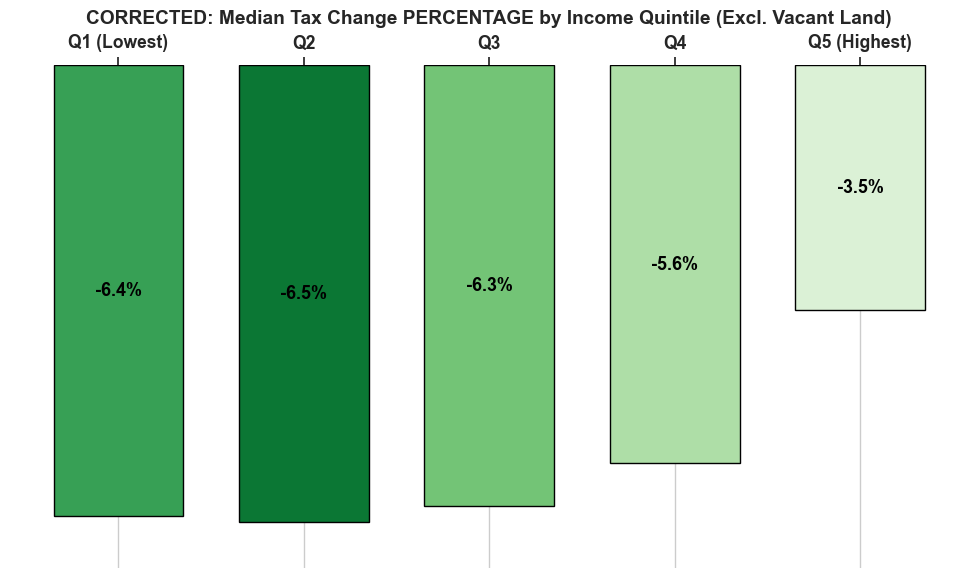

\nExplanation of the fix:
- Previous chart showed DOLLAR amounts ($) with percentage signs (%) - mathematically impossible
- This corrected chart shows actual PERCENTAGE changes
- Values like -109% would mean impossible negative taxes; real percentages are much smaller
- The tax change percentages are calculated as: (new_tax - current_tax) / current_tax * 100


In [341]:
# Fixed Chart: Calculate actual percentage values for the income quintile chart

# First, let's calculate the actual median percentage change for each quintile
def calculate_median_percentage_by_quintile(df, group_col, value_col):
    """Calculate median percentage change by quintiles"""
    # If grouping by income, exclude non-positive values
    if group_col == 'median_income':
        df = df[df['median_income'] > 0].copy()
    
    df[f'{group_col}_quintile'] = pd.qcut(df[group_col], 5, 
                                         labels=["Q1 (Lowest)", "Q2", "Q3", "Q4", "Q5 (Highest)"])
    
    summary = df.groupby(f'{group_col}_quintile').agg(
        count=('tax_change', 'count'),
        mean_tax_change=('tax_change', 'mean'),
        median_tax_change=('tax_change', 'median'),
        median_tax_change_pct=('tax_change_pct', 'median'),  # This is the key addition
        mean_value=(value_col, 'mean')
    ).reset_index()
    
    return summary

# Recalculate the income quintile summary with percentage data
non_vacant_income_quintile_summary_pct = calculate_median_percentage_by_quintile(
    non_vacant_gdf, 'median_income', 'median_income'
)

print("Corrected Income Quintile Summary (with percentages):")
display(non_vacant_income_quintile_summary_pct)

# CORRECTED Chart: Median Tax Change PERCENTAGE by Income Quintile
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set a modern style
sns.set_theme(style="whitegrid", font_scale=1.15)

# Corrected Bar Graph: Median Tax Change PERCENTAGE by Neighborhood Median Income Excluding Vacant Land
fig, ax = plt.subplots(figsize=(10, 6))

# Use the ACTUAL PERCENTAGE values, not dollar amounts with % signs
vals = non_vacant_income_quintile_summary_pct['median_tax_change_pct']
labels = non_vacant_income_quintile_summary_pct['median_income_quintile']

# Color mapping: dark green (more negative) to light green (less negative)
colors = sns.color_palette("Greens", n_colors=len(vals))
# Sort so that the most negative (largest magnitude) is darkest
color_map = [colors[i] for i in np.argsort(np.argsort(-vals))]

# To make bars start at the top and go down, invert the y-axis and plot positive heights
bars = ax.bar(
    labels,
    np.abs(vals),
    color=color_map,
    edgecolor='black',
    width=0.7
)

# Invert the y-axis so bars start at the top and go down
ax.invert_yaxis()

# Remove y-axis
ax.yaxis.set_visible(False)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title('CORRECTED: Median Tax Change PERCENTAGE by Income Quintile (Excl. Vacant Land)', 
             weight='bold', pad=30)

# Remove all spines (including bottom)
sns.despine(left=True, right=True, top=True, bottom=True)

# Add value labels (bold, % sign) centered inside each bar - NOW WITH ACTUAL PERCENTAGES
for bar, val in zip(bars, vals):
    ax.annotate(
        f"{val:.1f}%",
        xy=(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2),
        xytext=(0, 0),
        textcoords="offset points",
        ha='center', va='center',
        fontsize=13, color='black', fontweight='bold'
    )

# Move x-tick labels to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.xticks(fontweight='bold')

# Set y-limits to show bars going down from the top
ymax = np.abs(vals).max() * 1.1
ax.set_ylim(ymax, 0)

plt.tight_layout()
plt.show()

print("\\nExplanation of the fix:")
print("- Previous chart showed DOLLAR amounts ($) with percentage signs (%) - mathematically impossible")
print("- This corrected chart shows actual PERCENTAGE changes")
print("- Values like -109% would mean impossible negative taxes; real percentages are much smaller")
print("- The tax change percentages are calculated as: (new_tax - current_tax) / current_tax * 100")


In [342]:

# Print the unique cities
print("\nUnique cities:")
print(owner_info_df['city'].value_counts(dropna=False))


Unique cities:
city
SPOKANE           66003
SPOKANE VALLEY     1208
Spokane             705
COLBERT             498
SEATTLE             482
                  ...  
HARPERSVILLE          1
ST HELENS             1
BOX ELDER             1
KELLER                1
Elk                   1
Name: count, Length: 1204, dtype: int64


In [343]:
print(owner_info_df.columns)


Index(['pid', 'owner_name', 'owner_address', 'error', 'street', 'city',
       'state', 'zip'],
      dtype='object')
